Outline in this Notebook (**`02_preprocess_eda.ipynb`**):
- `How to run the notebook: Click the 'Run All` button and the notebook will run seamlessly. Please note that tuning and traing could take several minutes

- `Estimated time to run the notebook on Macbook Air 8GB RAM 256GB SSD: 45 minutes` 

#### **Sections**
1. **Introduction**
   - Brief explanation of the objectives of this section as it relates to the challenge tasks.

2. **Library Imports**
   - Import necessary libraries.

3. **Configuration Setup**
   - Load `config.yaml`.

4. **Dataset Loading and Utility Function**
   - We'll use the `data_loader.py` `data_processor.py` and utility to load processed data and htility function.

5. **Initial Inspection and Overview**
   - Display basic stats and preview data and statistical description to understand data preparedness for modeling.

6. **Save Trained and Tuned Models Models**
   - Save  models to `datasets/models/`.



### **1. `Introduction`**
This notebook focuses on training various models using the processed datasets previously saved to disk and address the challenge question . We will:
1. Load datasets using `utils/data_loader.py`.
2. Inspect the structure and contents of the datasets.
3. Perform initial cleaning where necessary.
4. Save cleaned datasets to `datasets/processed/`


To approach the task of developing and evaluating four models for property sale and rental price estimation, we will follow these steps:

**Step 1:** Prepare the Data
- **Transaction Data**: The real estate transaction data should include the following features:
  - **Property Type**
  - **Property Sub Type**
  - **Number of Rooms/Bedrooms**
  - **Property Size (sq.m)**
  - **Area/Neighborhood**
  - **Nearest Metro**
  - **Nearest Mall**
  - **Nearest Landmark**
  - **Usage** (Commercial/Residential)
  - **Average Prices the Previous Month/Week**
  
- **Supplementary Data**: We can enrich the models by integrating supplementary datasets such as:
  - **Macroeconomic indicators** (e.g., GDP growth, population)
  - **Tourism and Currency data**
  - **Consumer Price Index**
  - **Other relevant data** based on the available datasets (e.g., interest rates, real estate market trends)

**Step 2:** Model Development
We will develop **four models** as required: 
1. **Model 1**: Estimating property sale prices using **real estate transaction data** only.
2. **Model 2**: Estimating property rental prices using **real estate transaction data** only.
3. **Model 3**: Estimating property sale prices incorporating **both real estate and supplementary data**.
4. **Model 4**: Estimating property rental prices incorporating **both real estate and supplementary data**.

**Step 3:** Preprocessing and Feature Engineering
1. **Encoding categorical variables** (e.g., Property Type, Area/Neighborhood, Nearest Metro).
2. **Scaling numeric features** (e.g., Property Size, Average Prices).
3. **Handling missing values** (e.g., Imputation or removal of rows with missing critical data).

We can use standard techniques like one-hot encoding for categorical features and normalization or standardization for numerical features.

**Step 4:** Model Training
We can use a range of regression models for estimation, such as:
- **Linear Regression**
- **Decision Tree Regression**
- **Random Forest Regression**
- **Gradient Boosting Machines (GBM)**
- **XGBoost** or **LightGBM**
- **Neural Networks** (if required for more complexity)

We can start by training simpler models (e.g., linear regression) and gradually move to more complex models (e.g., random forest, XGBoost).

**Step 5:** Model Evaluation
Evaluate each model's performance using the following metrics:
- **RMSE** (Root Mean Squared Error)
- **MSE** (Mean Squared Error)
- **R²** (R-squared)

These metrics will help us assess the accuracy of each model. RMSE and MSE will give an indication of how close the predictions are to the actual values, while R² will show how well the model explains the variance in the target variable.

**Step 6:** Performance Comparison
- Compare the performance of the models (Model 1 vs. Model 3 and Model 2 vs. Model 4).
- Assess whether including supplementary data improves accuracy (using RMSE, MSE, and R²) and analyze the impact of each feature.


**Step 7:** Analyze the Impact of Supplementary Data
Once we have trained all four models, compare the results. If the models incorporating supplementary data (Models 3 and 4) show a significant improvement in accuracy, it suggests that macroeconomic factors and external data can enhance the prediction of sale and rental prices. This would confirm that real estate trends are influenced by both local transaction data and broader economic indicators.



### **2. `Library Imports`**

In [1]:

import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,root_mean_squared_error,make_scorer
from category_encoders import TargetEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from tqdm import tqdm
import shap
import lime.lime_tabular
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

sys.path.append("../utils")

# Import the data_loader module
import data_loader, data_processor, plots, model_specifics, visualizations
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
import optuna  # For Bayesian optimization
import os
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import yaml
from data_loader import load_dataset



### **3. `Load Configuration`**

In [2]:
# Load configuration
config_path = "../configs/config.yaml"
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

# Print paths and file structure for reference
raw_data_path = config["paths"]["raw_data"]
processed_data_path = config["paths"]["processed_data"]

print(f"Raw Data Path: {raw_data_path}")
print(f"Processed Data Path: {processed_data_path}")


Raw Data Path: ../datasets/raw
Processed Data Path: ../datasets/processed


### **4. `Dataset Loading and Inspection`**

In [3]:
sales_macro_df = pd.read_parquet("../datasets/processed/sales_macro_df.parquet")
rental_macro_df = pd.read_parquet("../datasets/processed/rental_macro_df.parquet")

In [4]:
sales_macro_model_df = pd.read_parquet("../datasets/processed/sales_macro_model_df.parquet")
rental_macro_model_df = pd.read_parquet("../datasets/processed/rental_macro_model_df.parquet")

In [5]:
# sales_macro_model_df['sales_price(aed)']

In [6]:

# merged_macro_transactions_df = pd.read_parquet("../datasets/processed/merged_macro_transactions.parquet", engine='fastparquet')
original_sales_df = pd.read_parquet("../datasets/processed/processed_transactions_df.parquet", engine='fastparquet')
original_rental_df = pd.read_parquet("../datasets/processed/processed_rents_df.parquet", engine='fastparquet')

imputed_sales_df = pd.read_parquet("../datasets/processed/full_sales_df.parquet", engine='fastparquet')
imputed_rentals_df = pd.read_parquet("../datasets/processed/full_rentals_df.parquet", engine='fastparquet')

targeted_rentals_df = pd.read_parquet("../datasets/processed/targeted_rentals_df.parquet")
targeted_sales_df = pd.read_parquet("../datasets/processed/targeted_sales_df.parquet")

In [7]:
imputed_sales_df.drop(columns='Transaction Date', inplace=True)
imputed_sales_df.head(2)

,Parking,Property Size (sq.m),No. of Buyer,No. of Seller,Transaction Size (sq.m),Sale Price,Usage,Property Sub Type,Room(s),Nearest Metro,...,Year,Month,Day,Hour,YearMonth,YearWeek,Price per sq.m,Avg Price Last Month,Avg Price Last Week,Number of Rooms
0,271.705672,600.51,1.0,1.0,600.51,1500000.0,Commercial,Commercial,1 B/R,Buj Khalifa Dubai Mall Metro Station,...,2022-01-01,6,2,15,629,2022-22,2497.876805,2498.688452,5150.112859,1.0
1,210.452335,112.24,1.0,1.0,112.24,815000.0,Residential,Residential,1 B/R,Buj Khalifa Dubai Mall Metro Station,...,2022-01-01,6,2,15,629,2022-22,7261.225944,7719.686097,8030.465069,1.0


In [8]:
imputed_rentals_df.head(2)

,Parking,Property Size (sq.m),Annual Rental Price,Rental Price,Is Free Hold?,Property Type,Nearest Metro,Usage,Area,Property Sub Type,Nearest Mall,Nearest Landmark,Ejari Contract Number,No of Units,Year,Month,Day,Hour
0,0.973568,14965.687721,5000.0,25000.0,Free Hold,Building,Rashidiya Metro Station,Industrial,Dubai Investment Park Second,Factory,Dubai Mall,Expo 2020 Site,120210425000238,1,2021-01-01,4,25,9
1,0.972854,6792.000000,4000000.0,16000000.0,Free Hold,Building,Rashidiya Metro Station,Residential,Um Nahad Third,Building,Dubai Mall,Dubai International Airport,120210526001582,1,2021-01-01,5,26,12


In [9]:
targeted_rentals_df

,property_area(sq.m),property_location,avg_rent_last_week,annual_rental_prices(aed),property_type,rental_price_per_sqm,avg_rent_last_month,property_sub_type,nearest_metro,nearest_mall,nearest_landmark,usage,year
0,5695.0,80.0,52.677788,300000.0,0.0,52.677788,52.677788,14.0,54.0,2.0,4.0,3.0,2021-01-01
3,806.0,61.0,12.406948,10000.0,0.0,12.406948,12.406948,7.0,39.0,4.0,9.0,2.0,2021-01-01
5,26730.0,81.0,13.500000,360855.0,0.0,13.500000,13.500000,14.0,20.0,2.0,4.0,3.0,2021-01-01
6,1175.0,23.0,680.851064,800000.0,0.0,680.851064,680.851064,41.0,21.0,4.0,9.0,1.0,2021-01-01
7,8957.0,98.0,312.604667,2800000.0,0.0,312.604667,312.604667,14.0,21.0,4.0,9.0,3.0,2021-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176490,171.0,58.0,849.625934,150000.0,2.0,877.192982,815.415969,52.0,38.0,4.0,0.0,4.0,2013-01-01
2176491,171.0,58.0,861.399732,165000.0,2.0,964.912281,858.852622,52.0,38.0,4.0,0.0,4.0,2015-01-01
2176492,165.0,58.0,861.399732,168000.0,2.0,1018.181818,858.852622,52.0,38.0,4.0,0.0,4.0,2015-01-01
2176493,165.0,58.0,924.052266,180000.0,2.0,1090.909091,858.852622,52.0,38.0,4.0,0.0,4.0,2015-01-01


- Let's confirm the state of the selected dataset ahead of modeling

In [10]:
# model_features_df.drop_duplicates(inplace=True)
# model_features_df = data_processor.optimize_dataframe_memory(model_features_df)
data_processor.display_dataframe_info(imputed_rentals_df)

Shape: (4703994, 18)
Dtypes: ['Parking:float32', 'Property Size (sq.m):float64', 'Annual Rental Price:float64', 'Rental Price:float64', 'Is Free Hold?:category', 'Property Type:category', 'Nearest Metro:category', 'Usage:category', 'Area:category', 'Property Sub Type:category', 'Nearest Mall:category', 'Nearest Landmark:category', 'Ejari Contract Number:int64', 'No of Units:int16', 'Year:datetime64[ns]', 'Month:int8', 'Day:int8', 'Hour:int8']
Missings (%): ['Parking:0.00%', 'Property Size (sq.m):0.00%', 'Annual Rental Price:0.00%', 'Rental Price:0.00%', 'Is Free Hold?:0.00%', 'Property Type:0.00%', 'Nearest Metro:0.00%', 'Usage:0.00%', 'Area:0.00%', 'Property Sub Type:0.00%', 'Nearest Mall:0.00%', 'Nearest Landmark:0.00%', 'Ejari Contract Number:0.00%', 'No of Units:0.00%', 'Year:0.00%', 'Month:0.00%', 'Day:0.00%', 'Hour:0.00%']
Total missings (%): 0.00%
total duplicates: 0
Total memory usage: 296.08 MB


,Parking,Property Size (sq.m),Annual Rental Price,Rental Price,Is Free Hold?,Property Type,Nearest Metro,Usage,Area,Property Sub Type,Nearest Mall,Nearest Landmark,Ejari Contract Number,No of Units,Year,Month,Day,Hour
0,0.973568,14965.687721,5000.0,25000.0,Free Hold,Building,Rashidiya Metro Station,Industrial,Dubai Investment Park Second,Factory,Dubai Mall,Expo 2020 Site,120210425000238,1,2021-01-01,4,25,9
1,0.972854,6792.000000,4000000.0,16000000.0,Free Hold,Building,Rashidiya Metro Station,Residential,Um Nahad Third,Building,Dubai Mall,Dubai International Airport,120210526001582,1,2021-01-01,5,26,12


- separate numerical features from non-numericals

In [11]:
# rentals_merged_numerical_features =   imputed_rentals_df.select_dtypes(include=[np.number]).columns
# rentals_merged_categorical_features = imputed_rentals_df.select_dtypes(exclude=[np.number]).columns

# sales_merged_numerical_features =   imputed_sales_df.select_dtypes(include=[np.number]).columns
# sales_merged_categorical_features = imputed_sales_df.select_dtypes(exclude=[np.number]).columns

- check for correlations between targets and within features

In [12]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# def plot_correlation_heatmap(df, numerical_features, title="Correlation Heatmap"):
#     """
#     Plots a correlation heatmap for the numerical features in a DataFrame and returns the correlation matrix.

#     Parameters:
#         df (pd.DataFrame): Input DataFrame.
#         numerical_features (list): List of numerical feature column names.
#         title (str): Title of the heatmap.

#     Returns:
#         pd.DataFrame: The correlation matrix.
#     """
#     plt.figure(figsize=(14, 5))
#     corr_matrix = df[numerical_features].corr()
#     sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
#     plt.title(title)
#     plt.show()

#     print(f"Correlation Matrix for {title}:")
#     return corr_matrix


# corr_matrix_sales = plot_correlation_heatmap(
#     sales_model_features_df, 
#     numerical_features=sales_merged_numerical_features, 
#     title="Correlation Heatmap of Numerical Features (Sales)"
# )

# corr_matrix_sales


Detailed dataset overview and correlation matrices observations:

---


1. **High Correlations**:
   - Some features in the sales dataset, such as `Parking` and `Property Size (sq.m)`, are highly correlated.
   - Similarly, in the rentals dataset, `Annual Rental Price` and `Rental Price` have a strong correlation (0.817).
   - **Action**: We can drop dropping one feature from pairs with high correlations to avoid multicollinearity, especially in models like linear regression. Dropping both can be done during training too since `Annual Rental Price` is a target variable.

2. **Low or Insignificant Correlations**:
   - Features like `Year`, `Month`, and `Day` in the sales dataset show minimal correlation with `Sale Price`.
   - Similarly, `Ejari Contract Number` in the rentals dataset show almost no correlation with `Annual Rental Price` or `Rental Price`.
   - **Action**: Can be dropped except being used for creating interaction features with more others.

3. **Missing Data**:
   - Some features, like `Avg Price Last Month` (1.44%) and `Avg Price Last Week` (0.28%), have minor missing values.
   - **Action**: Should be imputed using mean or median.

4. **Derived Features**:
   - Features such as `Price per sq.m` are highly relevant and should be included in the model.
   - **Action**: Should be retained and used for engineered features.

5. **Scaling**:
   - Features like `Property Size (sq.m)` and `Parking` are on vastly different scales.
   - **Action**: Standardizing numerical features to improve model convergence.

---



- **`Important considerations`**

1. ***Model Selection and Diversity***
- Ensemble Models:
   - A combination of models (e.g., Random Forest, XGBoost, LightGBM) and stack them to create a meta-model.
   - Blending and bagging techniques for more robust predictions.
- Deep Learning: If feasible, a neural network (e.g., MLP or Transformer-based architecture) for high-dimensional or temporal data can be utilized
- Baseline Comparisons: Clear comparisons between simple models (e.g., linear regression) and advanced techniques to highlight the improvements.

2. ***Dataset Preparation and Enrichment***
- Data Quality: no missing values, duplicates, and outliers. No imbalances (mostly for classification)

- Feature Engineering:
  - Interaction terms, ratios, and normalized metrics can be created to.
  - Temporal Features like month, seasonality, or time trends from date columns.
  - Geospatial Features  like distance to landmarks or metro.
  - External Data like economic indicators (supplied), regional trends, or weather data  to enhance the model's context.

3. ***Hyperparameter Tuning***
- Systematic Searches like Bayesian optimization or Randomized Search instead of exhaustive grid search for more efficient hyperparameter tuning.
- Early Stopping criteria during training to avoid overfitting

4. ***Explainability***
- Feature Importance:
  - SHAP or LIME for contribution of each feature to predictions.
  - Bar plots or heatmaps of feature importances.
- Model Interpretation: Include insights into why certain models performed better and which features drive predictions.
- Documentation of choices made and methodology

5. ***Robustness Testing***
- Cross-Validation to ensure results are stable across multiple folds or random seeds.
- Error Analysis:
  - Investigation of poorly performed models.
  - Grouping errors by key features (e.g., property type, location) to identify systematic biases. 
  -  Cross-Validation RMSE, Test RMSE, MAE, and R².
- Generalizability: Testing of models on unseen subsets or simulating real-world scenarios.
- Handling Overfitting/Underfitting using train-test-val sets to ensure models generalize well to unseen data.

- Train-Test Split: Incorporate a holdout test set for final evaluation. This ensures models generalize well to unseen data:

6. ***Computational Efficiency***
Optimize runtime by:
- Using smaller, representative datasets for initial experiments.
- Leveraging GPU/TPU acceleration for computationally heavy models.
- Profiling your code to identify bottlenecks.
- Setting `n_jobs=-1` for both GridSearchCV and models (like Random Forest or XGBoost) to fully utilize computational resources.


7. ***Practical Application and Insights***
- Actionable Insights of practical takeaways for real estate stakeholders:
  - Identify key drivers of sale/rental prices.
  - Highlight undervalued areas or segments with growth potential.
- Scenario Simulation:
   - Predicting how changes in external factors (e.g., population growth, metro proximity) might influence prices.
   - Evaluating the impact of economic indicators on model predictions.

8. **Final Touches**
- Logging and Saving Results of `best_models `and `metrics` as JSON/pickle or CSV for easy retrieval
- Visualizing Results by plotting RMSE, MAE, and R² for easier comparison of model performances
- Pipeline Automation: Packaging of pipeline for easy reproducibility (e.g., use joblib or pickle to save models, snakemake or prefect for orchestration).
- Clean and Modular Code organized as scripts into reusable modules for data preprocessing, feature engineering, modeling, and evaluation.
- Deployment-Ready Solution:
  - Creating a simple interface (e.g., Streamlit or Flask) to demonstrate predictions for new data inputs.
  - Showcasing a real-time prediction demo if possible.

In [13]:
# def visualize_missing_values(df, title="Percentage of Missing Values by Feature"):
#     """
#     Calculates and visualizes the percentage of missing values for each feature in a DataFrame.
    
#     Parameters:
#     - df (pd.DataFrame): The DataFrame to analyze.
#     - title (str): The title for the visualization.

#     Returns:
#     - pd.DataFrame: A DataFrame with missing percentages for each feature.
#     """
#     # Calculate missing values and percentages
#     missing_values = df.isnull().sum()
#     missing_percent = (missing_values / len(df)) * 100
#     missing_df = pd.DataFrame({
#         'Feature': missing_values.index,
#         'MissingPercent': missing_percent
#     }).sort_values(by='MissingPercent', ascending=False)

#     # Visualize missing values
#     plt.figure(figsize=(14, 6))
#     sns.barplot(data=missing_df, y='Feature', x='MissingPercent', palette='viridis',hue='Feature', legend=False)
#     plt.title(title)
#     plt.xlabel("Missing Percentage (%)")
#     plt.ylabel("Feature")
#     plt.show()
    
#     return missing_df

# # Analyze and visualize missing values in the merged_real_estate_df
# missing_sales_model_features_df = visualize_missing_values(
#     df=sales_model_features_df,
#     title="Percentage of Missing Values by Feature (Sales)"
# )

# # Display the summary DataFrame
# print(missing_sales_model_features_df)


- Summary Stats

1a. Rentals Numerical Stats

In [14]:
# print("number of numerical features(Rentals):",  len(rentals_merged_numerical_features))
# print("Summary Stats(Rentals):")
# rentals_model_features_df[rentals_merged_numerical_features].describe().T

1b. Rentals Category Stats

In [15]:
imputed_rentals_df.isnull().sum().sum()

0

In [16]:
# print("number of categorical features(Rentals):",  len(rentals_merged_categorical_features))
# print("Category Summary Stats (Rentals):")
# rentals_model_features_df[rentals_merged_categorical_features].describe(exclude='number').T

2a. Sales Numerical Stats

In [17]:
# print("number of numerical features(Sales):",  len(sales_merged_numerical_features))
# print("Summary Stats(Sales):")
# sales_model_features_df[sales_merged_numerical_features].describe().T

In [18]:
# print("number of categorical features(Sales):",  len(sales_merged_categorical_features))
# print("Cat Summary Stats (Sales:)")
# sales_model_features_df[sales_merged_categorical_features].describe().T

In [19]:
# sales_model_features_df['Year'] = pd.to_datetime(sales_model_features_df['Year'])
# print('Sales Dtype for Year:', sales_model_features_df['Year'].dtypes)


---

**Sales Dataset:**
**Numerical Features (16):**
- **Parking, Property Size (sq.m), and Transaction Size (sq.m):**
  - High variance and extreme max values suggest the need for outlier handling or normalization.
  - Negative minimum values in `Transaction Size` and `Parking` require investigation for data integrity.
  
- **No. of Buyer and No. of Seller:**
  - Small variance with most values likely clustered around 1. Could be used as categorical or binary indicators.

- **Sale Price and Price per sq.m:**
  - Skewed distribution with a massive range. Transformation (e.g., log-scaling) may be beneficial.
  - Missing values in `Price per sq.m` (~0.01%) need imputation.

- **Date-related features (Year, Month, Day, Hour, YearMonth):**
  - Could be encoded cyclically (e.g., sine/cosine transformation for `Month`, `Day`, `Hour`) to preserve temporal information.

- **Aggregates (Avg Price Last Month/Week):**
  - Minimal missing data but likely high correlation with `Price per sq.m`. Check multicollinearity.

**Categorical Features (14):**
- **Usage, Property Sub Type, Area, Nearest Metro/Mall/Landmark:**
  - High cardinality in some features (e.g., `Area`, `Property Sub Type`).
  - Encode low-cardinality features (e.g., `Usage`, `Is Free Hold?`) directly; consider target encoding or embeddings for high-cardinality features.

- **Transaction-related:**
  - Features like `Transaction Type` and `Transaction Sub Type` have low variability and might add little to the model.

---

**Rentals Dataset:**
**Numerical Features (6):**
- **Property Size (sq.m), Rental Price, Annual Rental Price:**
  - Extreme values and negative minimums in `Rental Price` and `Property Size` require careful outlier handling.
  - Log transformation could help normalize skewed distributions.

- **Ejari Contract Number:**
  - High variance and unclear numerical relevance. Consider excluding or converting it to categorical.

- **No. of Units:**
  - Low variability with most values near 1. May indicate single-unit properties.

**Categorical Features (9):**
- **Is Free Hold, Property Type, Area, Usage:**
  - Distributions align with the sales dataset; similar encoding strategies apply.
  - High frequency of a single category (e.g., `Non Free Hold`, `Residential`) may reduce informativeness.

- **Nearest Metro/Mall/Landmark:**
  - Location features are crucial for rentals but require encoding to capture spatial relationships effectively.

- **Year:**
  - Dates are recorded with timestamps. Extract relevant parts (e.g., year, month) and encode cyclically.

---

**Actionable Insights:**
1. **Feature Scaling & Outlier Handling:**
   - Use robust methods (e.g., IQR or z-score) to address extreme values in size and price-related features.

2. **Imputation:**
   - Handle missing data in numerical features (e.g., `Price per sq.m`) using median or interpolation.
   - Investigate patterns in missing values (e.g., do they depend on specific categories?).

3. **Encoding:**
   - Encode low-cardinality categorical features with one-hot or label encoding.
   - Use embeddings or target encoding for high-cardinality features like `Area` or `Nearest Landmark`.

4. **Feature Engineering:**
   - Aggregate location-based features (e.g., nearest metro and mall distances) for combined importance.
   - Transform date features to capture seasonality and temporal trends.

5. **Investigate Negative Values:**
   - Understand whether negative values in `Parking`, `Transaction Size`, and `Rental Price` are errors or represent cancellations/adjustments.

6. **Multicollinearity Check:**
   - Evaluate correlation matrices and VIFs to address redundant features like `Avg Price Last Month/Week` and `Price per sq.m`.

---



**Step 1: Outlier Detection and Contextual Linking**

In [20]:
imputed_rentals_df.duplicated().sum()

0

In [21]:
# # Define thresholds for outlier detection
# def investigate_anomalies(df, feature, low_quantile=0.01, high_quantile=0.99):
#     q_low = df[feature].quantile(low_quantile)
#     q_high = df[feature].quantile(high_quantile)
#     anomalies = df[(df[feature] < q_low) | (df[feature] > q_high)]
#     return anomalies

# anomaly_reports = {}
# features_to_investigate = [
#     'Property Size (sq.m)', 'Sale Price', 'Parking', 
#     'Avg Price Last Month', 'Transaction Size (sq.m)'
# ]

# for feature in features_to_investigate:
#     anomalies = investigate_anomalies(sales_model_features_df, feature)
#     anomaly_reports[feature] = anomalies[['Year', 'Area', 'Property Sub Type', feature]]
    

# def plot_anomalies_with_threshold(anomaly_reports, features_to_investigate, annotate_limit=5):
#     """
#     Plot anomalies for each feature with threshold lines and annotations.

#     Parameters:
#         anomaly_reports (dict): Dictionary where keys are features and values are DataFrames of anomalies.
#         features_to_investigate (list): List of feature names to plot.
#         annotate_limit (int): Maximum number of points to annotate per feature.
#     """
#     num_features = len(features_to_investigate)
#     num_rows = (num_features + 1) // 2  # Rows for subplots
#     plt.figure(figsize=(14, 4 * num_rows))

#     for idx, feature in enumerate(features_to_investigate, start=1):
#         plt.subplot(num_rows, 2, idx)

#         # Scatterplot with anomalies highlighted
#         data = anomaly_reports[feature]
#         sns.scatterplot(
#             data=data,
#             x='Year',
#             y=feature,
#             hue='Area',
#             palette='tab20',
#             alpha=0.7,
#             legend=False
#         )

#         # Calculate thresholds
#         feature_values = data[feature]
#         threshold_upper = feature_values.mean() + 3 * feature_values.std()
#         threshold_lower = feature_values.mean() - 3 * feature_values.std()

#         # Add horizontal threshold lines
#         plt.axhline(y=threshold_upper, color='red', linestyle='--', linewidth=1.2, label="Upper Threshold")
#         plt.axhline(y=threshold_lower, color='blue', linestyle='--', linewidth=1.2, label="Lower Threshold")

#         # Annotate anomalies
#         top_anomalies = data.nlargest(annotate_limit, feature)
#         for _, row in top_anomalies.iterrows():
#             plt.text(
#                 x=row['Year'],
#                 y=row[feature],
#                 s=row['Area'][:10],  # Shorten Area name for clarity
#                 fontsize=8,
#                 color="darkred",
#                 alpha=0.8
#             )

#         plt.title(f"Anomalies in {feature}")
#         plt.xlabel('Year')
#         plt.ylabel(feature)
#         plt.grid(alpha=0.3)
#         plt.tight_layout()

#     plt.show()

# plot_anomalies_with_threshold(anomaly_reports, features_to_investigate, annotate_limit=5)


---

Step 2: Patterns and Insights

1. Group by Contextual Columns:
   - Check if anomalies are clustered by Year, Area, or Property Sub Type.

2. Visualize Patterns:
   - Use scatter plots to observe the distribution of anomalies across years and areas.

In [22]:
# def plot_anomalies_optimized(anomaly_reports, features_to_investigate, annotate_limit=10):
#     """
#     Optimized plotting function for anomalies with reduced annotations.

#     Parameters:
#         anomaly_reports (dict): Dictionary with features as keys and anomaly DataFrames as values.
#         features_to_investigate (list): List of features to plot anomalies for.
#         annotate_limit (int): Maximum number of points to annotate per feature.
#     """
#     plt.figure(figsize=(14, 4 * len(features_to_investigate) // 2))

#     for idx, feature in enumerate(features_to_investigate, start=1):
#         plt.subplot((len(features_to_investigate) + 1) // 2, 2, idx)
        
#         # Scatterplot with anomalies highlighted
#         ax = sns.scatterplot(
#             data=anomaly_reports[feature],
#             x='Year',
#             y=feature,
#             hue='Area',
#             palette='tab20',
#             alpha=0.7,
#             legend=False
#         )
        
#         # Select the most extreme anomalies to annotate
#         top_anomalies = anomaly_reports[feature].nlargest(annotate_limit, feature)

#         # Indicating only top N data points with annotations
#         for _, row in top_anomalies.iterrows():
#             ax.text(
#                 x=row['Year'],
#                 y=row[feature],
#                 s=f"{row['Area'][:10]}",
#                 fontsize=8,
#                 color="red",
#                 alpha=0.6
#             )
        
#         plt.title(f"Anomalies in {feature}")
#         plt.tight_layout()

#     plt.show()

# plot_anomalies_optimized(anomaly_reports, features_to_investigate, annotate_limit=5)


**Observations and Insights from the Anomaly Investigation**

 1. **`Property Size (sq.m)`**
   - ***Key Insights***:
     - Values range from very small sizes (e.g., **7.44 sq.m** for "Hotel Rooms") to extremely large sizes (e.g., **494,565.45 sq.m** for "Commercial" properties).
     - Large sizes are mainly observed in **industrial**, **agricultural**, and **commercial** areas like **Ras Al Khor** and **Al Khawaneej**.
     - Small sizes are concentrated in residential or hotel properties.
   - **Patterns**:
     - Significant outliers occur in both directions, likely influenced by property subtypes.

---

 2. **`Sale Price`**
   - **Key Insights**:
     - Low prices (e.g., **AED 66,500**) appear for flats in less central areas like **Dubai Production City**.
     - High prices (e.g., **AED 65 million**) are associated with commercial properties in prime locations like **Zareeba Duviya** and **Hor Al Anz East**.
   - **Patterns**:
     - Outliers often represent either low-priced flats or high-value commercial properties.
     - Prices are linked to property subtypes and area demand.

---

3. **`Parking`**
   - **Key Insights**:
     - Negative parking values (e.g., **-1**) likely represent data errors.
     - Extremely high parking counts (e.g., **2042** in **Jumeirah Village Circle**) might indicate shared or public parking lots.
   - **Patterns**:
     - Unrealistic values occur in residential flats, particularly in **Dubai Marina** and **The Greens**.

---

4. **`Avg Price per sq.m Last Month`**
   - **Key Insights**:
     - Some extremely low values (e.g., **1 AED/sq.m**) are likely incorrect, especially for commercial areas.
     - Very high values (e.g., **75,349.84 AED/sq.m**) occur in select areas like **Al Buteen**.
   - **Patterns**:
     - Outliers are linked to both commercial and residential areas, depending on the locality and year.

---


Further Actions

1. **Clean Specific Features**:
   - Treat outliers by capping extreme values based on percentiles or logical thresholds.
   - Replace negative values (e.g., **Parking = -1**) with appropriate defaults or impute based on similar records.

2. **Create Derived Features**:
   - **Price-to-Size Ratios**: Calculate price per sq.m as a new feature for sale and rental prices.
   - **Trend Features**: Use `Year` and `YearMonth` to create moving averages or trend indicators.

3. **Encoding and Clustering**:
   - Apply **target encoding** for high-cardinality columns like `Area` and `Property Sub Type`.
   - Use clustering techniques to group areas with similar pricing or property characteristics.

---


Removing realistic outliers, even if extreme, can strip the model of valuable information about high-value or unique scenarios. We can approach this issue thoughtfully:

---

1. **Categorize Outliers**:
   - Separate **realistic** outliers from **erroneous** ones. For example:
     - **Realistic**: High sale prices for commercial properties in prime areas like Dubai Marina.
     - **Erroneous**: Negative values or impossible values like 1 AED/sq.m for commercial properties.
   - Realistic outliers often align with domain knowledge (e.g., luxury, location).

2. **Analyze High-Density Relationships**:
   - Investigate relationships between features. For instance:
     - **High prices** might correlate with location (`Area`) or property type (`Commercial` or `Hotel Apartment`).
     - **Large property sizes** might align with `Industrial` or `Agricultural` uses.
   - Retain these "high-density" patterns by creating features that better capture these relationships.

3. **Feature Scaling Instead of Removal**:
   - Normalize or log-transform features to reduce the influence of extreme values without outright removal.

4. **Test Impact of Outliers**:
   - Train models with and without realistic outliers to evaluate their effect on accuracy and generalizability.
   - Use visualizations like residual plots to assess if models account for extreme values properly.

---

**Steps to Proceed**
1. **Quantitative Outlier Analysis**:
   - Compute percentiles for outlier values (e.g., 1st and 99th) and their relationships to key features like `Area` and `Property Type`.

2. **Mark and Retain Realistic Outliers**:
   - For each feature, tag values as:
     - **Erroneous**: Data corrections or replacements needed.
     - **Extreme but Realistic**: Retain and let the model learn from them.

3. **Advanced Feature Engineering**:
   - Incorporate outlier context as derived features:
     - **Area Premium**: Ratio of price to average price in that area.
     - **Luxury Indicator**: Flag properties with sizes or prices beyond a threshold (e.g., luxury hotels).

---



| **Feature**                        | **Lower Bound (1st Percentile)** | **Upper Bound (99th Percentile)** | **Lower Outliers Count** | **Upper Outliers Count** |
|------------------------------------|----------------------------------|----------------------------------|--------------------------|--------------------------|
| **Number of Rooms**                | 3.0                              | 4.0                              | 0                        | 83                       |
| **Property Size (sq.m)**           | 31.93                            | 5601.68                          | 8193                     | 8266                     |
| **Sale Price**                     | 197,000.0                        | 42,393,310.72                    | 8260                     | 8268                     |
| **Rental Price**                   | 55,000.0                         | 150,000.0                        | 0                        | 515                      |
| **Parking**                        | 0.0                              | 329.0                            | 2011                     | 8259                     |
| **Avg Price per sq.m Last Month**  | 546.73                           | 33,275.83                        | 8265                     | 8264                     |
| **Annual Rental Price**            | 56,000.0                         | 150,000.0                        | 0                        | 514                      |
| **No. of Buyer**                   | 0.0                              | 2.0                              | 0                        | 6218                     |
| **Avg Price per sq.m Last Week**   | 445.30                           | 33,807.13                        | 8264                     | 8267                     |
| **Year**                           | 2001.0                           | 2022.0                           | 6541                     | 0                        |
| **YearMonth**                      | 378.0                            | 628.0                            | 8257                     | 984                      |
| **No. of Seller**                  | 0.0                              | 3.0                              | 0                        | 6633                     |

---


1. **General Trends**:
   - **High Outlier Counts**: Features like *Property Size (sq.m)*, *Sale Price*, *Avg Price per sq.m*, and *YearMonth* exhibit large numbers of both lower and upper outliers, indicating potential data irregularities or genuine extreme values.
   - **Zero Lower Outliers**: Features like *Number of Rooms*, *Rental Price*, and *No. of Buyer* have no lower outliers, suggesting lower bounds are well-contained within expected ranges.

2. **Specific Features**:
   - **Property Size (sq.m)**: A substantial number of both lower (8193) and upper (8266) outliers suggest that properties at the extreme ends, such as very small apartments or expansive commercial/industrial areas, need further examination.
   - **Sale Price**: Outliers on both ends (8260 lower and 8268 upper) likely correspond to affordable housing versus luxury estates or significant transactions.
   - **Parking**: Large counts of upper (8259) and lower (2011) outliers may be attributed to misrecorded values or exceptional cases like large-scale developments.
   - **Year and YearMonth**: High counts of lower outliers in *Year* (6541) and *YearMonth* (8257) suggest data from older records, which might require differentiation from recent data trends.

3. **Action Points**:
   - **Feature-Specific Cleaning**:
     - Examine extreme values for *Property Size*, *Sale Price*, and *Parking* to determine whether they represent real properties or data entry errors.
     - Investigate high *YearMonth* outliers for trends related to older data records.
   - **Retain Meaningful Outliers**:
     - Keep genuine extreme values (e.g., luxury properties, large commercial areas) for model robustness while ensuring abnormalities (e.g., erroneous values) are corrected or excluded.
   - **Further Modeling Steps**:
     - Use robust algorithms like **Random Forests**, **Gradient Boosting**, or **Huber Regression** to incorporate outliers into models.
     - Derive features to distinguish property types or time trends, ensuring the outliers add interpretive value.

In [23]:
# def calculate_outlier_percentiles(df, numerical_features):
#     # Calculate the 1st and 99th percentiles for each numerical feature
#     outliers_info = {}
    
#     for feature in numerical_features:
#         lower_percentile = df[feature].quantile(0.01)
#         upper_percentile = df[feature].quantile(0.99)
        
#         outliers_info[feature] = {
#             'lower_percentile': lower_percentile,
#             'upper_percentile': upper_percentile,
#             'lower_outliers': df[df[feature] < lower_percentile],
#             'upper_outliers': df[df[feature] > upper_percentile]
#         }
    
#     return outliers_info

# # Apply to our numerical features
# outliers_info = calculate_outlier_percentiles(sales_model_features_df, sales_merged_numerical_features)

# # Output the summary
# # for feature, info in outliers_info.items():
# #     print(f"\nOutlier Information for {feature}:")
# #     print(f"Lower Bound (1st Percentile): {info['lower_percentile']}")
# #     print(f"Upper Bound (99th Percentile): {info['upper_percentile']}")
# #     print(f"Lower Outliers Count: {len(info['lower_outliers'])}")
# #     print(f"Upper Outliers Count: {len(info['upper_outliers'])}")


In [24]:
# def analyze_outliers_by_context(df, outliers_info):
#     outlier_analysis = {}
    
#     for feature, info in outliers_info.items():
#         # Analyze context of lower and upper outliers
#         lower_outliers_context = df.loc[info['lower_outliers'].index, ['Area', 'Property Type']]
#         upper_outliers_context = df.loc[info['upper_outliers'].index, ['Area', 'Property Type']]
        
#         outlier_analysis[feature] = {
#             'lower_outliers_context': lower_outliers_context['Area'].value_counts(),
#             'upper_outliers_context': upper_outliers_context['Area'].value_counts()
#         }
    
#     return outlier_analysis

# # Analyze context for outliers
# outlier_analysis = analyze_outliers_by_context(sales_model_features_df, outliers_info)

# # Display context analysis results
# # for feature, context in outlier_analysis.items():
# #     print(f"\nOutliers Context for {feature}:")
# #     print("Lower Outliers Context by Area:", context['lower_outliers_context'])
# #     print("Upper Outliers Context by Area:", context['upper_outliers_context'])


In [25]:
# def get_unique_values(df, max_values=10):
#     """
#     Returns the unique values for each feature in a DataFrame.

#     Parameters:
#     - df (pd.DataFrame): The DataFrame to analyze.
#     - max_values (int): Maximum number of unique values to display per feature (default: 10).

#     Returns:
#     - pd.DataFrame: A summary of features and their unique values.
#     """
#     unique_summary = []

#     for col in df.columns:
#         # unique_vals = df[col].dropna().unique()  # Exclude NaN for unique values
#         unique_vals = df[col].unique()  # Exclude NaN for unique values
#         unique_count = len(unique_vals)
#         sample_vals = unique_vals[:max_values]  # Display up to max_values unique entries

#         unique_summary.append({
#             "Feature": col,
#             "Unique Count": unique_count,
#             "Unique Values (Sample)": sample_vals
#         })


#     summary_df = pd.DataFrame(unique_summary)

#     # Format for readability
#     summary_df["Unique Values (Sample)"] = summary_df["Unique Values (Sample)"].apply(lambda x: ', '.join(map(str, x)))

#     return summary_df


# unique_summary = get_unique_values(sales_model_features_df)
# unique_summary

In [26]:
# sales_model_features_df['Property Sub Type'].unique()
# model_features_df['Property Sub Type'].apply(type).nunique() > 1

The unique values in the `Property Sub Type` column appear to have some inconsistencies or potential issues that might warrant further investigation and cleaning. Here are some observations:

1. **Mixed Granularity**:
   - Some values are generic, like `Residential` and `Commercial`, which represent broad categories.
   - Others are more specific, like `Flat`, `Villa`, and `Hotel Apartment`. Mixing broad and specific categories may lead to ambiguities during analysis.

2. **Inconsistent Naming**:
   - `Multi Store Parcking` seems to have a typo; it likely should be `Multi-Storey Parking`.
   - Variants like `Commercial / Offices / Residential` combine multiple categories, which could complicate downstream processing or classification.

3. **Unusual Entries**:
   - `Mosque`, `Embassy`, and `Store` stand out as property types that might be considered anomalies depending on the dataset's purpose (e.g., residential or commercial property analysis).

4. **Categorization Issues**:
   - Some values may overlap with other categories (e.g., `Building` could fall under `Residential` or `Commercial` depending on the context).

---

Recommended Steps for Cleaning:
1. **Normalize Typographical Errors**:
   - Correct typos like `Multi Store Parcking` to `Multi-Storey Parking`.

2. **Group Related Categories**:
   - If the analysis focuses on broader property types, group specific entries (e.g., `Flat`, `Villa`) under `Residential`.

3. **Verify Outliers**:
   - Evaluate whether entries like `Mosque`, `Embassy`, and `Store` are relevant to the dataset's purpose. If not, consider excluding or reclassifying them.

4. **Check Frequency Distribution**:
   - Examine the distribution of these categories to identify sparse entries that might be grouped under an "Other" category.

---



Hcomprehensive function to analyze and clean categorical features like `Property Sub Type`.

Function

```python
import pandas as pd
from collections import Counter

def clean_categorical_feature(df, column, corrections=None, groupings=None, min_frequency=None):
    """
    Cleans and analyzes a categorical feature.

    Args:
        df (pd.DataFrame): DataFrame containing the column to clean.
        column (str): The column name to analyze and clean.
        corrections (dict, optional): Dictionary for correcting typos or inconsistent values.
                                      Format: {"typo": "correct_value"}.
        groupings (dict, optional): Dictionary for grouping similar categories.
                                    Format: {"group_name": ["value1", "value2", ...]}.
        min_frequency (int, optional): Minimum frequency for a value to remain as a separate category.
                                       Values below this will be grouped into "Other".
    
    Returns:
        pd.DataFrame: Cleaned DataFrame with modifications in the specified column.
        pd.DataFrame: Frequency table of the unique values in the column.
    """
    # Step 1: Correct Typographical Errors
    if corrections:
        df[column] = df[column].replace(corrections)
    
    # Step 2: Group Related Categories
    if groupings:
        grouping_map = {value: group for group, values in groupings.items() for value in values}
        df[column] = df[column].map(grouping_map).fillna(df[column])  # Map and retain unmapped values
    
    # Step 3: Group Sparse Categories
    if min_frequency:
        value_counts = df[column].value_counts()
        sparse_values = value_counts[value_counts < min_frequency].index
        df[column] = df[column].replace(sparse_values, "Other")
    
    # Step 4: Create a Frequency Table
    frequency_table = pd.DataFrame(df[column].value_counts()).reset_index()
    frequency_table.columns = [column, 'Frequency']
    frequency_table['Percentage'] = (frequency_table['Frequency'] / len(df)) * 100

    return df, frequency_table
```

---

Example Usage

1. **Define Cleaning Rules**:
```python
# Typo corrections
corrections = {
    "Multi Store Parcking": "Multi-Storey Parking"
}

# Group related categories
groupings = {
    "Residential": ["Flat", "Villa", "Unit", "Residential"],
    "Commercial": ["Commercial", "Office", "Building"],
    "Special Use": ["Mosque", "Embassy", "Car Services"]
}

# Minimum frequency threshold for grouping sparse categories
min_frequency = 100  # Group values appearing less than 100 times into "Other"
```

2. **Clean and Analyze**:
```python
cleaned_df, frequency_table = clean_categorical_feature(
    model_features_df,
    column="Property Sub Type",
    corrections=corrections,
    groupings=groupings,
    min_frequency=min_frequency
)

# Display Frequency Table
print(frequency_table)

# Review cleaned column
print(cleaned_df["Property Sub Type"].unique())
```

---

Output
- **Frequency Table**: Lists all unique categories, their frequency, and percentage in the dataset.
- **Cleaned Column**: Updated column in the DataFrame with corrected, grouped, and consolidated values.

In [27]:
# original_sales_df['Amount'].hist(figsize=(25, 10), bins=40)

In [28]:
# original_sales_df[['Amount','Transaction Date']].plot()
# sales_model_features_df[['Sale Price','Year']].plot()
# sales_model_features_df['Sale Price'].hist(figsize=(25, 10), bins=40)
# plt.show()

In [29]:
# import warnings
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer
# from category_encoders import TargetEncoder
# warnings.filterwarnings(
#     action='ignore'
# )


# def preprocess_data(df, dataset_type="sales"):
#     """
#     Preprocess the data by dropping irrelevant columns and handling missing values.

#     Parameters:
#         df (pd.DataFrame): Input DataFrame to preprocess.
#         dataset_type (str): Specify either 'sales' or 'rentals' to apply dataset-specific preprocessing.

#     Returns:
#         pd.DataFrame: Preprocessed DataFrame.
#     """
#     drop_features = ['Year', 'Month', 'Day', 'Hour', 'YearMonth', 'Ejari Contract Number']
#     if dataset_type == "rentals":
#         drop_features = ['Ejari Contract Number']
    
#     df = df.drop(columns=drop_features, errors='ignore')

#     # Handle missing values
#     imputer = SimpleImputer(strategy='mean')
#     if dataset_type == "sales":
#         for col in ['Avg Price Last Month', 'Avg Price Last Week','Price per sq.m']:
#             if col in df.columns:
#                 df[col] = imputer.fit_transform(df[[col]])
    
#     return df


# def scale_features(df, numerical_columns):
#     """
#     Scale numerical features while retaining unscaled values.

#     Parameters:
#         df (pd.DataFrame): Input DataFrame.
#         numerical_columns (list): List of numerical column names to scale.

#     Returns:
#         pd.DataFrame: Scaled DataFrame.
#     """
#     scaler = StandardScaler()
#     # scaled_df = df.copy()
#     df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
#     return df


# def feature_engineering(df, dataset_type="sales", outliers_info=None):
#     """
#     Add derived features and calculate proximity scores for modeling.

#     Parameters:
#         df (pd.DataFrame): Input DataFrame.
#         dataset_type (str): Specify either 'sales' or 'rentals' to apply dataset-specific engineering.
#         outliers_info (dict): Dictionary containing outlier thresholds for specific features.

#     Returns:
#         pd.DataFrame: DataFrame with engineered features.
#     """
#     # Derived features
#     if dataset_type == "sales":
#         df['Area Premium'] = df['Sale Price'] / df.groupby('Area', observed=False)['Sale Price'].transform('mean')
#         if outliers_info:
#             df['Luxury Indicator'] = (
#                 (df['Sale Price'] > outliers_info['Sale Price']['upper_percentile']) |
#                 (df['Property Size (sq.m)'] > outliers_info['Property Size (sq.m)']['upper_percentile'])
#             ).astype(int)
#         df['Luxury Adjusted Price'] = df['Sale Price'] * df.get('Luxury Indicator', 1)
#         df['Sales Price Log'] = np.log1p(df['Sale Price'])
    
#     elif dataset_type == "rentals":
#         df['Price per sq.m'] = df['Annual Rental Price'] / (df['Property Size (sq.m)'] + 1e-6)
#         df['Freehold Indicator'] = df['Is Free Hold?'].apply(lambda x: 1 if x == "Free Hold" else 0)

#     # Proximity Score
#     df['Nearest Metro Encoded'] = df['Nearest Metro'].cat.codes if pd.api.types.is_categorical_dtype(df['Nearest Metro']) else df['Nearest Metro']
#     df['Nearest Mall Encoded'] = df['Nearest Mall'].cat.codes if pd.api.types.is_categorical_dtype(df['Nearest Mall']) else df['Nearest Mall']
#     df['Nearest Landmark Encoded'] = df['Nearest Landmark'].cat.codes if pd.api.types.is_categorical_dtype(df['Nearest Landmark']) else df['Nearest Landmark']

#     df['Proximity Score'] = (
#         df['Nearest Metro Encoded'] +
#         df['Nearest Mall Encoded'] +
#         df['Nearest Landmark Encoded']
#     )
    
#     return df


# # def encode_categorical_features(df, target_col, categorical_columns):
# #     """
# #     Encode categorical features using target encoding.

# #     Parameters:
# #         df (pd.DataFrame): Input DataFrame.
# #         target_col (str): Target column to guide encoding.
# #         categorical_columns (list): List of categorical columns to encode.

# #     Returns:
# #         pd.DataFrame: DataFrame with encoded categorical features.
# #     """
# #     encoder = TargetEncoder(cols=categorical_columns)
# #     df[categorical_columns] = encoder.fit_transform(df[categorical_columns], df[target_col])
# #     return df

# from sklearn.preprocessing import OrdinalEncoder

# def encode_categorical_features(df, categorical_columns):
#     """
#     Encode categorical features using ordinal encoding.

#     Parameters:
#         df (pd.DataFrame): Input DataFrame.
#         categorical_columns (list): List of categorical columns to encode.

#     Returns:
#         pd.DataFrame: DataFrame with encoded categorical features.
#     """
#     encoder = OrdinalEncoder()
#     df[categorical_columns] = encoder.fit_transform(df[categorical_columns])
#     return df


# def remove_negative_values(df):
#     """
#     Remove rows with negative values in numerical columns.

#     Parameters:
#         df (pd.DataFrame): Input DataFrame.

#     Returns:
#         pd.DataFrame: Filtered DataFrame with no negative values in numerical columns.
#     """
#     numerical_columns = df.select_dtypes(include=['number']).columns
#     return df[~(df[numerical_columns] < 0).any(axis=1)]

# # Full preprocessing and feature engineering pipeline
# def pipeline(df, dataset_type="sales", outliers_info=None):
#     """
#     Complete pipeline to preprocess, engineer features, encode, and clean the dataset.

#     Parameters:
#         df (pd.DataFrame): Input DataFrame.
#         dataset_type (str): Either 'sales' or 'rentals'.
#         outliers_info (dict): Outlier thresholds for feature engineering (if available).

#     Returns:
#         pd.DataFrame: Fully processed and scaled DataFrame.
#         pd.DataFrame: Fully processed but unscaled/unencoded DataFrame.
#     """
    
#     # Remove negative values
#     df = remove_negative_values(df)
    
#     # Preprocess data
#     df = preprocess_data(df, dataset_type)
    
#     # Feature engineering
#     df = feature_engineering(df, dataset_type, outliers_info)
    
#     df_copy = df.copy()
#     # Identify categorical columns for encoding
#     categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
#     target_col = 'Sale Price' if dataset_type == "sales" else 'Annual Rental Price'
    
#     # Encode categorical features
#     df = encode_categorical_features(df, categorical_columns)
    
#     # Scale numerical features
#     numerical_columns = df.select_dtypes(include=['number']).columns
#     scaled_df = scale_features(df, numerical_columns)
    
#     return scaled_df, df_copy


# scaled_sales_df, unencoded_unscaled_sales_df = pipeline(sales_model_features_df, dataset_type="sales", outliers_info=outliers_info)
# scaled_rentals_df, unencoded_unscaled_rentals_df = pipeline(rentals_model_features_df, dataset_type="rentals")

# # Confirm results
# print(f"Scaled Sales Data Shape: {scaled_sales_df.shape}")
# print(f"Unscaled Sales Data Shape: {unencoded_unscaled_sales_df.shape}")
# print(f"Scaled Rentals Data Shape: {scaled_rentals_df.shape}")
# print(f"Unscaled Rentals Data Shape: {unencoded_unscaled_rentals_df.shape}")


In [30]:
# sales_model_features_df = remove_negative_values(sales_model_features_df)

#  Identify numerical columns

# categorical_columns_sales = unencoded_unscaled_sales_df.select_dtypes(exclude=['number']).columns
# numerical_columns_sales = unencoded_unscaled_sales_df.select_dtypes(include=['number']).columns

# categorical_columns_rentals = unencoded_unscaled_rentals_df.select_dtypes(exclude=['number']).columns
# numerical_columns_rentals = unencoded_unscaled_rentals_df.select_dtypes(include=['number']).columns


# # Filter rows with no negative values in numerical columns
# rentals_model_features_df = rentals_model_features_df[
#     ~(rentals_model_features_df[numerical_columns_rentals] < 0).any(axis=1)
# ]

# sales_model_features_df = sales_model_features_df[
#     ~(sales_model_features_df[numerical_columns_sales] < 0).any(axis=1)
# ]


# print(f"Updated rentals_model_features_df shape: {unencoded_unscaled_rentals_df.shape}")
# print(f"Updated sales_model_features_df shape: {unencoded_unscaled_sales_df.shape}")

# # Verify no negative values in numerical columns
# print((unencoded_unscaled_rentals_df[numerical_columns_rentals] < 0).sum().sum())  # Should print 0
# print((unencoded_unscaled_sales_df[numerical_columns_sales] < 0).sum().sum())     # Should print 0


In [31]:

# corr_matrix_rentals = plot_correlation_heatmap(
#     unencoded_unscaled_rentals_df, 
#     numerical_features=numerical_columns_rentals, 
#     title="Correlation Heatmap of Numerical Features (Rentals)"
# )

# corr_matrix_rentals

**Test Impact of Outlier Removal**:
 - We’ll evaluate whether removing outliers impacts model performance. This can be done by training models on both versions of the data (with and without outliers), and comparing their performance.

In [32]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import OrdinalEncoder

# # Split the dataset into features and target
# X = sales_model_features_df.drop(columns=['Sale Price'])
# y = sales_model_features_df['Sale Price']

# # Splitting data into training, validation, and test sets
# X_train_sale, X_test_sale, y_train_sale, y_test_sale = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train_sale, X_val_sale, y_train_sale, y_val_sale = train_test_split(X_train_sale, y_train_sale, test_size=0.25, random_state=42)

# # Define categorical features
# categorical_features = ['Property Sub Type', 'Nearest Metro', 'Area', 'Nearest Mall', 
#                         'Nearest Landmark', 'Usage', 'Is Free Hold?']

# # Apply Ordinal Encoding for categorical features
# encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# # Encoding training, validation, and test sets
# X_train_encoded = X_train_sale.copy()
# X_val_encoded = X_val_sale.copy()
# X_test_encoded = X_test_sale.copy()

# X_train_encoded[categorical_features] = encoder.fit_transform(X_train_sale[categorical_features])
# X_val_encoded[categorical_features] = encoder.transform(X_val_sale[categorical_features])
# X_test_encoded[categorical_features] = encoder.transform(X_test_sale[categorical_features])

# # Train model on the full dataset
# model_full = LinearRegression()
# model_full.fit(X_train_encoded, y_train_sale)
# y_pred_full = model_full.predict(X_test_encoded)
# mse_full = mean_squared_error(y_test_sale, y_pred_full)

# # Outlier removal (assume outliers_info is a dictionary with thresholds)
# outliers_info = {
#     'Sale Price': {'upper_percentile': model_features_df['Sale Price'].quantile(0.95)}
# }

# # Remove outliers from the dataset
# df_no_outliers = model_features_df[model_features_df['Sale Price'] < outliers_info['Sale Price']['upper_percentile']]
# X_no_outliers = df_no_outliers.drop(columns=['Sale Price'])
# y_no_outliers = df_no_outliers['Sale Price']

# # Train-test split for no-outliers dataset
# X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

# # Encode categorical features for no-outliers dataset
# X_train_no_encoded = X_train_no.copy()
# X_test_no_encoded = X_test_no.copy()

# X_train_no_encoded[categorical_features] = encoder.fit_transform(X_train_no[categorical_features])
# X_test_no_encoded[categorical_features] = encoder.transform(X_test_no[categorical_features])

# # Train the model on the no-outliers dataset
# model_no_outliers = LinearRegression()
# model_no_outliers.fit(X_train_no_encoded, y_train_no)
# y_pred_no_outliers = model_no_outliers.predict(X_test_no_encoded)
# mse_no_outliers = mean_squared_error(y_test_no, y_pred_no_outliers)

# # Compare MSEs
# print(f"Mean Squared Error with Outliers: {mse_full}")
# print(f"Mean Squared Error without Outliers: {mse_no_outliers}")


In [33]:

# # Define recommended features based on the provided list
# sales_recommended_features = [
#     'Property Sub Type',  # or 'Property Type'
#     'Property Type', # just added
#     'Number of Rooms',    # or 'Room(s)'
#     'Property Size (sq.m)',
#     'Area',
#     'Luxury Indicator',
#     'Area Premium',
#     'No. of Seller',
#     'Proximity Score',
#    'Luxury Adjusted Price', 'Sales Price Log',
#     'Room(s)', # just added
#     'Nearest Metro',
#     'Nearest Mall',
#     'Nearest Landmark',
#     'Usage',
#     'Avg Price Last Month',
#     'Avg Price Last Week','Sale Price'
# ]


# sales_recommended_features_cat_cols = scaled_sales_df[sales_recommended_features].select_dtypes(exclude=['number']).columns
# sales_recommended_features_num_cols = scaled_sales_df[sales_recommended_features].select_dtypes(include=['number']).columns

# raw_sales_recommended_features_cat_cols = unencoded_unscaled_sales_df[sales_recommended_features].select_dtypes(exclude=['number']).columns
# raw_sales_recommended_features_num_cols = unencoded_unscaled_sales_df[sales_recommended_features].select_dtypes(include=['number']).columns


# rentals_recommended_features = [
#     'Property Sub Type',  # or 'Property Type'
#     'Property Type',
#     'Price per sq.m',
#     # 'Number of Rooms',    # or 'Room(s)', replaced
#     'Property Size (sq.m)',
#     'Area',
#     'Nearest Metro',
#     'Nearest Mall',
#     'Nearest Landmark',
#     'Proximity Score',
#     'Freehold Indicator',
#     # 'No of Units', 
#     # 'Year',
#     'Usage',
#     # 'Parking',
#     # 'Is Free Hold?',
#     # 'Avg Price Last Month', # replaced
#     # 'Avg Price Last Week', # replaced
#     'Annual Rental Price'
# ]

# models = {
#     "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42,force_col_wise=True, verbose=-1),
#     "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
#     "Gradient Boosting": GradientBoostingRegressor(random_state=42),
#     # "Linear Regression": LinearRegression(),
#     "Decision Tree": DecisionTreeRegressor(random_state=42),
#     # "AdaBoost": regr_2,
#     "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
#     "KNN": KNeighborsRegressor(n_neighbors=5),
# }


# rentals_recommended_features_cat_cols = scaled_rentals_df[rentals_recommended_features].select_dtypes(exclude=['number']).columns
# rentals_recommended_features_num_cols = scaled_rentals_df[rentals_recommended_features].select_dtypes(include=['number']).columns

# raw_rentals_recommended_features_cat_cols = unencoded_unscaled_rentals_df[rentals_recommended_features].select_dtypes(exclude=['number']).columns
# raw_rentals_recommended_features_num_cols = unencoded_unscaled_rentals_df[rentals_recommended_features].select_dtypes(include=['number']).columns


# rentals_recommended_features_df = scaled_rentals_df[rentals_recommended_features]


# print("Recommended Features, Sales:", sales_recommended_features)
# print('recommended_features_cat_cols:', sales_recommended_features_cat_cols)
# print('recommended_features_num_cols:', sales_recommended_features_num_cols)




In [34]:
# rentals_recommended_features_df

In [35]:
# TensorFlow and tf.keras
import tensorflow as tf

print(tf.__version__)

2.18.0


In [36]:
rents_max = imputed_rentals_df['Year'].max()
rents_min = imputed_rentals_df['Year'].min()
sales_max = imputed_sales_df['Year'].max()
sales_min = imputed_sales_df['Year'].min()
print("rents df dates starts from", rents_min, "and ends at", rents_max)
print("sales df dates starts from", sales_min, "and ends at", sales_max)

rents df dates starts from 2010-01-01 00:00:00 and ends at 2022-01-01 00:00:00
sales df dates starts from 1997-01-01 00:00:00 and ends at 2022-01-01 00:00:00


In [37]:

# print("rentals recommended features:", rentals_recommended_features)
# print("rentals recommended cat features:", rentals_recommended_features_cat_cols)
# print("rentals recommended num features:", rentals_recommended_features_num_cols)

# print("snapshot of rentals_model_features_df:")
# rentals_model_features_df.head(2)

# print("sales recommended features:", sales_recommended_features)
# print("sales recommended cat features:", sales_recommended_features_cat_cols)
# print("sales recommended num features:", sales_recommended_features_num_cols)

# print("snapshot of sales_model_features_df:")
# sales_model_features_df.head(2)

### **5. `Train & Validate Various Models`**

In [38]:
# import tensorflow as tf
# from keras import Sequential, layers, Input
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OrdinalEncoder
# import numpy as np
# from tqdm import tqdm

# # Function to preprocess data
# def preprocess_train_data(df, recommended_features, cat_cols, target_col):
#     """
#     Splits the dataset into train, validation, and test sets,
#     handles infinity values, and encodes categorical features.
#     """
#     X = df[recommended_features].drop(columns=[target_col])
#     y = df[recommended_features][target_col]

#     # Split into train, validation, and test sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#     # Handle infinity values
#     numerical_columns = X_train.select_dtypes(include=[np.number]).columns

#     inf_cols_train = numerical_columns[np.isinf(X_train[numerical_columns]).any()]
#     inf_cols_val = numerical_columns[np.isinf(X_val[numerical_columns]).any()]

#     # Impute or handle infinity values if any
#     if not inf_cols_train.empty:
#         X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
#         X_train.fillna(X_train.mean(), inplace=True)

#     if not inf_cols_val.empty:
#         X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
#         X_val.fillna(X_val.mean(), inplace=True)

#     # Encode categorical features
#     encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
#     X_train_encoded = encoder.fit_transform(X_train[cat_cols])
#     X_val_encoded = encoder.transform(X_val[cat_cols])

#     return X_train_encoded, X_val_encoded, y_train, y_val

# # Function to train HistGradientBoostingRegressor
# def train_hgb(X_train, y_train, X_val, y_val):
#     """
#     Trains a HistGradientBoostingRegressor and returns metrics.
#     """
#     hgb = HistGradientBoostingRegressor(random_state=42)
#     print("Training HistGradientBoostingRegressor...")
#     with tqdm(total=100, desc="HGB Training Progress", unit="%") as pbar:
#         hgb.fit(X_train, y_train)
#         pbar.update(100)
#     y_pred = hgb.predict(X_val)
#     rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#     mse = mean_squared_error(y_val, y_pred)
#     r2 = r2_score(y_val, y_pred)
#     print(f"HistGradientBoostingRegressor - RMSE: {rmse:.2f}, {mse:.2f}, R²: {r2:.2f}")
#     return hgb, rmse,mse, r2

# # Function to train ANN
# def train_ann(X_train, y_train, X_val, y_val, input_dim, epoch=50):
#     """
#     Trains an ANN and returns metrics.
#     """
#     model = Sequential([
#         Input(shape=(input_dim,)),  # Define input shape explicitly
#         layers.Dense(128, activation='relu'),
#         layers.Dropout(0.3),
#         layers.Dense(64, activation='relu'),
#         layers.Dropout(0.3),
#         layers.Dense(1)  # Output layer for regression
#     ])
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     print("Training Artificial Neural Network...")
#     history = model.fit(
#         X_train, y_train,
#         validation_data=(X_val, y_val),
#         epochs=epoch,
#         batch_size=32,
#         verbose=1
#     )
#     y_pred = model.predict(X_val).flatten()
#     rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#     r2 = r2_score(y_val, y_pred)
#     print(f"Artificial Neural Network - RMSE: {rmse:.2f}, R²: {r2:.2f}")
#     return model, history, rmse, r2

# # X_train_encoded, X_val_encoded, y_train, y_val = preprocess_train_data(
# #     unencoded_unscaled_rentals_df,
# #     rentals_recommended_features,
# #     raw_rentals_recommended_features_cat_cols,
# #     'Annual Rental Price'
# # )


- Warning: Hidden and commented code

In [39]:
# X_train_encoded, X_val_encoded, y_train, y_val = preprocess_train_data(
#     unencoded_unscaled_rentals_df,
#     rentals_recommended_features,
#     raw_rentals_recommended_features_cat_cols,
#     'Annual Rental Price'
# )

# # Train ANN
# ann_model, ann_history, ann_rmse, ann_r2 = train_ann(
#     X_train_encoded, y_train,
#     X_val_encoded, y_val,
#     input_dim=X_train_encoded.shape[1],
#     epoch=10
# )

# # Summary
# print("\nPerformance Summary:")
# print(f"Artificial Neural Network - RMSE: {ann_rmse:.2f}, R²: {ann_r2:.2f}")


In [40]:
# # Train HGBR
# hgb_model, hgb_rmse,hgb_mse, hgb_r2 = train_hgb(X_train_encoded, y_train, X_val_encoded, y_val)
# print("\nPerformance Summary:")
# print(f"HistGradientBoostingRegressor - RMSE: {hgb_rmse:.2f}, MSE: {hgb_mse:.2f}, R²: {hgb_r2:.2f}")


In [41]:


# from sklearn.preprocessing import RobustScaler


# def train_multiple_models(X_train, X_val, y_train, y_val, categorical_features, numerical_features, models, output_dir, n_estimators=100):
#     """
#     Trains multiple models with progress bar and saves the model pipelines.
#     """
#     # Define the preprocessing pipeline for numerical and categorical features
#     numerical_transformer = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='mean')),
#         ('scaler', RobustScaler())
#     ])
    
#     categorical_transformer = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
#     ])
    
#     preprocessor = Pipeline(steps=[
#         ('num', numerical_transformer),
#         ('cat', categorical_transformer)
#     ])
    
#     # Check for infinity values in numerical columns
#     # inf_cols_train = numerical_features[np.isinf(X_train[numerical_features]).any()]
#     # inf_cols_val = numerical_features[np.isinf(X_val[numerical_features]).any()]
    
#     metrics = []
#     feature_importance = {}
#     trained_models = {}


#     # Ordinal Encoding for categorical features
#     encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
#     X_train_encoded = encoder.fit_transform(X_train[categorical_features])
#     X_val_encoded = encoder.transform(X_val[categorical_features])

#     # Create the output directory for saving models
#     os.makedirs(output_dir, exist_ok=True)
    
#     # fig, axs = plt.subplots(len(models), 3, figsize=(18, 6 * len(models)))
#     # plt.subplots_adjust(wspace=0.4)

#     # Loop through each model and train with progress tracking
#     for model_name, model in models.items():
#         if model_name not in models:
#             print(f"Model {model_name} not found. Skipping...")
#             continue
#         print(f"\nTraining {model_name} model...")
#         model_output_dir = os.path.join(output_dir, model_name)
#         os.makedirs(model_output_dir, exist_ok=True)

#         # Initialize the model and pipeline with preprocessing
#         pipeline = Pipeline(steps=[
#             ('preprocessor', preprocessor),
#             ('regressor', model)
#         ])

#         # Apply n_estimators only for tree-based and ensemble models
#         if model_name in ["Random Forest", "Gradient Boosting", "XGBoost", "LightGBM", "AdaBoost", "Extra Trees"]:
#             model.set_params(n_estimators=n_estimators)

#         # Progress bar for model training
#         progress_bar = tqdm(range(1, n_estimators + 1), desc=f"Training {model_name}", unit="tree")

#         for i in progress_bar:
#             if model_name in ["Random Forest", "Gradient Boosting", "XGBoost", "LightGBM", "AdaBoost", "Extra Trees"]:
#                 model.set_params(n_estimators=i)  # Incrementally add trees
#             pipeline.fit(X_train_encoded, y_train)
            
#             trained_models[model_name] = model

#         # Predict and evaluate the model
#         y_pred = pipeline.predict(X_val_encoded)
#         rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#         mse = mean_squared_error(y_val, y_pred)
#         r2 = r2_score(y_val, y_pred)

#         # Save the trained model pipeline
#         model_path = os.path.join(model_output_dir, f"{model_name}_model.pkl")
#         joblib.dump(pipeline, model_path)

#         print(f"\n{model_name} Model - RMSE: {rmse:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")
#         print(f"Model saved to {model_path}")
        
#         # Get feature importances if model is tree-based
#         if hasattr(model, 'feature_importances_'):
#             feature_importance[model_name] = model.feature_importances_
#             importances = model.feature_importances_
#             sorted_indices = np.argsort(importances)
            
#             # Print feature importances for debugging or reference
#             print(f"\nFeature Importances for {model_name}:") 
#             print(feature_importance)
            
            
#             # Handle plotting based on whether axs is 1D or 2D
#             # if len(axs.shape) == 1:  # axs is a 1D array
#             #     ax = axs[i]  # Use the i-th axis
#             # else:  # axs is a 2D array
#             #     ax = axs[i, 1]  # Use the correct subplot

#             # x_col = importances[sorted_indices]
#             # y_col = np.array(X)[sorted_indices]
#             # sns.barplot(x=x_col,y=y_col,palette="viridis",hue=y_col, legend=False, ax=ax)
#             # ax.set_title(f"Feature Importance - {model_name}")
#             # ax.set_xlabel("Importance")
#         else:
#             feature_importance = None

#         metrics.append({
#                 'Model': model_name,
#                 # "Feature Importance": feature_importances,
#                 'rmse':rmse, # Sensitive to large errors.
#                 'mse':mse,
#                 'r2': r2, # Model explanation power
#                 # mape  #  Normalized to actual values.
#         })
#         print("-"*100)    
        
#     # Metrics comparison
#     metrics_df = pd.DataFrame(metrics)
#     plt.figure(figsize=(14, 4))
#     sns.barplot(data=metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score'),
#                 x='Metric', y='Score', hue='Model')
#     plt.title("Model Performance Metrics")
#     plt.ylim(0, 1)
#     plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
#     plt.tight_layout()
#     plt.show()
        
#     return metrics_df, trained_models, y_pred, feature_importance, X_train_encoded, X_val_encoded

# def prepare_data(model_features_df, target, categorical_features, numerical_features, test_size=0.2, val_size=0.25):
#     """
#     Prepares and splits the data for both sale price and rental price prediction.
#     Returns the training and validation splits for both targets.
#     """
    
#     # Split data into features (X) and targets (y)
#     X = model_features_df.drop(columns=[target])  # X is the features
    
#     y = model_features_df[target]
#     # y_rental = model_features_df[target]
        
    
#     # Split into train, validation, and test sets for Sale Price
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)
    
#     # Split into train, validation, and test sets for Rental Price
#     # X_train_rental, X_test_rental, y_train_rental, y_test_rental = train_test_split(X, y_rental, test_size=test_size, random_state=42)
#     # X_train_rental, X_val_rental, y_train_rental, y_val_rental = train_test_split(X_train_rental, y_train_rental, test_size=val_size, random_state=42)

    
#     # Return all splits and processed data
#     return X, X_train, X_val, X_test, y_train, y_val, y_test


# def plot_heatmap(y_true, y_pred, target_name):
#     plt.figure(figsize=(14, 5))
#     heatmap_data = np.vstack([y_true, y_pred]).T
#     sns.heatmap(heatmap_data, annot=False, cmap='coolwarm', cbar=True)
#     plt.title(f'Heatmap of Actual vs Predicted for {target_name}')
#     plt.xlabel('Predicted Values')
#     plt.ylabel('Actual Values')
#     plt.show()


# def plot_cv_results(model, X, y, target_name):
#     cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
#     plt.figure(figsize=(14, 4))
#     sns.boxplot(y=cv_scores, color='lightblue')
#     plt.title(f'Cross-Validation Results for {target_name}')
#     plt.ylabel('Negative RMSE')
#     plt.show()


# def plot_learning_curve(model, X_train, y_train, target_name):
#     train_sizes, train_scores, val_scores = learning_curve(
#         model, X_train, y_train, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0], cv=5, n_jobs=-1
#     )

#     train_mean = train_scores.mean(axis=1)
#     val_mean = val_scores.mean(axis=1)

#     plt.figure(figsize=(14, 4))
#     plt.plot(train_sizes, train_mean, label="Training Score", color='blue')
#     plt.plot(train_sizes, val_mean, label="Validation Score", color='orange')
#     plt.title(f'Learning Curve for {target_name}')
#     plt.xlabel('Training Size')
#     plt.ylabel('Score')
#     plt.legend()
#     plt.show()

# def get_feature_importances(model, feature_names, target_name):
#     importances = model.feature_importances_
#     feature_importance_df = pd.DataFrame({
#         'Feature': feature_names,
#         'Importance': importances
#     })
#     return importances
    

# def plot_feature_importances(model, feature_names, top_n=None, title="Feature Importance"):
#     """
#     Plot and return feature importances from a trained model.
    
#     Parameters:
#         model: Trained model with `feature_importances_` attribute.
#         feature_names: List or Index of feature names corresponding to the model's input.
#         top_n: (Optional) Number of top features to display. If None, display all features.
#         title: Title for the plot.
        
#     Returns:
#         pd.DataFrame: DataFrame with columns ['Feature', 'Importance'] sorted by importance (descending).
#     """
#     # Get feature importances
#     importances = model.feature_importances_
#     indices = np.argsort(importances)[::-1]  # Sort indices by importance in descending order

#     # Optionally limit to top_n features
#     if top_n is not None:
#         indices = indices[:top_n]

#     # Create DataFrame for feature importances
#     importance_df = pd.DataFrame({
#         "Feature": np.array(feature_names)[indices],
#         "Importance": importances[indices]
#     })

#     # Plot feature importances
#     plt.figure(figsize=(14, 6))
#     sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")
#     plt.title(title)
#     plt.xlabel("Importance Score")
#     plt.ylabel("Features")
#     plt.tight_layout()
#     plt.show()

#     return importance_df


# def plot_actual_vs_predicted(y_true, y_pred, target_name):
#     plt.figure(figsize=(10, 6))
#     plt.scatter(y_true, y_pred, color='green')
#     plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
#     plt.title(f'Actual vs. Predicted for {target_name}')
#     plt.xlabel('Actual Values')
#     plt.ylabel('Predicted Values')
#     plt.show()

# def plot_residuals(y_true, y_pred, target_name):
#     residuals = y_true - y_pred
#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(x=y_pred, y=residuals, color='blue')
#     plt.axhline(0, color='red', linestyle='--')
#     plt.title(f'Residual Plot for {target_name}')
#     plt.xlabel('Predicted Values')
#     plt.ylabel('Residuals')
#     plt.show()


- Warning: Hidden and commented code

In [42]:

# # Define targets
# # target_sale = 'Sale Price'
# # target_rental = 'Annual Rental Price'

# target_sale = 'sales_amount(aed)'
# target_rental = 'Annual Rental Price'

# # Prepare data splits


# # X = sales_model_features_df[recommended_features].drop(columns=['Sale Price'])
# # y = sales_model_features_df[recommended_features]['Sale Price']

# # X_train_encoded, X_val_encoded, y_train, y_val = preprocess_train_data(
# #     unencoded_unscaled_rentals_df,
# #     rentals_recommended_features,
# #     raw_rentals_recommended_features_cat_cols,
# #     'Annual Rental Price'
# # )


# # sales_recommended_features_df = sales_model_features_df[sales_recommended_features]

# predictors, X_train_sale, X_val_sale, X_test_sale, y_train_sale, y_val_sale, y_test_sale = prepare_data(
#     sales_model_optimized_df,
#     target_sale,
#     categorical_features=cat__optimized_cols,
#     numerical_features=num_optimized_cols,
# )

# base_learner = DecisionTreeRegressor(max_depth=1)  # Weak learners are shallow
# # model = AdaBoostRegressor(base_estimator=base_learner, n_estimators=50)
# regr_2 = AdaBoostRegressor(
#     DecisionTreeRegressor(max_depth=1), n_estimators=50, random_state=42
# )

# # Define models to be trained
# models = {
#     "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42,force_col_wise=True, verbose=-1),
#     "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
#     "Gradient Boosting": GradientBoostingRegressor(random_state=42),
#     # "Linear Regression": LinearRegression(),
#     "Decision Tree": DecisionTreeRegressor(random_state=42),
#     # "AdaBoost": regr_2,
#     "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
#     "KNN": KNeighborsRegressor(n_neighbors=5),
# }


# # Define the output directory
# output_dir = "../models/checkpoints/baseline/sale"

# # Execute model training and evaluation for Sale Price prediction
# # metrics_df, trained_models, y_pred, feature_importance, X_train_encoded, X_val_encoded

# # X, X_train_sale, X_val_sale, X_test_sale, y_train_sale, y_val_sale, y_test_sale

# sale_metrics_df, sale_trained_models, sale_y_pred, sale_feature_importances,\
# sale_X_train_encoded, sale_X_val_encoded = train_multiple_models(
#     X_train=X_train_sale,
#     X_val=X_val_sale,
#     y_train=y_train_sale,
#     y_val=y_val_sale,
#     categorical_features=cat__optimized_cols,
#     numerical_features=num_optimized_cols,
#     models=models,
#     output_dir=output_dir,
#     n_estimators=50
# )

# # Plot feature importance for Sale Price model
# # plot_feature_importance(sale_trained_models['Random Forest'], sale_X_train_encoded.columns, "Sale Price")

# # Heatmap for Sale Price predictions
# # plot_heatmap(y_val_sale, sale_y_pred, "Sale Price")

# # Cross-validation results for Sale Price model
# # plot_cv_results(sale_trained_models['Random Forest'], sale_X_train_encoded, y_train_sale, "Sale Price")

# # Plot learning curve for Sale Price model
# # plot_learning_curve(sale_trained_models['Random Forest'], sale_X_train_encoded, y_train_sale, "Sale Price")

# # Plot Actual vs Predicted for Sale Price
# # plot_actual_vs_predicted(y_val_sale, sale_y_pred, "Sale Price")
    
# # Plot residuals for Sale Price
# # plot_residuals(y_val_sale, sale_y_pred, "Sale Price")




In [43]:
# sale_feature_importances
# target = target_sale
# model = sale_trained_models['Random Forest']

# # Call the function
# feature_importances_df = plot_feature_importances(
#     model=model,
#     feature_names=predictors.columns,
#     top_n=15,  # Optional: Show top 10 features. Remove or set to None to show all features.
#     title="Feature Importance"
# )

# # Display the DataFrame
# print(feature_importances_df)


In [44]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import numpy as np

# # Extract the target variable
# target_variable = "Sale Price"  
# y_true = sales_model_features_df[target_variable]

# # Baseline model: Predict the mean of the target variable for all entries
# baseline_prediction = y_true.mean()

# # Create a series of predictions equal to the mean
# baseline_predictions = np.full_like(y_true, baseline_prediction)

# # Calculate RMSE, MAE, MAPE, and R² for the baseline model
# baseline_rmse = np.sqrt(mean_squared_error(y_true, baseline_predictions))
# baseline_mae = mean_absolute_error(y_true, baseline_predictions)
# baseline_mape = np.mean(np.abs((y_true - baseline_predictions) / y_true)) * 100  # Avoid divide-by-zero errors with proper handling
# baseline_r2 = r2_score(y_true, baseline_predictions)

# # Print metrics for the baseline model
# print(f"Baseline Model Metrics:")
# print(f"RMSE: {baseline_rmse:.2f}")
# print(f"MAE: {baseline_mae:.2f}")
# print(f"MAPE: {baseline_mape:.2f}%")
# print(f"R²: {baseline_r2:.2f}")

# baseline_results = pd.DataFrame({
#     "Actual": y_true,
#     "Baseline Prediction": [baseline_prediction] * len(y_true),
#     "Absolute Error": abs(y_true - baseline_prediction),
#     "Squared Error": (y_true - baseline_prediction) ** 2,
#     "Percentage Error": abs(y_true - baseline_prediction) / y_true * 100
# })

# # baseline_results = pd.DataFrame({
# #     "Actual": y_test_sale,
# #     "Baseline Prediction": [baseline_prediction] * len(y_test_sale),
# #     "Absolute Error": abs(y_test_sale - baseline_prediction),
# #     "Squared Error": (y_test_sale - baseline_prediction) ** 2,
# #     "Percentage Error": abs(y_test_sale - baseline_prediction) / y_test_sale * 100
# # })

# baseline_results

In [45]:

# baseline_prediction = y_train_sale.mean()

# baseline_result = pd.DataFrame({
#     "Actual": y_test_sale,
#     "Baseline Prediction": [baseline_prediction] * len(y_test_sale),
#     "Absolute Error": abs(y_test_sale - baseline_prediction),
#     "Squared Error": (y_test_sale - baseline_prediction) ** 2,
#     "Percentage Error": abs(y_test_sale - baseline_prediction) / y_test_sale * 100
# })

# mae = baseline_results["Absolute Error"].mean()
# rmse = (baseline_results["Squared Error"].mean()) ** 0.5
# mape = baseline_results["Percentage Error"].mean()

# print(f"\nMetrics Derived from Calculations:")
# print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

# # Show the first few rows
# print("Baseline Model Error Calculations:")
# baseline_result


In [46]:
# # Scatter plot of Actual vs. Baseline Predictions
# plt.figure(figsize=(14, 4))
# sns.scatterplot(x=baseline_results["Actual"], y=baseline_results["Baseline Prediction"])
# plt.plot([min(baseline_results["Actual"]), max(baseline_results["Actual"])], 
#          [min(baseline_results["Actual"]), max(baseline_results["Actual"])], color='r', linestyle='--')
# plt.title("Actual vs. Baseline Predictions")
# plt.xlabel("Actual Values")
# plt.ylabel("Baseline Predictions")
# plt.show()


In [47]:
# original_sales_df['Amount'].describe()

In [48]:
# baseline_result["Actual"].describe()

- Warning: Hidden and commented code

In [49]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Scatter plot of Actual vs. Baseline Predictions
# plt.figure(figsize=(14, 4))
# sns.scatterplot(x=baseline_results["Actual"], y=baseline_results["Baseline Prediction"])
# plt.plot([min(baseline_results["Actual"]), max(baseline_results["Actual"])], 
#          [min(baseline_results["Actual"]), max(baseline_results["Actual"])], color='r', linestyle='--')
# plt.title("Actual vs. Baseline Predictions")
# plt.xlabel("Actual Values")
# plt.ylabel("Baseline Predictions")
# plt.show()

# # Histogram of Absolute Errors
# plt.figure(figsize=(14, 4))
# sns.histplot(baseline_results["Absolute Error"], kde=True, color='blue', bins=50)
# plt.title("Distribution of Absolute Errors (Baseline Model)")
# plt.xlabel("Absolute Error")
# plt.ylabel("Frequency")
# plt.show()

# # Histogram of Percentage Errors
# plt.figure(figsize=(14, 4))
# sns.histplot(baseline_results["Percentage Error"], kde=True, color='green', bins=50)
# plt.title("Distribution of Percentage Errors (Baseline Model)")
# plt.xlabel("Percentage Error (%)")
# plt.ylabel("Frequency")
# plt.show()

# # Scatter plot of Actual Values vs. Absolute Error
# plt.figure(figsize=(14, 4))
# sns.scatterplot(x=baseline_results["Actual"], y=baseline_results["Absolute Error"], color='orange')
# plt.title("Error vs. Actual Values (Baseline Model)")
# plt.xlabel("Actual Values")
# plt.ylabel("Absolute Error")
# plt.show()


# # Cumulative Absolute Error Plot
# plt.figure(figsize=(14, 4))
# baseline_results["Absolute Error"].cumsum().plot()
# plt.title("Cumulative Absolute Error (Baseline Model)")
# plt.xlabel("Index")
# plt.ylabel("Cumulative Absolute Error")
# plt.show()

# # RMSE Over Time
# rmse_per_point = (baseline_results["Squared Error"]).cumsum() ** 0.5
# plt.figure(figsize=(14, 4))
# plt.plot(rmse_per_point)
# plt.title("Cumulative RMSE (Baseline Model)")
# plt.xlabel("Index")
# plt.ylabel("Cumulative RMSE")
# plt.show()


- Warning: Hidden and commented code

In [50]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import MinMaxScaler
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import seaborn as sns
# import shap
# from lime import lime_tabular

# # Helper Functions

# def evaluate_model(model, x_train, y_train, x_val, y_val, metrics):
#     """Train and evaluate the model, returning train and validation scores."""
#     model.fit(x_train, y_train)
#     train_scores = {metric: eval(metric)(y_train, model.predict(x_train)) for metric in metrics}
#     val_scores = {metric: eval(metric)(y_val, model.predict(x_val)) for metric in metrics}
#     return train_scores, val_scores

# def plot_feature_importance(model, feature_names, title="Feature Importance"):
#     """Plot feature importance for tree-based models."""
#     if hasattr(model, 'feature_importances_'):
#         importance = model.feature_importances_
#         sorted_idx = np.argsort(importance)[::-1]
#         plt.figure(figsize=(10, 6))
#         plt.bar(range(len(importance)), importance[sorted_idx], align='center')
#         plt.xticks(range(len(importance)), feature_names[sorted_idx], rotation=90)
#         plt.title(title)
#         plt.tight_layout()
#         plt.show()
#     else:
#         print("Feature importance is not available for this model.")

# def visualize_predictions(y_true, y_pred, title="Actual vs. Predicted"):
#     """Plot actual vs. predicted values."""
#     plt.figure(figsize=(8, 6))
#     plt.scatter(y_true, y_pred, alpha=0.5)
#     plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
#     plt.xlabel("Actual Values")
#     plt.ylabel("Predicted Values")
#     plt.title(title)
#     plt.tight_layout()
#     plt.show()

# def tune_model(model, param_distributions, x_train, y_train, method="randomized", cv=5, n_iter=50):
#     """Tune hyperparameters using RandomizedSearchCV or GridSearchCV."""
#     if method == "randomized":
#         tuner = RandomizedSearchCV(model, param_distributions, n_iter=n_iter, cv=cv, scoring='r2', n_jobs=-1, random_state=42)
#     elif method == "grid":
#         tuner = GridSearchCV(model, param_distributions, cv=cv, scoring='r2', n_jobs=-1)
#     else:
#         raise ValueError("Invalid method. Choose 'randomized' or 'grid'.")
    
#     tuner.fit(x_train, y_train)
#     print("Best Parameters:", tuner.best_params_)
#     print("Best Score:", tuner.best_score_)
#     return tuner.best_estimator_

# def explain_with_shap(model, x_sample):
#     """Generate SHAP explanations for the model."""
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(x_sample)
#     shap.summary_plot(shap_values, x_sample)

# def explain_with_lime(model, x_sample, x_train):
#     """Generate LIME explanations for the model."""
#     explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(x_train), feature_names=x_train.columns.tolist(), mode="regression")
#     explanation = explainer.explain_instance(x_sample, model.predict)
#     explanation.show_in_notebook()

# Main Pipeline
# def run_pipeline(data, target_column, models, models_names, scale=True, shuffle=True):
#     metrics = ['mean_absolute_error', 'r2_score', 'mean_squared_error']

#     # Preprocessing
#     predictors = data.drop(target_column, axis=1)
#     target = data[[target_column]]

#     if scale:
#         x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
#         predictors = pd.DataFrame(x_scaler.fit_transform(predictors), columns=predictors.columns)
#         target = pd.DataFrame(y_scaler.fit_transform(target), columns=target.columns)

#     if shuffle:
#         x_train, x_temp, y_train, y_temp = train_test_split(predictors, target, test_size=0.4, random_state=42)
#     else:
#         train_size = int(len(predictors) * 0.6)
#         x_train, x_temp = predictors[:train_size], predictors[train_size:]
#         y_train, y_temp = target[:train_size], target[train_size:]

#     x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

#     train_scores, val_scores, test_scores = {}, {}, {}

#     print("Evaluating Models:")
#     for model, model_name in tqdm(zip(models, models_names), total=len(models), desc="Evaluating Models"):
#         train_score, val_score = evaluate_model(model, x_train, y_train, x_val, y_val, metrics)
#         test_score = {metric: eval(metric)(y_test, model.predict(x_test)) for metric in metrics}

#         train_scores[model_name] = train_score
#         val_scores[model_name] = val_score
#         test_scores[model_name] = test_score

#         # Visualize
#         # print(f"\n{model_name} Feature Importance:")
#         # if hasattr(model, "feature_importances_"):
#         #     plot_feature_importance(model, predictors.columns)
#         # visualize_predictions(y_test, model.predict(x_test), title=f"{model_name}: Actual vs. Predicted")

#     # Display Scores
#     # train_scores_df = pd.DataFrame(train_scores).T
#     # val_scores_df = pd.DataFrame(val_scores).T
#     # test_scores_df = pd.DataFrame(test_scores).T

#     # return train_scores_df, val_scores_df, test_scores_df


# def run_pipeline(data, target_column, models_names, scale=True, shuffle=True):
#     metrics = ['mean_absolute_error', 'r2_score', 'mean_squared_error']

#     # Preprocessing
#     predictors = data.drop(target_column, axis=1)
#     target = data[[target_column]]

#     if scale:
#         x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
#         predictors = pd.DataFrame(x_scaler.fit_transform(predictors), columns=predictors.columns)
#         target = pd.DataFrame(y_scaler.fit_transform(target), columns=target.columns)

#     if shuffle:
#         x_train, x_temp, y_train, y_temp = train_test_split(predictors, target, test_size=0.4, random_state=42)
#     else:
#         train_size = int(len(predictors) * 0.6)
#         x_train, x_temp = predictors[:train_size], predictors[train_size:]
#         y_train, y_temp = target[:train_size], target[train_size:]

#     x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

#     # Models    
#     models = [
#     LinearRegression(),
#     DecisionTreeRegressor(random_state=42),
#     RandomForestRegressor(random_state=42),
#     ExtraTreesRegressor(random_state=42),
#     ]
    

#     train_scores, val_scores, test_scores = {}, {}, {}
    
#     print("Evaluating Models:")
#     for model, model_name in tqdm(zip(models, models_names), total=len(models), desc="Evaluating Models"):    
#         train_score, val_score = evaluate_model(model, x_train, y_train, x_val, y_val, metrics)
#         test_score = {metric: eval(metric)(y_test, model.predict(x_test)) for metric in metrics}

#         train_scores[model_name] = train_score
#         val_scores[model_name] = val_score
#         test_scores[model_name] = test_score

#         # Visualize
#         print(f"\n{model_name} Feature Importance:")
#         plot_feature_importance(model, predictors.columns)
#         visualize_predictions(y_test, model.predict(x_test), title=f"{model_name}: Actual vs. Predicted")

#     # Display Scores
#     train_scores_df = pd.DataFrame(train_scores).T
#     val_scores_df = pd.DataFrame(val_scores).T
#     test_scores_df = pd.DataFrame(test_scores).T

#     return train_scores_df, val_scores_df, test_scores_df


#### 5.1 Creating Baseline Models

#### 5.2 Training Sales Transaction Models

##### 5.2.1  Sales Data Not-Imputed (missingness dropped)

In [51]:
targeted_sales_df

,property_area(sq.m),property_location,avg_price_last_week,number_of_rooms,property_layout,sales_price(aed),property_type,price_per_sqm,avg_price_last_month,property_sub_type,nearest_metro,nearest_mall,nearest_landmark,usage,year
0,49.47,0.0,10133.296073,2.0,15.0,425993.00,1.0,8611.138063,9752.518951,0.0,23.0,4.0,6.0,0.0,2022-01-01
1,167.94,59.0,26564.467497,2.0,1.0,1900000.00,1.0,11313.564368,22598.646581,0.0,33.0,6.0,2.0,0.0,2022-01-01
2,160.49,72.0,18114.553363,3.0,2.0,3500000.00,1.0,21808.212350,19334.715773,0.0,19.0,3.0,3.0,0.0,2022-01-01
3,15.12,14.0,18839.523459,1.0,15.0,438095.24,1.0,28974.552910,18863.407539,3.0,8.0,3.0,4.0,0.0,2022-01-01
4,784.50,24.0,5265.313500,4.0,3.0,2000000.00,0.0,2549.394519,5092.284263,9.0,23.0,4.0,6.0,0.0,2022-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350510,194.52,25.0,9357.793345,3.0,2.0,1656423.00,1.0,9357.793345,8974.734617,0.0,29.0,6.0,2.0,0.0,2007-01-01
350511,193.10,66.0,4706.369757,3.0,2.0,908800.00,1.0,4706.369757,5072.965348,0.0,14.0,6.0,2.0,0.0,2007-01-01
350512,69.32,25.0,9743.698270,1.0,0.0,638000.00,1.0,10031.446541,8974.734617,0.0,29.0,6.0,2.0,0.0,2007-01-01
350513,132.93,25.0,9743.698270,2.0,1.0,1134714.00,1.0,9455.950000,9455.950000,0.0,29.0,6.0,2.0,0.0,2007-01-01


In [52]:
import os
import joblib
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor
from tqdm import tqdm  # Import tqdm for progress bars
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # For progress bars
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline



# sales_output_dir = "../models/checkpoints/intial/sale"  
# target_sales_col = "sales_price(aed)" 
# sales_train_scores_df, sales_val_scores_df, sales_test_scores_df = \
# model_specifics.train_model_pipelines(
#     df=targeted_sales_df,
#     target=target_sales_col,
#     scale=True,
#     shuffle=True,
#     output_dir=sales_output_dir
# )     

In [53]:
# sales_test_scores_df

In [54]:
targeted_sales_df.drop(columns='year', inplace=True)
targeted_sales_df.columns

Index(['property_area(sq.m)', 'property_location', 'avg_price_last_week',
       'number_of_rooms', 'property_layout', 'sales_price(aed)',
       'property_type', 'price_per_sqm', 'avg_price_last_month',
       'property_sub_type', 'nearest_metro', 'nearest_mall',
       'nearest_landmark', 'usage'],
      dtype='object')

- sales early stopping vs full

In [55]:
sales_output_dir = "../models/checkpoints/intial/sale"  
target_sales_col = "sales_price(aed)" 


from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, RidgeCV, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR


from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
import numpy as np


# Define Stacked Model
estimators = [
    ('lr', RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])),
    ('svr', LinearSVR(random_state=42, max_iter=5000))

]
stacked_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=-1)
)

# Updated model list
models = [
#     ("EEMD-SD-SVM", model_specifics.EEMD_SD_SVM(n_imfs=5, C=1.0, epsilon=0.1, kernel='rbf')),  # New Model
#     ("Stacked Model", stacked_reg),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
    ("Gradient Boosting (Full)", GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)),
    ("Gradient Boosting (Early Stopping)", GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, validation_fraction=0.1, n_iter_no_change=10, tol=1e-4)),
    ("HistGradient Boosting (Full)", HistGradientBoostingRegressor(max_iter=100, random_state=42)),
    ("HistGradient Boosting (Early Stopping)", HistGradientBoostingRegressor(max_iter=100, random_state=42, early_stopping=True, validation_fraction=0.1, tol=1e-4)),
    ("MLP Regressor (Full)", MLPRegressor(max_iter=200, random_state=42, hidden_layer_sizes=(100,))),
    ("MLP Regressor (Early Stopping)", MLPRegressor(max_iter=200, random_state=42, hidden_layer_sizes=(100,), early_stopping=True, validation_fraction=0.1))
]


# es_sale_train_scores_df, es_sale_val_scores_df, es_sale_test_scores_df, es_sale_staged_predictions = \
es_sales_results = model_specifics.train_model_pipelines_with_early_stopping(
    df=targeted_sales_df,
    target=target_sales_col,
    models=models,
    scale=True,
    category='Sales',
    shuffle=True,
    output_dir=sales_output_dir
 )

Evaluating Sales Models:   0%|          | 0/7 [00:00<?, ?it/s]


Training Random Forest...


Evaluating Sales Models:  14%|█▍        | 1/7 [00:57<05:43, 57.27s/it]


Training Gradient Boosting (Full)...


Evaluating Sales Models:  29%|██▊       | 2/7 [02:14<05:43, 68.78s/it]


Training Gradient Boosting (Early Stopping)...


Evaluating Sales Models:  43%|████▎     | 3/7 [02:21<02:43, 40.94s/it]


Training HistGradient Boosting (Full)...


Evaluating Sales Models:  57%|█████▋    | 4/7 [02:23<01:15, 25.29s/it]


Training HistGradient Boosting (Early Stopping)...


Evaluating Sales Models:  71%|███████▏  | 5/7 [02:23<00:32, 16.43s/it]


Training MLP Regressor (Full)...


Evaluating Sales Models:  86%|████████▌ | 6/7 [02:59<00:22, 22.89s/it]


Training MLP Regressor (Early Stopping)...


Evaluating Sales Models: 100%|██████████| 7/7 [03:20<00:00, 28.69s/it]


In [56]:

# Extract required values from results sales

es_sales_train_results = es_sales_results['train_scores_df']
es_sales_staged_predictions = es_sales_results["staged_predictions"]
es_sales_y_train =       es_sales_results["y_train"]
es_sales_y_test =        es_sales_results["y_test"]
es_sales_y_val =         es_sales_results["y_val"]
es_sales_x_train =       es_sales_results["x_train"]
es_sales_x_test =        es_sales_results["x_test"]
es_sales_x_val =         es_sales_results["x_val"]
es_sales_training_times= es_sales_results["training_times"],
es_sales_n_estimators=   es_sales_results["n_estimators"],
es_sales_n_predictors=   es_sales_results["predictors"],

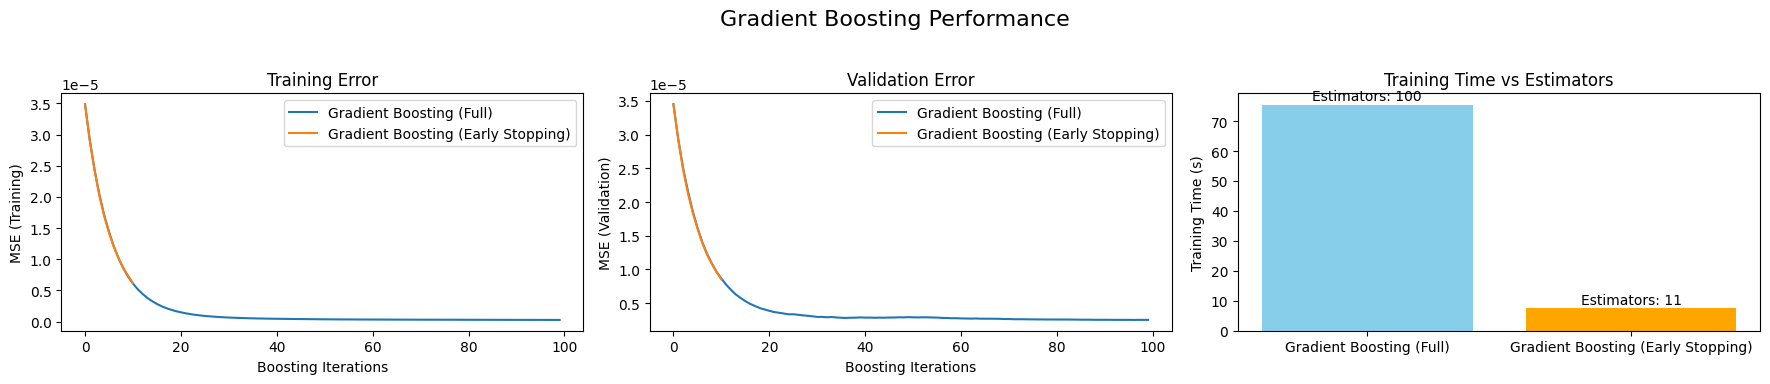

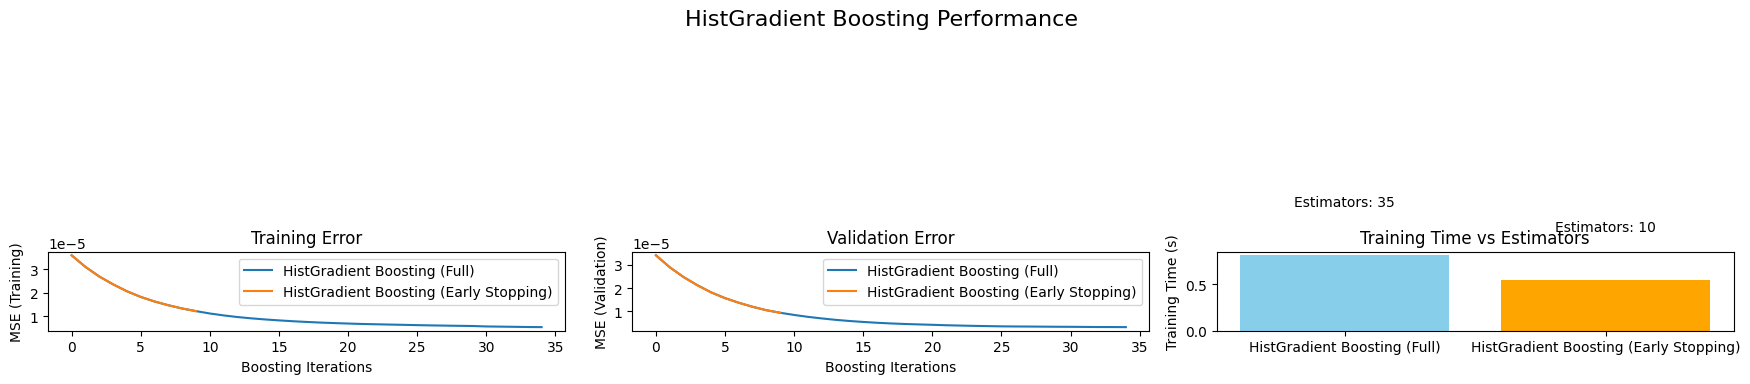

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


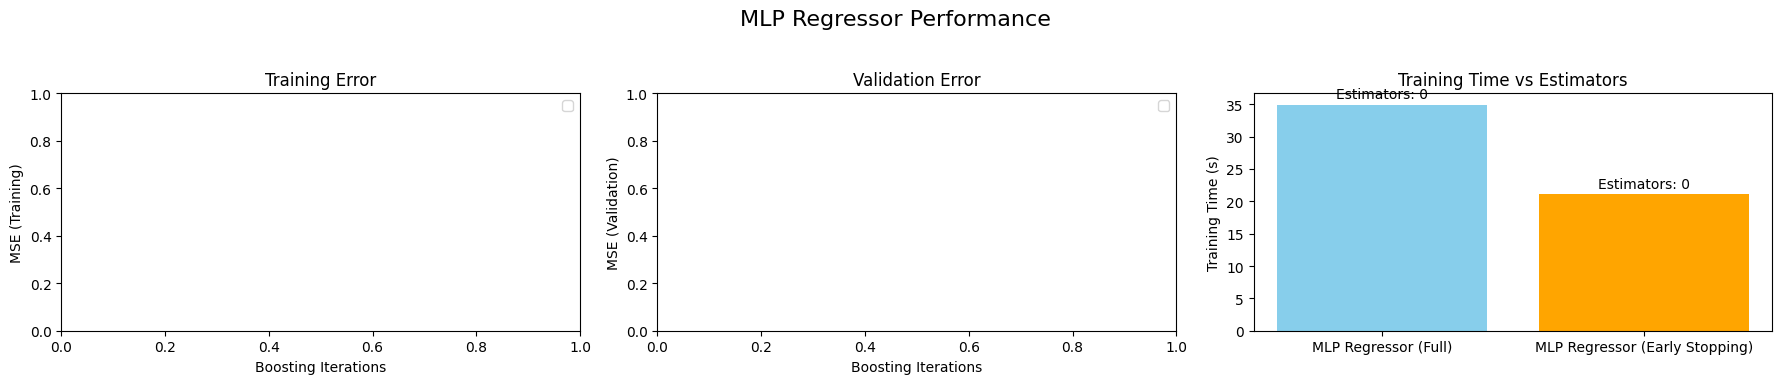

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


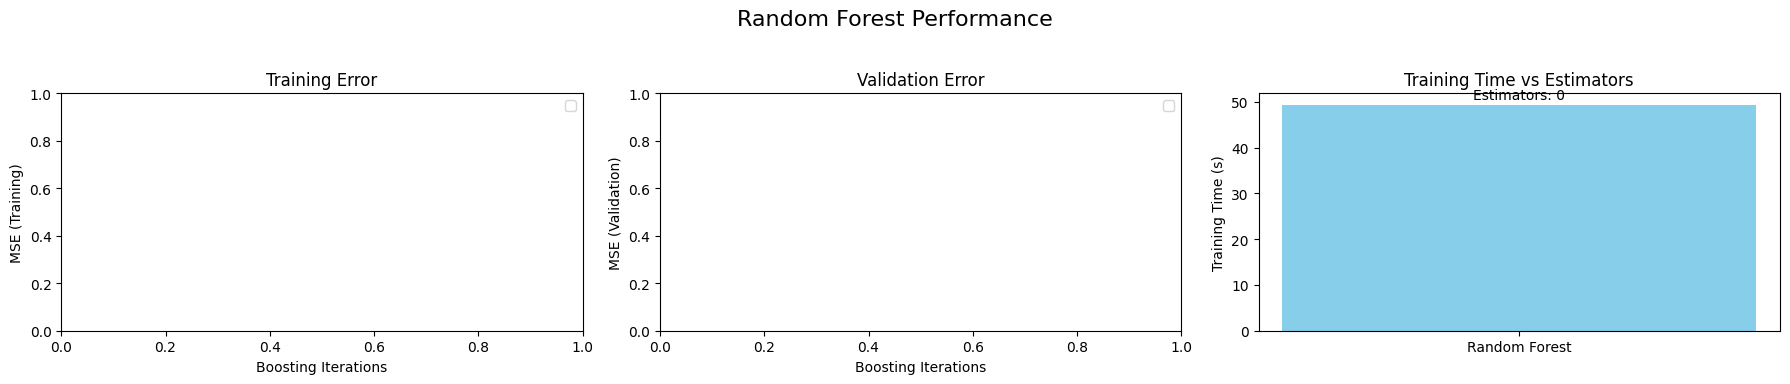

es_sales_train_results:


,mean_absolute_error,r2_score,mean_squared_error
Random Forest,0.000034,0.988365,4.582850e-07
Gradient Boosting (Full),0.000151,0.993471,2.712949e-07
Gradient Boosting (Early Stopping),0.001112,0.643056,6.191502e-06
HistGradient Boosting (Full),0.000279,0.837633,5.269214e-06
HistGradient Boosting (Early Stopping),0.001182,0.088479,1.210936e-05
MLP Regressor (Full),0.001303,0.670282,1.011998e-05
MLP Regressor (Early Stopping),0.001235,0.647301,1.057186e-05


In [57]:

# plt.rcParams["figure.figsize"]=(enter your fig width, enter your fig height)

# Visualize training errors for rentals
visualizations.visualize_training_errors_by_algorithm(
    staged_predictions=es_sales_staged_predictions, 
    y_train=es_sales_y_train, 
    y_val=es_sales_y_val,
    training_times=es_sales_training_times,
    n_estimators=es_sales_n_estimators,
    figsize=(18, 4),
    colors=None,
    title_fontsize=16,
    pad = 0,
    h_pad = 0.03,
    w_pad = 1,
    rect = 0.95, 
    )

print("es_sales_train_results:")
es_sales_train_results



In [58]:
print("es_sales_test_results:")
es_sales_results['test_scores_df']

es_sales_test_results:


,mean_absolute_error,r2_score,mean_squared_error
Random Forest,0.000090,0.962830,0.000001
Gradient Boosting (Full),0.000169,0.966512,0.000001
Gradient Boosting (Early Stopping),0.001106,0.532902,0.000006
HistGradient Boosting (Full),0.000280,0.819311,0.000005
HistGradient Boosting (Early Stopping),0.001173,0.130687,0.000010
MLP Regressor (Full),0.001306,0.632104,0.000010
MLP Regressor (Early Stopping),0.001233,0.607536,0.000010


In [59]:
print("es_sales_val_results:")
es_sales_results['val_scores_df']

es_sales_val_results:


,mean_absolute_error,r2_score,mean_squared_error
Random Forest,0.000099,0.936936,0.000002
Gradient Boosting (Full),0.000179,0.928208,0.000003
Gradient Boosting (Early Stopping),0.001134,0.400507,0.000009
HistGradient Boosting (Full),0.000291,0.902846,0.000003
HistGradient Boosting (Early Stopping),0.001197,0.302001,0.000009
MLP Regressor (Full),0.001325,0.482843,0.000012
MLP Regressor (Early Stopping),0.001257,0.444912,0.000013


In [60]:
es_sales_n_estimators

({'Random Forest': 0,
  'Gradient Boosting (Full)': 100,
  'Gradient Boosting (Early Stopping)': 11,
  'HistGradient Boosting (Full)': 35,
  'HistGradient Boosting (Early Stopping)': 10,
  'MLP Regressor (Full)': 0,
  'MLP Regressor (Early Stopping)': 0},)

##### 5.2.2  Sales Data Imputed

In [61]:
imputed_sales_df = imputed_sales_df[[
  'Parking', 'Property Size (sq.m)', 'No. of Buyer', 'No. of Seller','Number of Rooms',
       'Transaction Size (sq.m)', 'Sale Price', 'Usage',
       'Property Sub Type', 'Room(s)', 'Nearest Metro', 'Nearest Mall','Avg Price Last Week',
       'Nearest Landmark','Is Free Hold?', 'Area','Avg Price Last Month', 
      ]].dropna(how='any')
print("shape:", imputed_sales_df.shape)
print(imputed_sales_df.isnull().sum().sum())

print(imputed_sales_df.columns)

shape: (591319, 17)
0
Index(['Parking', 'Property Size (sq.m)', 'No. of Buyer', 'No. of Seller',
       'Number of Rooms', 'Transaction Size (sq.m)', 'Sale Price', 'Usage',
       'Property Sub Type', 'Room(s)', 'Nearest Metro', 'Nearest Mall',
       'Avg Price Last Week', 'Nearest Landmark', 'Is Free Hold?', 'Area',
       'Avg Price Last Month'],
      dtype='object')


In [62]:
cat_columns = imputed_sales_df.select_dtypes(include=['object', 'category']).columns.tolist()
num_columns =   imputed_sales_df.select_dtypes(include=[np.number]).columns

# # Encode categorical features
imputed_sales_df = data_processor.oe_encode_categorical_features(imputed_sales_df.copy(), cat_columns)
imputed_sales_df.head(2)
imputed_sales_df.isnull().sum().sum()


imputed_sales_df[num_columns].corr(method='pearson')['Sale Price'].sort_values(ascending=False).to_frame().T

,Sale Price,Transaction Size (sq.m),Parking,Property Size (sq.m),Number of Rooms,Avg Price Last Week,Avg Price Last Month,No. of Seller,No. of Buyer
Sale Price,1.0,0.08271,0.076305,0.071264,0.028022,0.002405,0.000468,0.000259,-0.001786


- very weak relationships
- lets see the model though

In [63]:
# print(imputed_sales_df.isnull().sum().sum())
# print(imputed_sales_df.shape)
# imputed_sales_df.head(2)

In [64]:
imputed_sales_output_dir = "../models/checkpoints/imputed_data/intial/sale"  
imputed_sales_target_col = "Sale Price" 

# es_sale_train_scores_df, es_sale_val_scores_df, es_sale_test_scores_df, es_sale_staged_predictions = \
imputed_es_sales_results = model_specifics.train_model_pipelines_with_early_stopping(
    df=imputed_sales_df,
    target=imputed_sales_target_col,
    models=models,
    scale=True,
    category='Sales',
    shuffle=True,
    output_dir=imputed_sales_output_dir
 )



Evaluating Sales Models:   0%|          | 0/7 [00:00<?, ?it/s]


Training Random Forest...


Evaluating Sales Models:  14%|█▍        | 1/7 [01:55<11:30, 115.01s/it]


Training Gradient Boosting (Full)...


Evaluating Sales Models:  29%|██▊       | 2/7 [04:33<11:41, 140.36s/it]


Training Gradient Boosting (Early Stopping)...


Evaluating Sales Models:  43%|████▎     | 3/7 [04:53<05:42, 85.54s/it] 


Training HistGradient Boosting (Full)...


Evaluating Sales Models:  57%|█████▋    | 4/7 [04:58<02:41, 53.73s/it]


Training HistGradient Boosting (Early Stopping)...


Evaluating Sales Models:  71%|███████▏  | 5/7 [04:59<01:09, 34.70s/it]


Training MLP Regressor (Full)...


Evaluating Sales Models:  86%|████████▌ | 6/7 [05:46<00:38, 38.96s/it]


Training MLP Regressor (Early Stopping)...


Evaluating Sales Models: 100%|██████████| 7/7 [07:10<00:00, 61.48s/it]


In [65]:
imputed_es_sales_train_results =   imputed_es_sales_results['train_scores_df']
imputed_es_sales_staged_predictions = imputed_es_sales_results["staged_predictions"]
imputed_es_sales_y_train =         imputed_es_sales_results["y_train"]
imputed_es_sales_y_test =          imputed_es_sales_results["y_test"]
imputed_es_sales_y_val =           imputed_es_sales_results["y_val"]
imputed_es_sales_x_train =         imputed_es_sales_results["x_train"]
imputed_es_sales_x_test =          imputed_es_sales_results["x_test"]
imputed_es_sales_x_val =           imputed_es_sales_results["x_val"]
imputed_es_sales_training_times=   imputed_es_sales_results["training_times"],
imputed_es_sales_n_estimators=     imputed_es_sales_results["n_estimators"],
imputed_es_sales_n_predictors=     imputed_es_sales_results["predictors"],

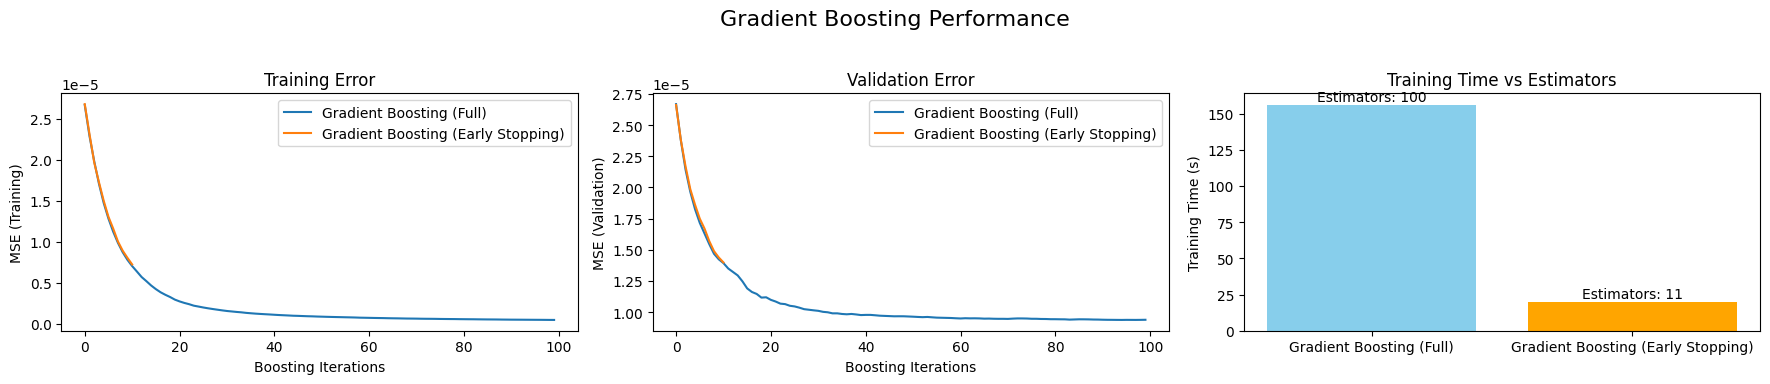

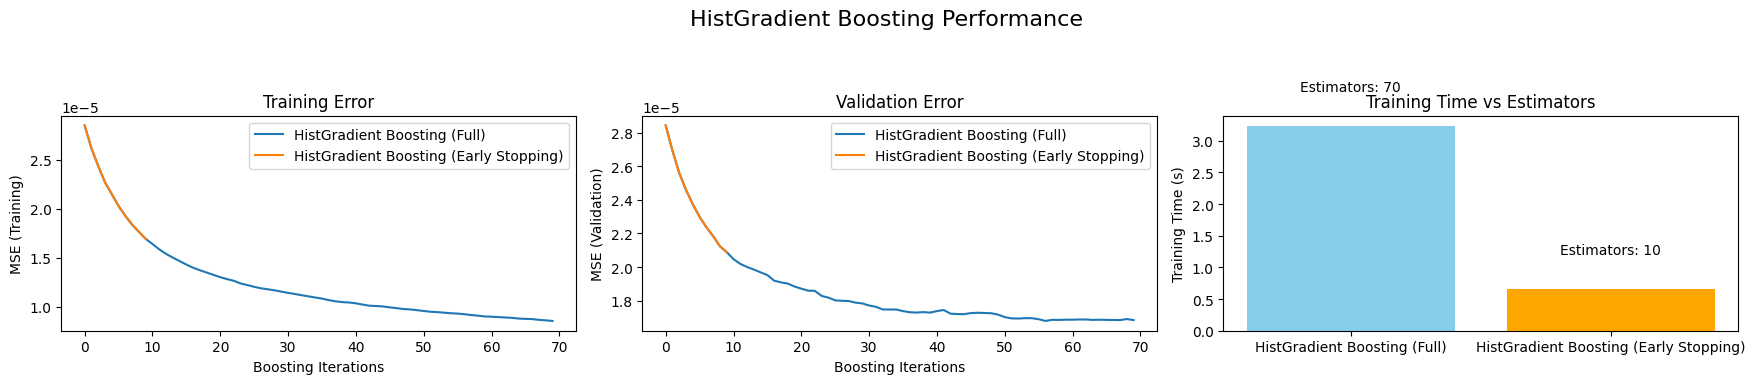

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


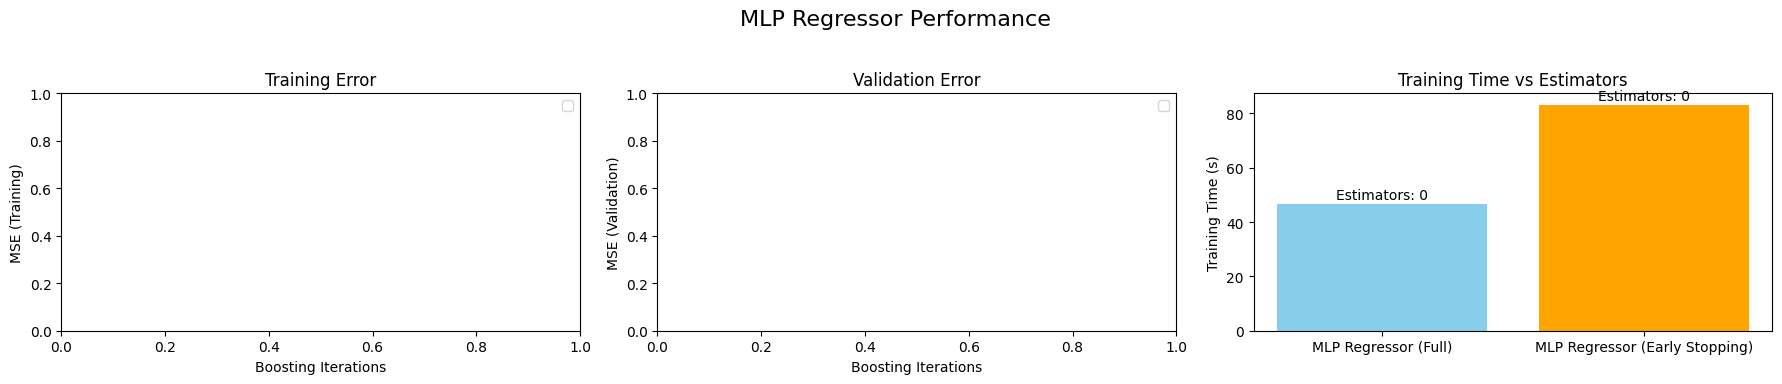

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


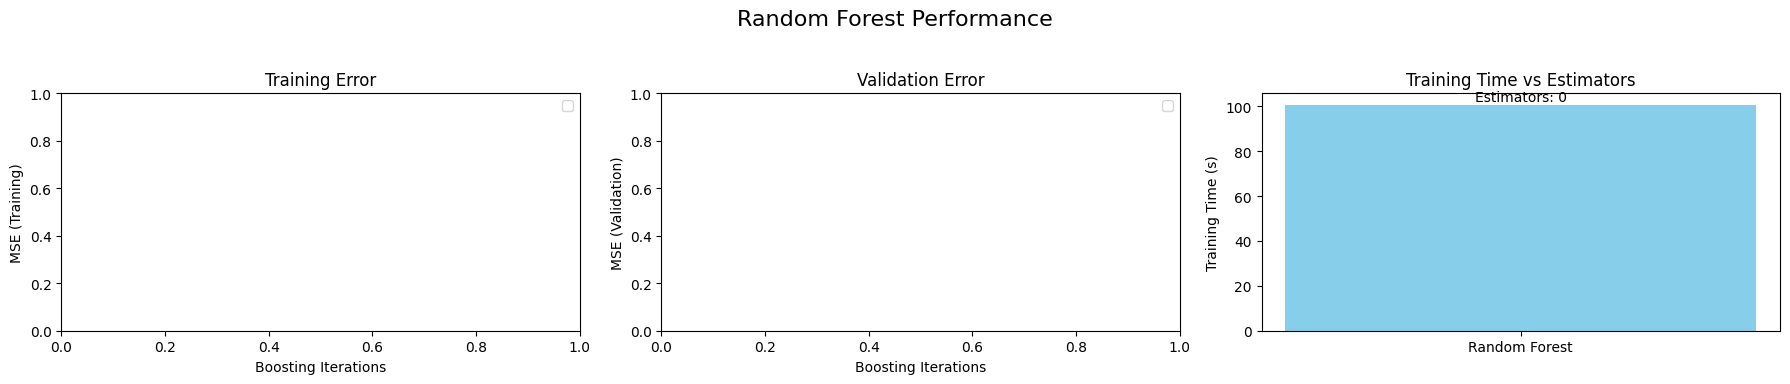

In [66]:
# Visualize training errors for rentals
visualizations.visualize_training_errors_by_algorithm(
    staged_predictions=imputed_es_sales_staged_predictions, 
    y_train=imputed_es_sales_y_train, 
    y_val=imputed_es_sales_y_val,
    training_times=imputed_es_sales_training_times,
    n_estimators=imputed_es_sales_n_estimators,
    figsize=(18, 4),
    colors=None,
    title_fontsize=16,
    pad = 0,
    h_pad = 0.03,
    w_pad = 1,
    rect = 0.95, 
    )

In [67]:
print("es_sales_train_results:")
imputed_es_sales_train_results

es_sales_train_results:


,mean_absolute_error,r2_score,mean_squared_error
Random Forest,0.000038,0.962602,9.861018e-07
Gradient Boosting (Full),0.000245,0.984836,4.497519e-07
Gradient Boosting (Early Stopping),0.000677,0.312197,7.213445e-06
HistGradient Boosting (Full),0.000327,0.496213,8.575016e-06
HistGradient Boosting (Early Stopping),0.000731,-2.054164,1.693896e-05
MLP Regressor (Full),0.001229,-12.553987,2.958861e-05
MLP Regressor (Early Stopping),0.001142,-12.088735,2.844048e-05


#### 5.3 Training Rentals Transaction Models

In [68]:
# targeted_rentals_df['annual_rental_prices(aed)']

In [70]:
targeted_rentals_df.drop(columns="year", inplace=True)

In [71]:
rentals_output_dir = "../models/checkpoints/intial/rentals"  
target_rentals_col = "annual_rental_prices(aed)" 
rentals_train_scores_df, rentals_val_scores_df, rentals_test_scores_df = \
model_specifics.train_model_pipelines(
    df=targeted_rentals_df,
    target=target_rentals_col,
    scale=True,
    shuffle=True,
    output_dir=rentals_output_dir
)  

Evaluating Models:   0%|          | 0/2 [00:00<?, ?it/s]


Training Linear Model model...


Evaluating Models:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s]


Training Decision Tree model...


Evaluating Models: 100%|██████████| 2/2 [00:06<00:00,  3.07s/it]


- rentals early stopping vs full

In [72]:

rentals_output_dir = "../models/checkpoints/intial/rentals"  
target_rentals_col = "annual_rental_prices(aed)" 

# es_rentals_train_scores_df, es_rentals_val_scores_df, es_rentals_test_scores_df, es_rentals_staged_predictions = \
es_rentals_results =  model_specifics.train_model_pipelines_with_early_stopping(
    df=targeted_rentals_df,
    target=target_rentals_col,
    models=models,
    scale=True,
    category='Rentals',
    shuffle=True,
    output_dir=rentals_output_dir
 )


Evaluating Rentals Models:   0%|          | 0/7 [00:00<?, ?it/s]


Training Random Forest...


Evaluating Rentals Models:  14%|█▍        | 1/7 [01:52<11:14, 112.50s/it]


Training Gradient Boosting (Full)...


Evaluating Rentals Models:  29%|██▊       | 2/7 [04:07<10:28, 125.72s/it]


Training Gradient Boosting (Early Stopping)...


Evaluating Rentals Models:  43%|████▎     | 3/7 [04:21<04:58, 74.69s/it] 


Training HistGradient Boosting (Full)...


Evaluating Rentals Models:  57%|█████▋    | 4/7 [04:23<02:17, 45.93s/it]


Training HistGradient Boosting (Early Stopping)...


Evaluating Rentals Models:  71%|███████▏  | 5/7 [04:24<00:59, 29.69s/it]


Training MLP Regressor (Full)...


Evaluating Rentals Models:  86%|████████▌ | 6/7 [05:03<00:33, 33.03s/it]


Training MLP Regressor (Early Stopping)...


Evaluating Rentals Models: 100%|██████████| 7/7 [06:44<00:00, 57.74s/it]


In [70]:
es_rentals_results.keys()

dict_keys(['x_train', 'x_val', 'x_test', 'y_train', 'y_val', 'y_test', 'predictors', 'train_scores_df', 'val_scores_df', 'test_scores_df', 'staged_predictions', 'training_times', 'n_estimators'])

In [ ]:
# es_rentals_results['']

In [73]:
# Extract required values from results sales
es_rentals_train_results = es_rentals_results['train_scores_df']
es_rentals_staged_predictions = es_rentals_results["staged_predictions"]
es_rentals_y_train = es_rentals_results["y_train"]
es_rentals_y_test = es_rentals_results["y_test"]
es_rentals_y_val = es_rentals_results["y_val"]
es_rentals_x_train = es_rentals_results["x_train"]
es_rentals_x_test = es_rentals_results["x_test"]
es_rentals_x_val = es_rentals_results["x_val"]
es_rentals_training_times=es_rentals_results["training_times"],
es_rentals_n_estimators=es_rentals_results["n_estimators"],
es_rentals_n_predictors=es_rentals_results["predictors"],



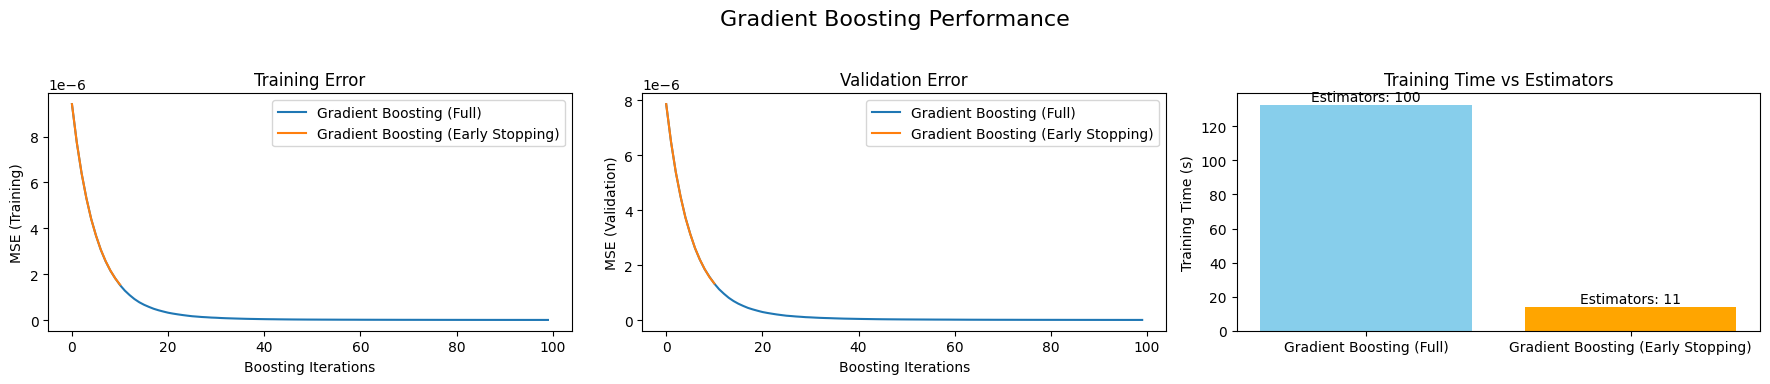

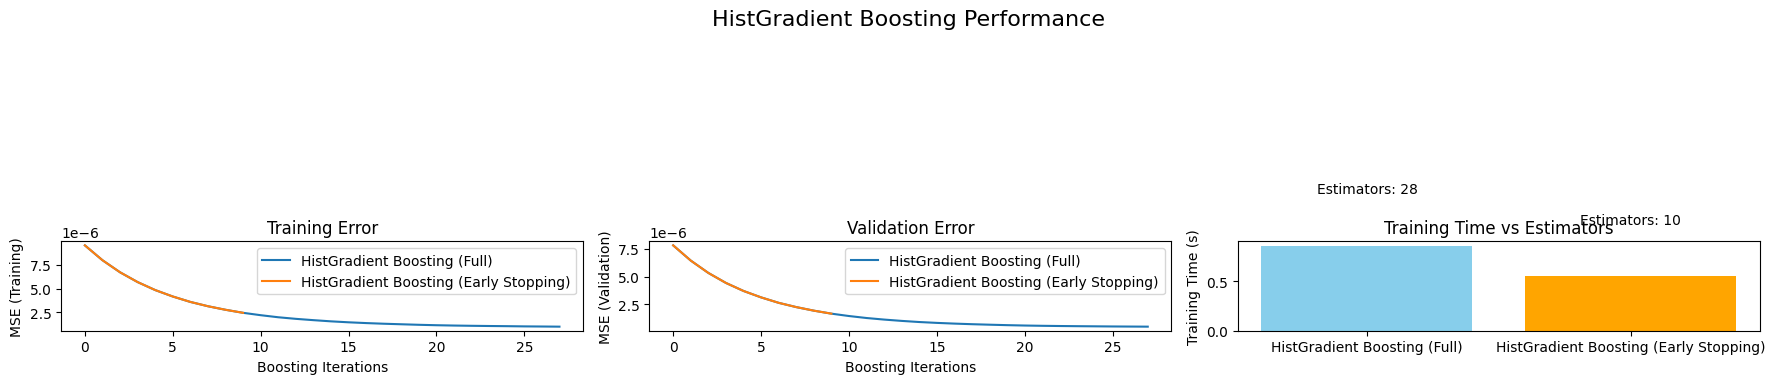

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


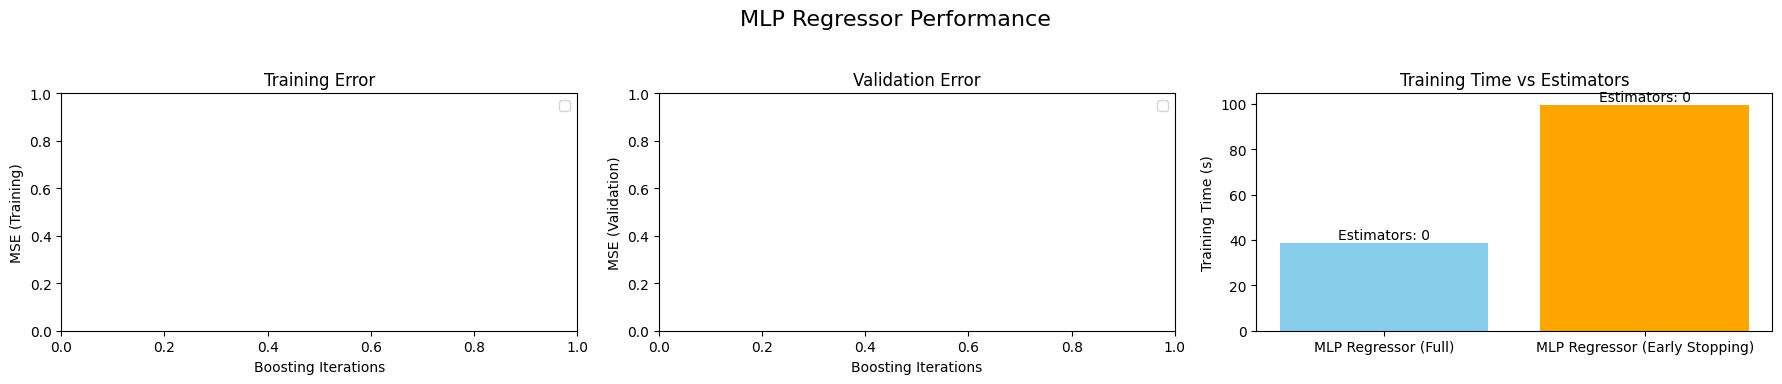

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


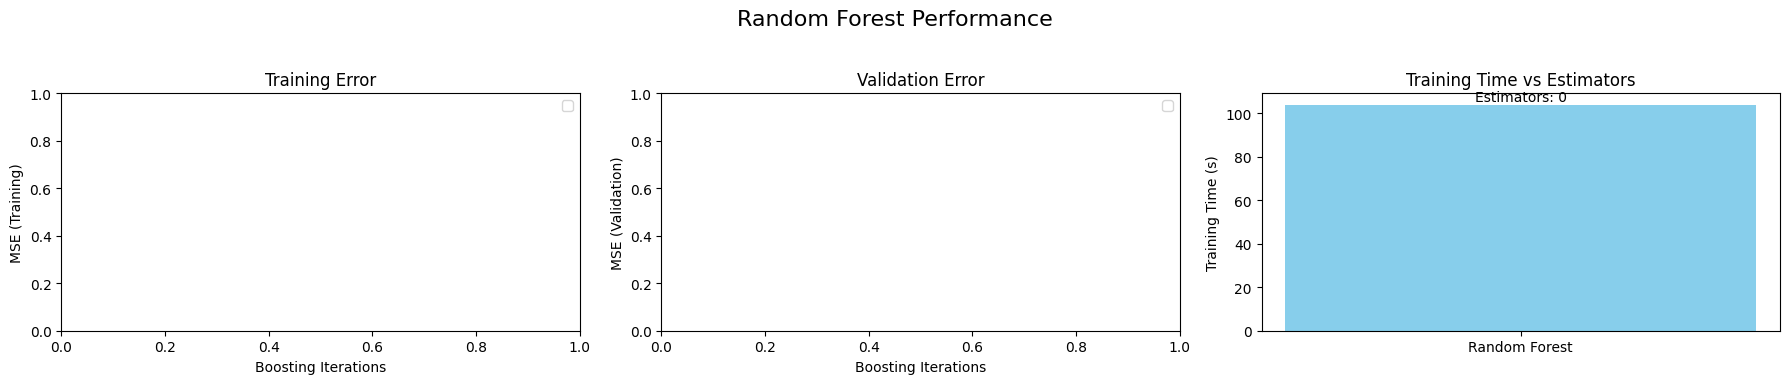

es_rentals_train_results:


,mean_absolute_error,r2_score,mean_squared_error
Random Forest,0.000002,0.990428,1.036023e-07
Gradient Boosting (Full),0.000027,0.999356,7.362136e-09
Gradient Boosting (Early Stopping),0.000371,0.689011,1.547186e-06
HistGradient Boosting (Full),0.000105,0.890812,9.935350e-07
HistGradient Boosting (Early Stopping),0.000385,0.418409,2.446985e-06
MLP Regressor (Full),0.001394,-0.758339,7.309417e-06
MLP Regressor (Early Stopping),0.000561,-0.419710,6.079707e-06


In [74]:
# Visualize training errors for rentals


visualizations.visualize_training_errors_by_algorithm(
    es_rentals_staged_predictions,
    es_rentals_y_train, 
    es_rentals_y_val,
    training_times=es_rentals_training_times,
    n_estimators=es_rentals_n_estimators,
    figsize=(18, 4),
    colors=None,
    title_fontsize=16,
    pad = 0,
    h_pad = 0.03,
    w_pad = 1,
    rect = 0.95,
    
    )

print("es_rentals_train_results:")
es_rentals_train_results


In [75]:
es_rentals_results['test_scores_df']

,mean_absolute_error,r2_score,mean_squared_error
Random Forest,0.000012,0.246579,0.000008
Gradient Boosting (Full),0.000037,0.329109,0.000007
Gradient Boosting (Early Stopping),0.000385,-1.243452,0.000010
HistGradient Boosting (Full),0.000116,0.090710,0.000009
HistGradient Boosting (Early Stopping),0.000398,-1.248293,0.000010
MLP Regressor (Full),0.001407,-2.170591,0.000015
MLP Regressor (Early Stopping),0.000574,-1.759434,0.000014


In [76]:
es_rentals_results['val_scores_df']

,mean_absolute_error,r2_score,mean_squared_error
Random Forest,0.000003,0.998124,1.768159e-08
Gradient Boosting (Full),0.000028,0.998363,1.550808e-08
Gradient Boosting (Early Stopping),0.000373,0.669440,1.343891e-06
HistGradient Boosting (Full),0.000104,0.941478,4.772171e-07
HistGradient Boosting (Early Stopping),0.000387,0.564932,1.652677e-06
MLP Regressor (Full),0.001384,-0.274332,5.273215e-06
MLP Regressor (Early Stopping),0.000554,0.039596,4.088686e-06


#### 5.4 Training Macro + Sales Transaction Models

In [77]:
sales_macro_df.isnull().sum().sum()

0

In [78]:
sales_macro_df['sales_price(aed)'].unique()

array([ 425993., 1900000., 3500000., ...,  966476., 1262141., 1656423.])

In [100]:
# sales_macro_df.drop(columns=["Year","year","Value","Short Indicator Name"], inplace=True)

In [79]:

cat_columns =   sales_macro_df.select_dtypes(include=['object', 'category']).columns.tolist()
num_columns =   sales_macro_df.select_dtypes(include=[np.number]).columns

sales_macro_df[num_columns].corr(method='pearson')['sales_price(aed)'].sort_values(ascending=False).to_frame()

,sales_price(aed)
sales_price(aed),1.000000
property_area(sq.m),0.615879
price_per_sqm,0.362676
number_of_rooms,0.346689
avg_price_last_month,0.316631
avg_price_last_week,0.313344
property_sub_type,0.082902
total_population_male,0.064137
total_population,0.063457
total_population_others,0.063457


In [80]:
sales_macro_df.isnull().sum().sum()

0

In [ ]:
# sales_macro_model_df = sales_macro_model_df[[
#   'Parking', 'Property Size (sq.m)', 'No. of Buyer', 'No. of Seller','Number of Rooms',
#        'Transaction Size (sq.m)', 'Sale Price', 'Usage',
#        'Property Sub Type', 'Room(s)', 'Nearest Metro', 'Nearest Mall','Avg Price Last Week',
#        'Nearest Landmark','Is Free Hold?', 'Area','Avg Price Last Month', 
#       ]].dropna(how='any')
# print("shape:", imputed_sales_df.shape)
# print(imputed_sales_df.isnull().sum().sum())

# print(imputed_sales_df.columns)

In [81]:
cat_columns =   sales_macro_df.select_dtypes(include=['object', 'category']).columns.tolist()
# sales_macro_model_df = data_processor.oe_encode_categorical_features(sales_macro_model_df.copy(), cat_columns)
sales_macro_df.isnull().sum().sum()

0

In [82]:
sales_macro_df.columns

Index(['property_area(sq.m)', 'property_location', 'avg_price_last_week',
       'number_of_rooms', 'property_layout', 'sales_price(aed)',
       'property_type', 'price_per_sqm', 'avg_price_last_month',
       'property_sub_type', 'nearest_metro', 'nearest_mall',
       'nearest_landmark', 'usage', 'year', 'Year', 'avg_GDP_constant',
       'avg_GDP_current', 'total_population', 'total_population_female',
       'total_population_male', 'total_population_others',
       'total_tourism_guests', 'avg_monthly_cpi', 'avg_currency_strength',
       'avg_GDP_per_capita', 'total_tourism_revenue_per_capita',
       'total_population_growth_rate', 'total_tourism_growth_rate'],
      dtype='object')

In [83]:
# sales_macro_model_df.info()
selected_features_sales = [
    "sales_price(aed)",
    "property_area(sq.m)",
    "price_per_sqm",
    "number_of_rooms",
    "avg_price_last_month",
    "avg_price_last_week",
    "property_sub_type",
    "total_population_male",
    "total_population_female",
    "nearest_mall",
    "usage",
    "nearest_metro",
    "nearest_landmark",
    "total_population",
    "total_tourism_guests",
    "total_tourism_revenue_per_capita",
    "total_tourism_growth_rate",
    "avg_monthly_cpi"
]

sales_macro_df = sales_macro_df[selected_features_sales]
sales_macro_df.columns

Index(['sales_price(aed)', 'property_area(sq.m)', 'price_per_sqm',
       'number_of_rooms', 'avg_price_last_month', 'avg_price_last_week',
       'property_sub_type', 'total_population_male', 'total_population_female',
       'nearest_mall', 'usage', 'nearest_metro', 'nearest_landmark',
       'total_population', 'total_tourism_guests',
       'total_tourism_revenue_per_capita', 'total_tourism_growth_rate',
       'avg_monthly_cpi'],
      dtype='object')

Evaluating Sales Models:   0%|          | 0/7 [00:00<?, ?it/s]


Training Random Forest...


Evaluating Sales Models:  14%|█▍        | 1/7 [01:10<07:01, 70.29s/it]


Training Gradient Boosting (Full)...


Evaluating Sales Models:  29%|██▊       | 2/7 [02:38<06:45, 81.04s/it]


Training Gradient Boosting (Early Stopping)...


Evaluating Sales Models:  43%|████▎     | 3/7 [02:50<03:16, 49.24s/it]


Training HistGradient Boosting (Full)...


Evaluating Sales Models:  57%|█████▋    | 4/7 [02:52<01:32, 30.81s/it]


Training HistGradient Boosting (Early Stopping)...


Evaluating Sales Models:  71%|███████▏  | 5/7 [02:53<00:40, 20.01s/it]


Training MLP Regressor (Full)...


Evaluating Sales Models:  86%|████████▌ | 6/7 [03:25<00:24, 24.15s/it]


Training MLP Regressor (Early Stopping)...


Evaluating Sales Models: 100%|██████████| 7/7 [05:27<00:00, 46.83s/it]


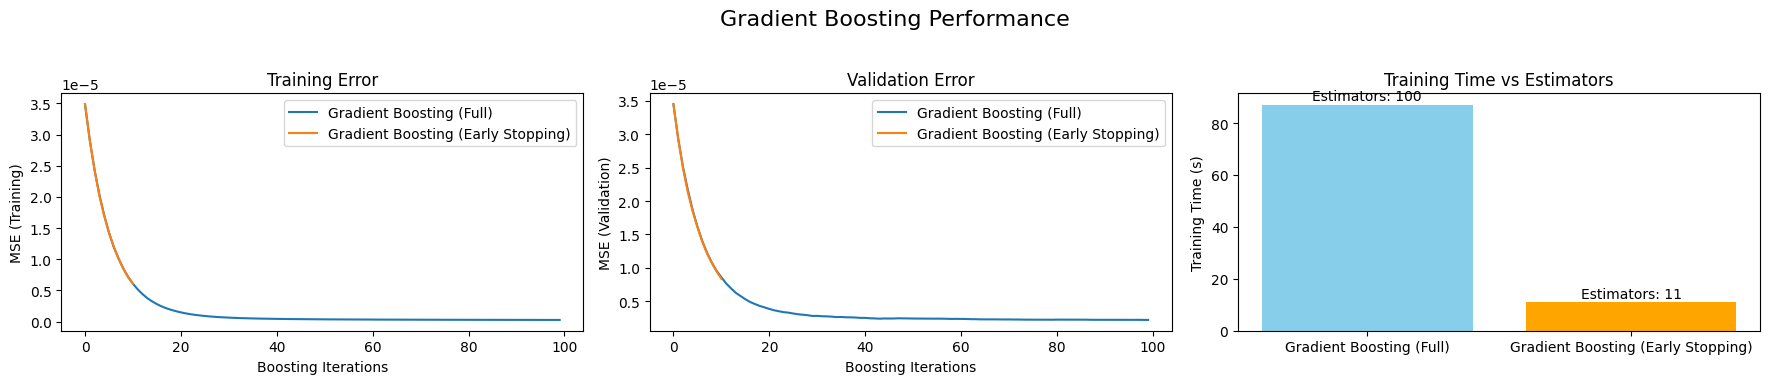

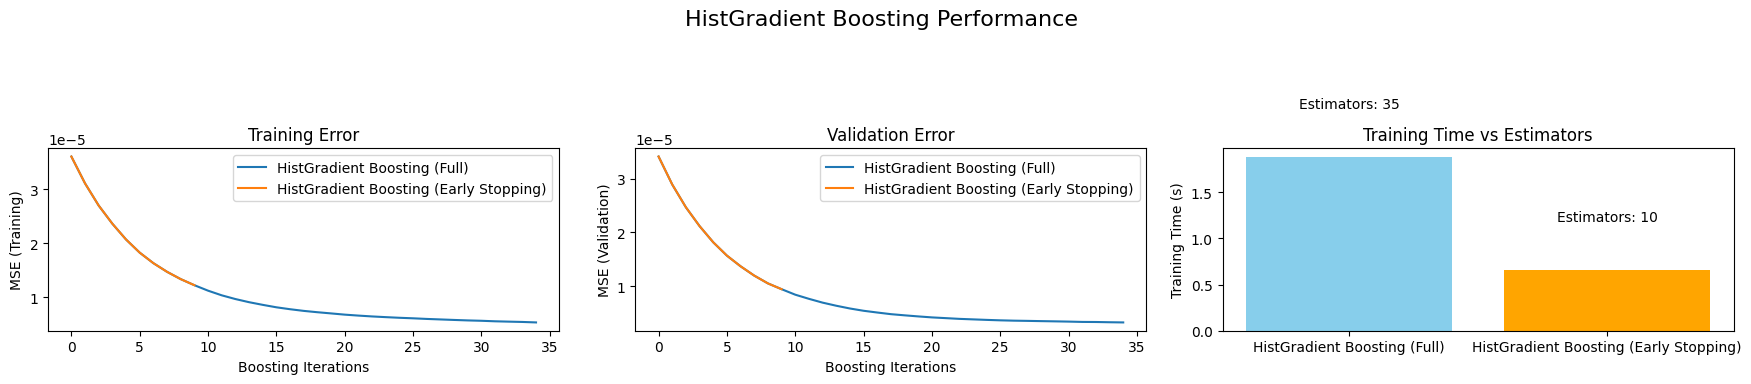

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


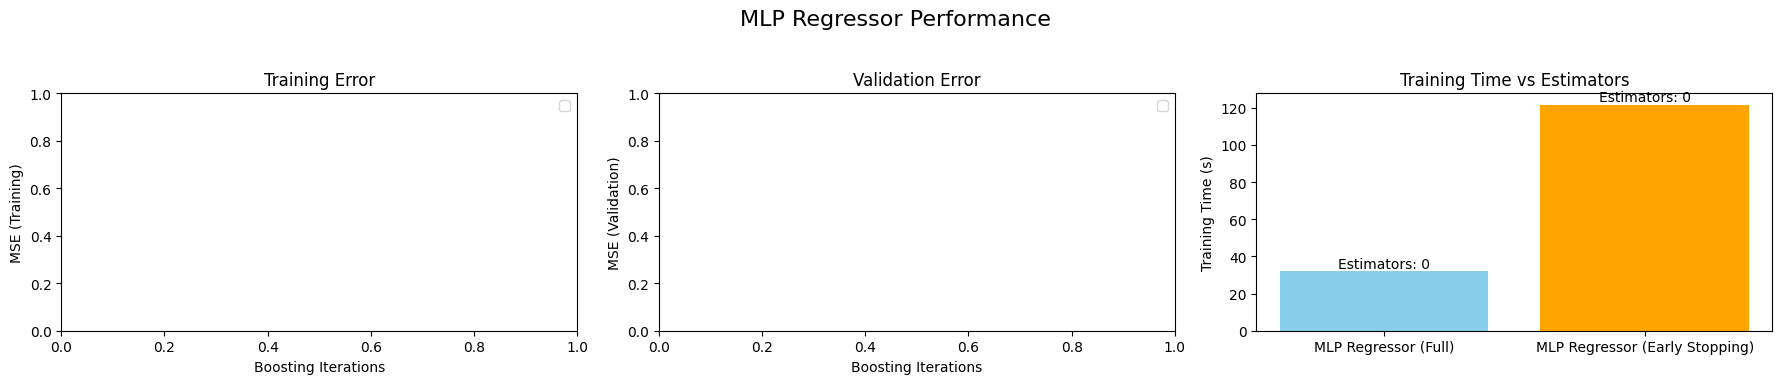

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


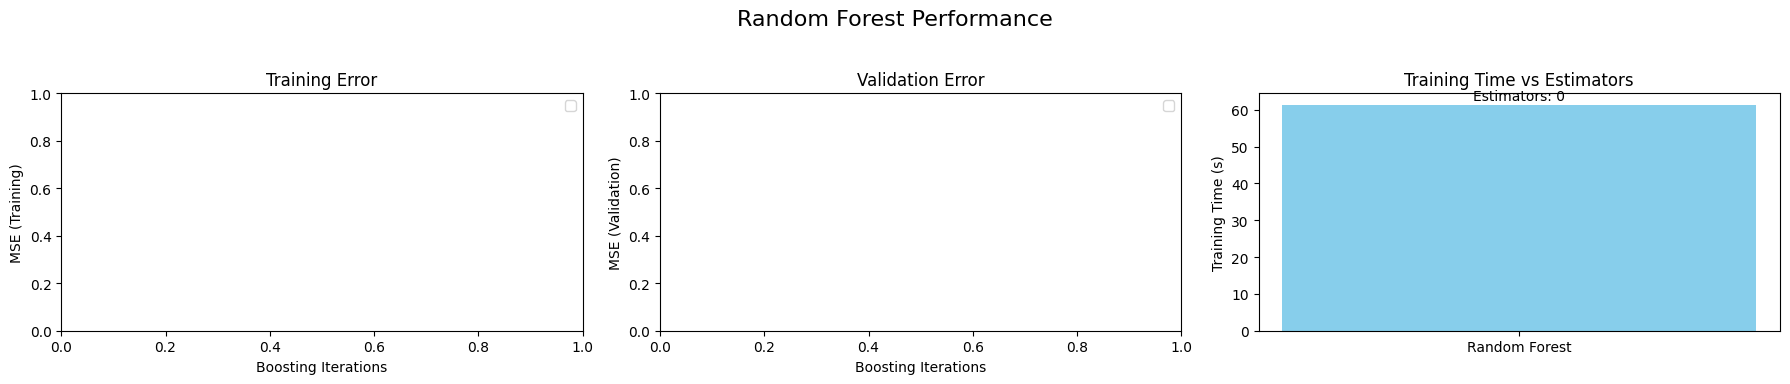

es_full_macro_sales_train_results:


,mean_absolute_error,r2_score,mean_squared_error
Random Forest,0.000035,0.987106,5.059136e-07
Gradient Boosting (Full),0.000152,0.993467,2.716657e-07
Gradient Boosting (Early Stopping),0.001110,0.650608,6.090430e-06
HistGradient Boosting (Full),0.000280,0.834673,5.339253e-06
HistGradient Boosting (Early Stopping),0.001186,0.077020,1.222070e-05
MLP Regressor (Full),0.001423,0.632434,1.134087e-05
MLP Regressor (Early Stopping),0.001339,0.600977,1.075165e-05


In [84]:
# Visualize training errors for rentals

macro_sales_output_dir = "../models/checkpoints/intial/sale/macro/full"  
target_macro_sales_col = "sales_price(aed)" 

# es_rentals_train_scores_df, es_rentals_val_scores_df, es_rentals_test_scores_df, es_rentals_staged_predictions = \
es_full_macro_sales_results =  model_specifics.train_model_pipelines_with_early_stopping(
    df=sales_macro_df,
    target=target_macro_sales_col,
    models=models,
    scale=True,
    category='Sales',
    shuffle=True,
    output_dir=macro_sales_output_dir
 )


# Extract required values from results sales
es_full_macro_sales_train_results =      es_full_macro_sales_results['train_scores_df']
es_full_macro_sales_staged_predictions = es_full_macro_sales_results["staged_predictions"]
es_full_macro_sales_y_train =            es_full_macro_sales_results["y_train"]
es_full_macro_sales_y_test =             es_full_macro_sales_results["y_test"]
es_full_macro_sales_y_val =              es_full_macro_sales_results["y_val"]
es_full_macro_sales_x_train =            es_full_macro_sales_results["x_train"]
es_full_macro_sales_x_test =             es_full_macro_sales_results["x_test"]
es_full_macro_sales_x_val =              es_full_macro_sales_results["x_val"]
es_full_macro_sales_training_times=      es_full_macro_sales_results["training_times"],
es_full_macro_sales_n_estimators=        es_full_macro_sales_results["n_estimators"],
es_full_macro_sales_n_predictors=        es_full_macro_sales_results["predictors"],


visualizations.visualize_training_errors_by_algorithm(
    es_full_macro_sales_staged_predictions,
    es_full_macro_sales_y_train, 
    es_full_macro_sales_y_val,
    training_times=es_full_macro_sales_training_times,
    n_estimators=es_full_macro_sales_n_estimators,
    figsize=(18, 4),
    colors=None,
    title_fontsize=16,
    pad = 0,
    h_pad = 0.03,
    w_pad = 1,
    rect = 0.95,
    
    )

print("es_full_macro_sales_train_results:")
es_full_macro_sales_train_results


#### 5.5 Training Macro + Rentals Transaction Models

In [85]:
rental_macro_df.drop(columns=["Year","year"], inplace=True)
rental_macro_df.columns

Index(['property_area(sq.m)', 'property_location', 'avg_rent_last_week',
       'annual_rental_prices(aed)', 'property_type', 'rental_price_per_sqm',
       'avg_rent_last_month', 'property_sub_type', 'nearest_metro',
       'nearest_mall', 'nearest_landmark', 'usage', 'avg_GDP_constant',
       'avg_GDP_current', 'total_population', 'total_population_female',
       'total_population_male', 'total_population_others',
       'total_tourism_guests', 'avg_monthly_cpi', 'avg_currency_strength',
       'avg_GDP_per_capita', 'total_tourism_revenue_per_capita',
       'total_population_growth_rate', 'total_tourism_growth_rate'],
      dtype='object')

In [86]:

cat_columns =   rental_macro_df.select_dtypes(include=['object', 'category']).columns.tolist()
num_columns =   rental_macro_df.select_dtypes(include=[np.number]).columns

rental_macro_df[num_columns].corr(method='pearson')['annual_rental_prices(aed)'].sort_values(ascending=False).to_frame()

,annual_rental_prices(aed)
annual_rental_prices(aed),1.000000
avg_rent_last_week,0.476930
rental_price_per_sqm,0.463681
avg_rent_last_month,0.444025
property_area(sq.m),0.070199
avg_currency_strength,0.052109
total_tourism_revenue_per_capita,0.044238
usage,0.036451
total_tourism_guests,0.029880
property_sub_type,0.014542


Evaluating Rentals Models:   0%|          | 0/7 [00:00<?, ?it/s]


Training Random Forest...


Evaluating Rentals Models:  14%|█▍        | 1/7 [02:58<17:52, 178.78s/it]


Training Gradient Boosting (Full)...


Evaluating Rentals Models:  29%|██▊       | 2/7 [06:11<15:35, 187.18s/it]


Training Gradient Boosting (Early Stopping)...


Evaluating Rentals Models:  43%|████▎     | 3/7 [06:34<07:27, 111.86s/it]


Training HistGradient Boosting (Full)...


Evaluating Rentals Models:  57%|█████▋    | 4/7 [06:36<03:26, 68.77s/it] 


Training HistGradient Boosting (Early Stopping)...


Evaluating Rentals Models:  71%|███████▏  | 5/7 [06:37<01:28, 44.40s/it]


Training MLP Regressor (Full)...


Evaluating Rentals Models:  86%|████████▌ | 6/7 [07:50<00:53, 53.99s/it]


Training MLP Regressor (Early Stopping)...


Evaluating Rentals Models: 100%|██████████| 7/7 [10:32<00:00, 90.39s/it]


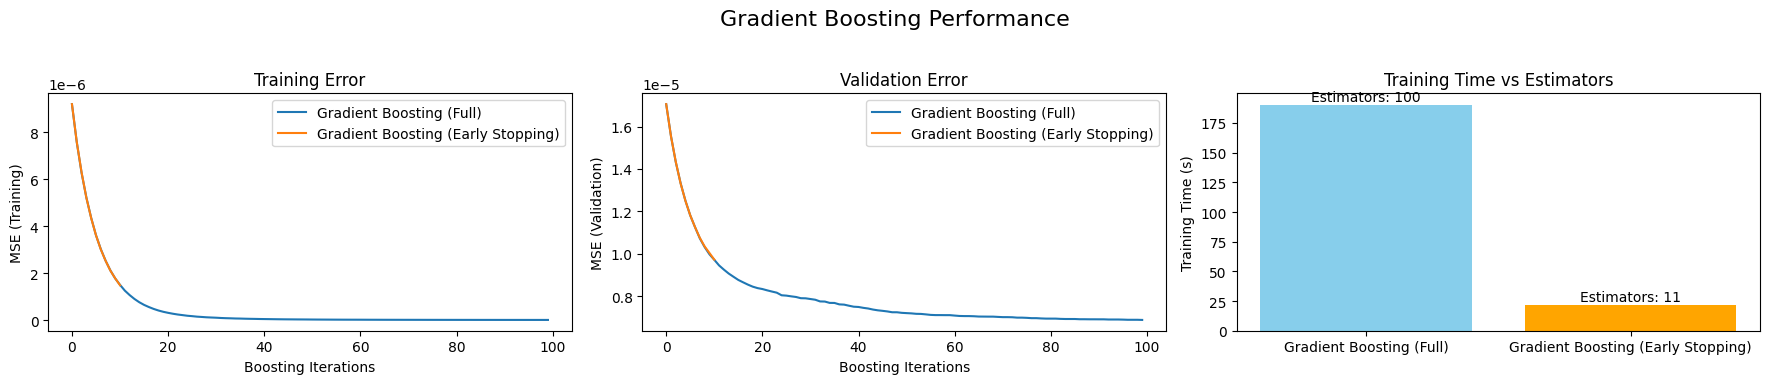

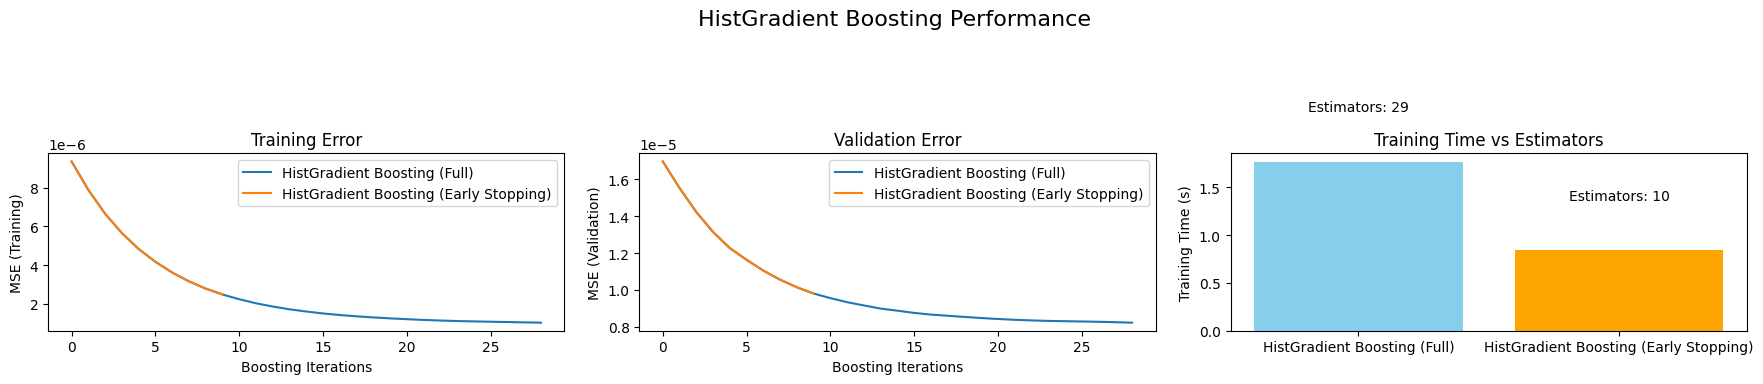

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


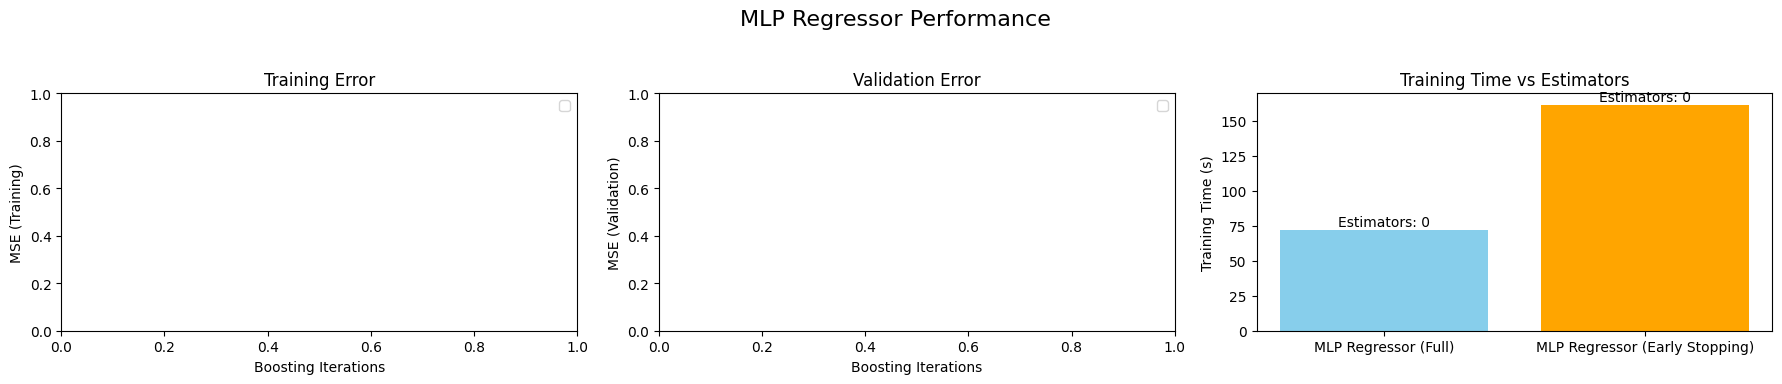

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


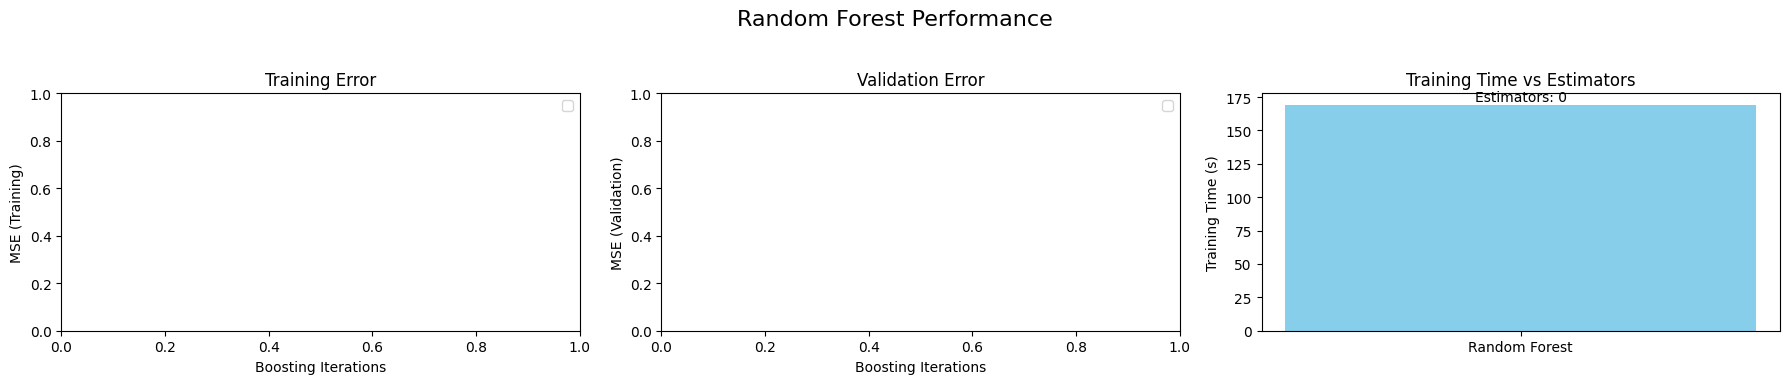

es_full_macro_rentals_train_results:


,mean_absolute_error,r2_score,mean_squared_error
Random Forest,0.000002,0.986515,1.417030e-07
Gradient Boosting (Full),0.000028,0.999302,7.783975e-09
Gradient Boosting (Early Stopping),0.000367,0.693726,1.487525e-06
HistGradient Boosting (Full),0.000101,0.884456,1.024261e-06
HistGradient Boosting (Early Stopping),0.000386,0.389618,2.479561e-06
MLP Regressor (Full),0.002698,-1.526154,1.286642e-05
MLP Regressor (Early Stopping),0.000962,-0.457307,6.068446e-06


In [89]:
# Visualize training errors for rentals

full_macro_rentals_output_dir = "../models/checkpoints/intial/rentals/macro/full"  
full_macro_target_rentals_col = "annual_rental_prices(aed)" 

# es_rentals_train_scores_df, es_rentals_val_scores_df, es_rentals_test_scores_df, es_rentals_staged_predictions = \
es_full_macro_rentals_results =  model_specifics.train_model_pipelines_with_early_stopping(
    df=rental_macro_df,
    target=full_macro_target_rentals_col,
    models=models,
    scale=True,
    category='Rentals',
    shuffle=True,
    output_dir=full_macro_rentals_output_dir
 )


# Extract required values from results sales
es_full_macro_rentals_train_results =      es_full_macro_rentals_results['train_scores_df']
es_full_macro_rentals_staged_predictions = es_full_macro_rentals_results["staged_predictions"]
es_full_macro_rentals_y_train =            es_full_macro_rentals_results["y_train"]
es_full_macro_rentals_y_test =             es_full_macro_rentals_results["y_test"]
es_full_macro_rentals_y_val =              es_full_macro_rentals_results["y_val"]
es_full_macro_rentals_x_train =            es_full_macro_rentals_results["x_train"]
es_full_macro_rentals_x_test =             es_full_macro_rentals_results["x_test"]
es_full_macro_rentals_x_val =              es_full_macro_rentals_results["x_val"]
es_full_macro_rentals_training_times=      es_full_macro_rentals_results["training_times"],
es_full_macro_rentals_n_estimators=        es_full_macro_rentals_results["n_estimators"],
es_full_macro_rentals_n_predictors=        es_full_macro_rentals_results["predictors"],


visualizations.visualize_training_errors_by_algorithm(
    es_full_macro_rentals_staged_predictions,
    es_full_macro_rentals_y_train, 
    es_full_macro_rentals_y_val,
    training_times=es_full_macro_rentals_training_times,
    n_estimators=es_full_macro_rentals_n_estimators,
    figsize=(18, 4),
    colors=None,
    title_fontsize=16,
    pad = 0,
    h_pad = 0.03,
    w_pad = 1,
    rect = 0.95,
    
    )

print("es_full_macro_rentals_train_results:")
es_full_macro_rentals_train_results


In [91]:
es_full_macro_rentals_results['test_scores_df']

,mean_absolute_error,r2_score,mean_squared_error
Random Forest,0.000005,0.985353,1.543484e-07
Gradient Boosting (Full),0.000030,0.993996,6.395255e-08
Gradient Boosting (Early Stopping),0.000371,0.655424,1.585603e-06
HistGradient Boosting (Full),0.000104,0.934997,5.970483e-07
HistGradient Boosting (Early Stopping),0.000391,0.503733,2.068083e-06
MLP Regressor (Full),0.002702,-1.496666,1.241362e-05
MLP Regressor (Early Stopping),0.000965,-0.368781,5.674594e-06


In [92]:
es_full_macro_rentals_results['val_scores_df']

,mean_absolute_error,r2_score,mean_squared_error
Random Forest,0.000012,0.268538,0.000008
Gradient Boosting (Full),0.000037,0.345814,0.000007
Gradient Boosting (Early Stopping),0.000372,-1.134412,0.000010
HistGradient Boosting (Full),0.000108,0.093910,0.000008
HistGradient Boosting (Early Stopping),0.000391,-1.328411,0.000010
MLP Regressor (Full),0.002697,-3.535208,0.000021
MLP Regressor (Early Stopping),0.000967,-2.585901,0.000014


### 6 Tuning All Models

#### 6.1 Tuning Sale Models

In [70]:
models

[('Random Forest', RandomForestRegressor(n_jobs=-1, random_state=42)),
 ('Gradient Boosting (Full)',
  GradientBoostingRegressor(max_depth=5, random_state=42)),
 ('Gradient Boosting (Early Stopping)',
  GradientBoostingRegressor(max_depth=5, n_iter_no_change=10, random_state=42)),
 ('HistGradient Boosting (Full)',
  HistGradientBoostingRegressor(random_state=42)),
 ('HistGradient Boosting (Early Stopping)',
  HistGradientBoostingRegressor(early_stopping=True, random_state=42, tol=0.0001)),
 ('MLP Regressor (Full)', MLPRegressor(random_state=42)),
 ('MLP Regressor (Early Stopping)',
  MLPRegressor(early_stopping=True, random_state=42))]

In [107]:
import warnings
from sklearn.exceptions import DataConversionWarning

from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import SGDRegressor

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from scipy.stats import ttest_rel, wilcoxon


def tune_models_with_comparison(models, param_grids, x_train, y_train, x_val, y_val, plot_learning_curve=True, search_type="grid", cv=5, scoring="neg_mean_squared_error", random_iter=10, output_dir=None, category=None):
    """
    Tune models using GridSearchCV or RandomizedSearchCV and perform statistical comparisons.

    Args:
        models (dict): Dictionary of models with names as keys and model instances as values.
        param_grids (dict): Dictionary of hyperparameter grids for each model.
        x_train, y_train: Training data.
        x_val, y_val: Validation data.
        search_type (str): "grid" for GridSearchCV, "random" for RandomizedSearchCV.
        cv (int): Number of cross-validation folds.
        scoring (str): Scoring metric for model selection.
        random_iter (int): Number of iterations for RandomizedSearchCV.

    Returns:
        dict: Best models, their scores, and statistical comparisons.
    """
    results = {}
    best_models = {}

    # Ensure y_train is a 1D array (removes potential issues with column vector y)
    y_train = np.ravel(y_train)
    y_val = np.ravel(y_val)

    for model_name, model in tqdm(models, total=len(models), desc=f"Evaluating {category} Models"):
        print(f"Tuning {model_name} for the {category} category")

        # Create output directory for the model
        model_output_dir = os.path.join(output_dir, model_name) if output_dir else None
        if model_output_dir:
            os.makedirs(model_output_dir, exist_ok=True)

        # Choose search type (GridSearch or RandomizedSearch)
        if search_type == "grid":
            search = GridSearchCV(model, param_grids[model_name], cv=cv, scoring=scoring, n_jobs=-1)
        elif search_type == "random":
            search = RandomizedSearchCV(model, param_grids[model_name], n_iter=random_iter, cv=cv, scoring=scoring, n_jobs=-1, random_state=42)
        else:
            raise ValueError("search_type must be 'grid' or 'random'")

        # Fit the model
        search.fit(x_train, y_train)

        # Get predictions and calculate metrics
        best_model = search.best_estimator_
        y_pred = best_model.predict(x_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        # Store results for the model
        best_params = search.best_params_
        val_score = best_model.score(x_val, y_val)

        # Store model in the best_models dictionary
        best_models[model_name] = best_model

        # Save the best model
        if model_output_dir:
            model_path = os.path.join(model_output_dir, f"{model_name}_model.pkl")
            joblib.dump(best_model, model_path)
            print(f"Best {model_name} saved at {model_path}.")
            
        
        # Plot learning curve if required
        if plot_learning_curve:
            plot_learning_curve_for_model(model, x_train, y_train, title=f"Learning Curve for {model_name}")
        
        # Cross-validation score stability check (mean and std deviation)
        cv_scores = cross_val_score(best_model, x_train, y_train, cv=cv, scoring=scoring)
        print(f"CV Mean Score for {model_name}: {cv_scores.mean():.4f}, CV Std Dev: {cv_scores.std():.4f}")
        
        
        results[model_name] = {
            "Best Params": best_params,
            "Validation Score": val_score,
            "RMSE": rmse,
            "MSE": mse,
            "RSquared": r2,
            "cv_scores":cv_scores
        }

        # Create DataFrame of model's search results
        docs_results_df = pd.DataFrame(search.cv_results_)
        docs_results_df = docs_results_df.sort_values(by=["rank_test_score"])
        docs_results_df = docs_results_df.set_index(
            docs_results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
        ).rename_axis("kernel")
        docs_results_df = docs_results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

        # Plot model results (first 30 splits)
        model_scores = docs_results_df.filter(regex=r"split\d*_test_score")

        fig, ax = plt.subplots()
        sns.lineplot(
            data=model_scores.transpose().iloc[:30],
            dashes=False,
            palette="Set1",
            marker="o",
            alpha=0.5,
            ax=ax,
        )
        ax.set_xlabel("CV test fold", size=12, labelpad=10)
        ax.set_ylabel("Model AUC", size=12)
        ax.tick_params(bottom=True, labelbottom=False)
        plt.show()

        # Print correlation of AUC scores across folds
        print(f"Correlation of models:\n {model_scores.transpose().corr()}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results).T

    # Statistical Comparison (Pairwise t-tests and Wilcoxon tests)
    model_names = list(best_models.keys())
    model_scores = {name: best_models[name].score(x_val, y_val) for name in model_names}

    comparisons = []
    for i in range(len(model_names)):
        for j in range(i + 1, len(model_names)):
            model1, model2 = model_names[i], model_names[j]
            scores1, scores2 = model_scores[model1], model_scores[model2]

            # Perform statistical tests
            t_stat, t_p = ttest_rel([scores1], [scores2])
            w_stat, w_p = wilcoxon([scores1], [scores2])

            comparisons.append({
                "Model 1": model1, "Model 2": model2,
                "T-Test P-Value": t_p, "Wilcoxon P-Value": w_p
            })

    comparisons_df = pd.DataFrame(comparisons)

    return {
        "best_models": best_models,
        "results_df": results_df,
        "comparisons_df": comparisons_df,
        "docs_results_df": docs_results_df
    }

def plot_learning_curve_for_model(model, X, y, title="Learning Curve", cv=5, scoring="neg_mean_squared_error"):
    """
    Plot learning curve for the given model.
    """
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    # Calculate mean and std deviation for plotting
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(14, 4))
    plt.plot(train_sizes, train_mean, label="Training score", color="blue")
    plt.plot(train_sizes, test_mean, label="Cross-validation score", color="green")
    
    # Plot fill for std deviation
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)
    
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:
import os
import joblib
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.exceptions import DataConversionWarning
from scipy.stats import ttest_rel, wilcoxon
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore warnings related to data conversion
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

def tune_models_with_comparison(models, param_grids, x_train, y_train, x_val, y_val, search_type="grid", cv=5, scoring="neg_mean_squared_error", random_iter=10, output_dir=None, category=None):
    """
    Tune models using GridSearchCV or RandomizedSearchCV and perform statistical comparisons.

    Args:
        models (dict): Dictionary of models with names as keys and model instances as values.
        param_grids (dict): Dictionary of hyperparameter grids for each model.
        x_train, y_train: Training data.
        x_val, y_val: Validation data.
        search_type (str): "grid" for GridSearchCV, "random" for RandomizedSearchCV.
        cv (int): Number of cross-validation folds.
        scoring (str): Scoring metric for model selection.
        random_iter (int): Number of iterations for RandomizedSearchCV.

    Returns:
        dict: Best models, their scores, and statistical comparisons.
    """
    results = {}
    best_models = {}

    # Ensure y_train is a 1D array (removes potential issues with column vector y)
    y_train = np.ravel(y_train)
    y_val = np.ravel(y_val)

    for model_name, model in tqdm(models, total=len(models), desc=f"Evaluating {category} Models"):
        print(f"Tuning {model_name} for the {category} category")

        # Create output directory for the model
        model_output_dir = os.path.join(output_dir, model_name) if output_dir else None
        if model_output_dir:
            os.makedirs(model_output_dir, exist_ok=True)

        # Choose search type (GridSearch or RandomizedSearch)
        if search_type == "grid":
            search = GridSearchCV(model, param_grids[model_name], cv=cv, scoring=scoring, n_jobs=-1)
        elif search_type == "random":
            search = RandomizedSearchCV(model, param_grids[model_name], n_iter=random_iter, cv=cv, scoring=scoring, n_jobs=-1, random_state=42)
        else:
            raise ValueError("search_type must be 'grid' or 'random'")

        # Fit the model
        search.fit(x_train, y_train)

        # Get predictions and calculate metrics
        best_model = search.best_estimator_
        y_pred = best_model.predict(x_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        # Store results for the model
        best_params = search.best_params_
        val_score = best_model.score(x_val, y_val)

        # Store model in the best_models dictionary
        best_models[model_name] = best_model
        results[model_name] = {
            "Best Params": best_params,
            "Validation Score": val_score,
            "RMSE": rmse,
            "MSE": mse,
            "RSquared": r2
        }

        # Save the best model
        if model_output_dir:
            model_path = os.path.join(model_output_dir, f"{model_name}_model.pkl")
            joblib.dump(best_model, model_path)
            print(f"Best {model_name} saved at {model_path}.")

        # Create DataFrame of model's search results
        docs_results_df = pd.DataFrame(search.cv_results_)
        docs_results_df = docs_results_df.sort_values(by=["rank_test_score"])
        docs_results_df = docs_results_df.set_index(
            docs_results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
        ).rename_axis("kernel")
        docs_results_df = docs_results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

        # Plot model results (first 30 splits)
        model_scores = docs_results_df.filter(regex=r"split\d*_test_score")

        # Print correlation of AUC scores across folds
        print(f"Correlation of models:\n {model_scores.transpose().corr()}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results).T

    # Statistical Comparison (Pairwise t-tests and Wilcoxon tests)
    model_names = list(best_models.keys())
    model_scores = {name: best_models[name].score(x_val, y_val) for name in model_names}

    comparisons = []
    for i in range(len(model_names)):
        for j in range(i + 1, len(model_names)):
            model1, model2 = model_names[i], model_names[j]
            scores1, scores2 = model_scores[model1], model_scores[model2]

            # Perform statistical tests
            t_stat, t_p = ttest_rel([scores1], [scores2])
            w_stat, w_p = wilcoxon([scores1], [scores2])

            comparisons.append({
                "Model 1": model1, "Model 2": model2,
                "T-Test P-Value": t_p, "Wilcoxon P-Value": w_p
            })

    comparisons_df = pd.DataFrame(comparisons)

    return {
        "best_models": best_models,
        "results_df": results_df,
        "comparisons_df": comparisons_df,
        "docs_results_df": docs_results_df
    }


# Define models
tuning_models = [
#     ("EEMD-SD-SVM", model_specifics.EEMD_SD_SVM(n_imfs=5, C=1.0, epsilon=0.1, kernel='rbf')),  # New Model
#     ("Stacked Model", stacked_reg),
    ("Gradient Boosting (Full)", GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
    # ("Gradient Boosting (Early Stopping)", GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, validation_fraction=0.1, n_iter_no_change=10, tol=1e-4)),
    # ("HistGradient Boosting (Full)", HistGradientBoostingRegressor(max_iter=100, random_state=42)),
    # ("HistGradient Boosting (Early Stopping)", HistGradientBoostingRegressor(max_iter=100, random_state=42, early_stopping=True, validation_fraction=0.1, tol=1e-4)),
    # ("MLP Regressor (Full)", MLPRegressor(max_iter=200, random_state=42, hidden_layer_sizes=(100,))),
    # ("MLP Regressor (Early Stopping)", MLPRegressor(max_iter=200, random_state=42, hidden_layer_sizes=(100,), early_stopping=True, validation_fraction=0.1))
]

param_grids = {
    
    # "Linear Regression": {},  # No hyperparameters to tune
    
    "Gradient Boosting (Full)": {    
        "n_estimators": [50, 100, 200],  # Number of boosting rounds
        "learning_rate": [0.01, 0.05, 0.1],  # Controls contribution of each tree
        "max_depth": [3, 5, 7],  # Limits complexity of each tree
        "subsample": [0.7, 0.85],  # Fraction of samples used for training each tree
        "min_samples_split": [2, 5, 10],  # Minimum samples required to split a node
        "min_samples_leaf": [1, 3, 5],  # Minimum samples per leaf node

    },
    
       "Random Forest": {    
        "n_estimators": [50, 100, 200],  # Number of trees
        "max_depth": [None, 5, 10, 20],  # Tree depth (None allows full depth)
        "min_samples_split": [2, 5, 10],  # Minimum samples needed to split a node
        "min_samples_leaf": [1, 3, 5],  # Minimum samples per leaf
        "max_features": ["sqrt", "log2", None],  # Number of features considered per split
        "bootstrap": [True, False],  # Whether to use bootstrapping
    },
}

# sales_tune_output_dir = "../models/checkpoints/tuned/random/sale"  
checks_sales_tune_output_dir = "../models/checkpoints/tuned/checks/"  
# Run tuning
checks_sales_grid_tuning_results = tune_models_with_comparison(
    models=tuning_models,
    param_grids=param_grids,
    x_train=es_sales_x_train, 
    y_train=es_sales_y_train,
    x_val=es_sales_x_val,
    y_val=es_sales_y_val, 
    search_type='random',
    cv=3,
    output_dir=checks_sales_tune_output_dir,
    category='Sales'
)


In [112]:
checks_sales_grid_tuning_results['results_df']

,Best Params,Validation Score,RMSE,MSE,RSquared
Gradient Boosting (Full),"{'subsample': 0.7, 'n_estimators': 200, 'min_s...",0.975249,0.000113,0.0,0.975249
Random Forest,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.956394,0.00015,0.0,0.956394


In [ ]:


# def tune_models_with_comparison(models, param_grids, x_train, y_train, x_val, y_val, search_type="grid", cv=5, scoring="neg_mean_squared_error", random_iter=10, output_dir=None,category=None):
#     """
#     Tune models using GridSearchCV or RandomizedSearchCV and perform statistical comparisons.

#     Args:
#         models (dict): Dictionary of models with names as keys and model instances as values.
#         param_grids (dict): Dictionary of hyperparameter grids for each model.
#         x_train, y_train: Training data.
#         x_val, y_val: Validation data.
#         search_type (str): "grid" for GridSearchCV, "random" for RandomizedSearchCV.
#         cv (int): Number of cross-validation folds.
#         scoring (str): Scoring metric for model selection.
#         random_iter (int): Number of iterations for RandomizedSearchCV.

#     Returns:
#         dict: Best models, their scores, and statistical comparisons.
#     """
#     results = {}
#     best_models = {}

#     # for model_name, model in models.items():
#     for model_name, model in tqdm(models, total=len(models), desc=f"Evaluating {category} Models"):
#         print(f"Tuning {model_name}... for the {category} catgory")
#         model_output_dir = os.path.join(output_dir, model_name) if output_dir else None
#         if model_output_dir:
#             os.makedirs(model_output_dir, exist_ok=True)

#         if search_type == "grid":
#             search = GridSearchCV(model, param_grids[model_name], cv=cv, scoring=scoring, n_jobs=-1)
#         elif search_type == "random":
#             search = RandomizedSearchCV(model, param_grids[model_name], n_iter=random_iter, cv=cv, scoring=scoring, n_jobs=-1, random_state=42)
#         else:
#             raise ValueError("search_type must be 'grid' or 'random'")
        
        
#         search.fit(x_train, y_train)
        
#         y_pred = best_model.predict(x_val)
#         rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#         mse = mean_squared_error(y_val, y_pred)
#         r2 = r2_score(y_val, y_pred)
        
#         docs_results_df = pd.DataFrame(search.cv_results_)
#         docs_results_df = results_df.sort_values(by=["rank_test_score"])
#         docs_results_df = results_df.set_index(
#             results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
#         ).rename_axis("kernel")
#         docs_results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

#         best_model = search.best_estimator_
#         best_params = search.best_params_
#         val_score = best_model.score(x_val, y_val)
        
#             # "Model": model_name,
#             # "RMSE": rmse,
#             # "MSE": mse,
#             # "RSquared": r2,
        
#         best_models[model_name] = best_model
#         results[model_name] = \
#         {"Best Params": best_params, "Validation Score": val_score,"RMSE": rmse,"MSE": mse,"RSquared": r2}
        
#         model_path = os.path.join(model_output_dir, f"{model_name}_model.pkl")
#         joblib.dump(best_model, model_path)
#         print(f"Best {model_name} saved at {model_path}.")
        
#         # create df of model scores ordered by performance
#         model_scores = docs_results_df.filter(regex=r"split\d*_test_score")

#         # plot 30 examples of dependency between cv fold and AUC scores
#         fig, ax = plt.subplots()
#         import seaborn as sns
#         sns.lineplot(
#             data=model_scores.transpose().iloc[:30],
#             dashes=False,
#             palette="Set1",
#             marker="o",
#             alpha=0.5,
#             ax=ax,
#         )
#         ax.set_xlabel("CV test fold", size=12, labelpad=10)
#         ax.set_ylabel("Model AUC", size=12)
#         ax.tick_params(bottom=True, labelbottom=False)
#         plt.show()

#         # print correlation of AUC scores across folds
#         print(f"Correlation of models:\n {model_scores.transpose().corr()}")

#     # Convert results to DataFrame
#     results_df = pd.DataFrame(results).T

#     # Statistical Comparison (Pairwise t-tests and Wilcoxon tests)
#     model_names = list(best_models.keys())
#     model_scores = {name: best_models[name].score(x_val, y_val) for name in model_names}

#     comparisons = []
#     for i in range(len(model_names)):
#         for j in range(i + 1, len(model_names)):
#             model1, model2 = model_names[i], model_names[j]
#             scores1, scores2 = model_scores[model1], model_scores[model2]

#             # Perform statistical tests
#             t_stat, t_p = ttest_rel([scores1], [scores2])
#             w_stat, w_p = wilcoxon([scores1], [scores2])

#             comparisons.append({
#                 "Model 1": model1, "Model 2": model2,
#                 "T-Test P-Value": t_p, "Wilcoxon P-Value": w_p
#             })

#     comparisons_df = pd.DataFrame(comparisons)

#     return {
#         "best_models": best_models,
#         "results_df": results_df,
#         "comparisons_df": comparisons_df,
#         "docs_results_df": docs_results_df
#     }


# Ignore warnings related to data conversion
# warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Define models
tuning_models = [
#     ("EEMD-SD-SVM", model_specifics.EEMD_SD_SVM(n_imfs=5, C=1.0, epsilon=0.1, kernel='rbf')),  # New Model
#     ("Stacked Model", stacked_reg),
    ("Gradient Boosting (Full)", GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
    # ("Gradient Boosting (Early Stopping)", GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, validation_fraction=0.1, n_iter_no_change=10, tol=1e-4)),
    # ("HistGradient Boosting (Full)", HistGradientBoostingRegressor(max_iter=100, random_state=42)),
    # ("HistGradient Boosting (Early Stopping)", HistGradientBoostingRegressor(max_iter=100, random_state=42, early_stopping=True, validation_fraction=0.1, tol=1e-4)),
    # ("MLP Regressor (Full)", MLPRegressor(max_iter=200, random_state=42, hidden_layer_sizes=(100,))),
    # ("MLP Regressor (Early Stopping)", MLPRegressor(max_iter=200, random_state=42, hidden_layer_sizes=(100,), early_stopping=True, validation_fraction=0.1))
]
# Define hyperparameter grids
# param_grids = {
#     "Gradient Boosting": {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1]},
#     "HistGradient Boosting": {"max_iter": [50, 100], "learning_rate": [0.01, 0.1]},
#     "SGD Regressor": {"alpha": [0.0001, 0.001, 0.01], "max_iter": [1000, 2000]}
    
# }

param_grids = {
    
    # "Linear Regression": {},  # No hyperparameters to tune
    
    "Gradient Boosting (Full)": {    
        "n_estimators": [50, 100, 200],  # Number of boosting rounds
        "learning_rate": [0.01, 0.05, 0.1],  # Controls contribution of each tree
        "max_depth": [3, 5, 7],  # Limits complexity of each tree
        "subsample": [0.7, 0.85],  # Fraction of samples used for training each tree
        "min_samples_split": [2, 5, 10],  # Minimum samples required to split a node
        "min_samples_leaf": [1, 3, 5],  # Minimum samples per leaf node

    },
    
       "Random Forest": {    
        "n_estimators": [50, 100, 200],  # Number of trees
        "max_depth": [None, 5, 10, 20],  # Tree depth (None allows full depth)
        "min_samples_split": [2, 5, 10],  # Minimum samples needed to split a node
        "min_samples_leaf": [1, 3, 5],  # Minimum samples per leaf
        "max_features": ["sqrt", "log2", None],  # Number of features considered per split
        "bootstrap": [True, False],  # Whether to use bootstrapping
    },
}

sales_tune_output_dir = "../models/checkpoints/tuned/random/sale"  
# Run tuning
tuning_results = tune_models_with_comparison(
    models=tuning_models,
    param_grids=param_grids,
    x_train=es_sales_x_train, 
    y_train=es_sales_y_train,
    x_val=es_sales_x_val,
    y_val=es_sales_y_val, 
    search_type='random',
    cv=3,
    output_dir=sales_tune_output_dir,
    category='Sales'
)

# Retrieve outputs
sales_tuned_best_models = tuning_results["best_models"]
sales_tuned_results_df = tuning_results["results_df"]
sales_tuned_comparisons_df = tuning_results["comparisons_df"]

# Display results
print("Best Models:\n", sales_tuned_best_models)
print("\nTuning Results:\n", sales_tuned_results_df)
print("\nStatistical Comparisons:\n", sales_tuned_comparisons_df)



In [101]:
tuning_results.keys()

dict_keys(['best_models', 'results_df', 'comparisons_df', 'docs_results_df'])

In [102]:
tuning_results['best_models']

{'Gradient Boosting (Full)': GradientBoostingRegressor(max_depth=7, min_samples_split=10, n_estimators=200,
                           random_state=42, subsample=0.7),
 'Random Forest': RandomForestRegressor(max_depth=10, max_features=None, min_samples_split=5,
                       n_jobs=-1, random_state=42)}

In [103]:
tuning_results['comparisons_df']

,Model 1,Model 2,T-Test P-Value,Wilcoxon P-Value
0,Gradient Boosting (Full),Random Forest,NaN,1.0


In [104]:
tuning_results['docs_results_df']

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
100_5_1_None_10_True,"{'n_estimators': 100, 'min_samples_split': 5, ...",1,-0.000003,0.000004
100_10_1_log2_20_True,"{'n_estimators': 100, 'min_samples_split': 10,...",2,-0.000003,0.000004
200_10_5_sqrt_20_False,"{'n_estimators': 200, 'min_samples_split': 10,...",3,-0.000003,0.000004
100_2_5_sqrt_10_True,"{'n_estimators': 100, 'min_samples_split': 2, ...",4,-0.000003,0.000004
50_2_5_None_None_True,"{'n_estimators': 50, 'min_samples_split': 2, '...",5,-0.000003,0.000004
50_10_3_None_10_True,"{'n_estimators': 50, 'min_samples_split': 10, ...",6,-0.000003,0.000004
200_5_5_log2_5_True,"{'n_estimators': 200, 'min_samples_split': 5, ...",7,-0.000003,0.000004
50_10_5_sqrt_5_False,"{'n_estimators': 50, 'min_samples_split': 10, ...",8,-0.000003,0.000004
200_5_3_None_20_False,"{'n_estimators': 200, 'min_samples_split': 5, ...",9,-0.000003,0.000004


In [105]:
tuning_results['results_df']

,Best Params,Validation Score,RMSE,MSE,RSquared
Gradient Boosting (Full),"{'subsample': 0.7, 'n_estimators': 200, 'min_s...",0.975249,0.000113,0.0,0.975249
Random Forest,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.956394,0.00015,0.0,0.956394


#### 6.2 Tuning Rental Models

- randomized tuned rentals

In [113]:
import os
import joblib
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_rel, wilcoxon
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore warnings related to data conversion
# warnings.filterwarnings(action='ignore', category=DataConversionWarning)

def tune_models_with_comparison(models, param_grids, x_train, y_train, x_val, y_val, search_type="grid", cv=5, scoring="neg_mean_squared_error", random_iter=10, output_dir=None, category=None):
    """
    Tune models using GridSearchCV or RandomizedSearchCV and perform statistical comparisons.

    Args:
        models (dict): Dictionary of models with names as keys and model instances as values.
        param_grids (dict): Dictionary of hyperparameter grids for each model.
        x_train, y_train: Training data.
        x_val, y_val: Validation data.
        search_type (str): "grid" for GridSearchCV, "random" for RandomizedSearchCV.
        cv (int): Number of cross-validation folds.
        scoring (str): Scoring metric for model selection.
        random_iter (int): Number of iterations for RandomizedSearchCV.

    Returns:
        dict: Best models, their scores, and statistical comparisons.
    """
    results = {}
    best_models = {}

    # Ensure y_train is a 1D array (removes potential issues with column vector y)
    y_train = np.ravel(y_train)
    y_val = np.ravel(y_val)

    for model_name, model in tqdm(models, total=len(models), desc=f"Evaluating {category} Models"):
        print(f"Tuning {model_name} for the {category} category")

        # Create output directory for the model
        model_output_dir = os.path.join(output_dir, model_name) if output_dir else None
        if model_output_dir:
            os.makedirs(model_output_dir, exist_ok=True)

        # Choose search type (GridSearch or RandomizedSearch)
        if search_type == "grid":
            search = GridSearchCV(model, param_grids[model_name], cv=cv, scoring=scoring, n_jobs=-1)
        elif search_type == "random":
            search = RandomizedSearchCV(model, param_grids[model_name], n_iter=random_iter, cv=cv, scoring=scoring, n_jobs=-1, random_state=42)
        else:
            raise ValueError("search_type must be 'grid' or 'random'")

        # Fit the model
        search.fit(x_train, y_train)

        # Get predictions and calculate metrics
        best_model = search.best_estimator_
        y_pred = best_model.predict(x_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        # Store results for the model
        best_params = search.best_params_
        val_score = best_model.score(x_val, y_val)

        # Store model in the best_models dictionary
        best_models[model_name] = best_model
        results[model_name] = {
            "Best Params": best_params,
            "Validation Score": val_score,
            "RMSE": rmse,
            "MSE": mse,
            "RSquared": r2
        }

        # Save the best model
        if model_output_dir:
            model_path = os.path.join(model_output_dir, f"{model_name}_model.pkl")
            joblib.dump(best_model, model_path)
            print(f"Best {model_name} saved at {model_path}.")

        # Create DataFrame of model's search results
        docs_results_df = pd.DataFrame(search.cv_results_)
        docs_results_df = docs_results_df.sort_values(by=["rank_test_score"])
        docs_results_df = docs_results_df.set_index(
            docs_results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
        ).rename_axis("kernel")
        docs_results_df = docs_results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

        # Plot model results (first 30 splits)
        model_scores = docs_results_df.filter(regex=r"split\d*_test_score")

        # Print correlation of AUC scores across folds
        # print(f"Correlation of models:\n {model_scores.transpose().corr()}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results).T

    # Statistical Comparison (Pairwise t-tests and Wilcoxon tests)
    model_names = list(best_models.keys())
    model_scores = {name: best_models[name].score(x_val, y_val) for name in model_names}

    comparisons = []
    for i in range(len(model_names)):
        for j in range(i + 1, len(model_names)):
            model1, model2 = model_names[i], model_names[j]
            scores1, scores2 = model_scores[model1], model_scores[model2]

            # Perform statistical tests
            t_stat, t_p = ttest_rel([scores1], [scores2])
            w_stat, w_p = wilcoxon([scores1], [scores2])

            comparisons.append({
                "Model 1": model1, "Model 2": model2,
                "T-Test P-Value": t_p, "Wilcoxon P-Value": w_p
            })

    comparisons_df = pd.DataFrame(comparisons)

    return {
        "best_models": best_models,
        "results_df": results_df,
        "comparisons_df": comparisons_df,
        "docs_results_df": docs_results_df
    }


# Define models
tuning_models = [
    ("Gradient Boosting (Full)", GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
   ]

param_grids = {
    
    # "Linear Regression": {},  # No hyperparameters to tune
    
    "Gradient Boosting (Full)": {    
        "n_estimators": [50, 100, 200],  # Number of boosting rounds
        "learning_rate": [0.01, 0.05, 0.1],  # Controls contribution of each tree
        "max_depth": [3, 5, 7],  # Limits complexity of each tree
        "subsample": [0.7, 0.85],  # Fraction of samples used for training each tree
        "min_samples_split": [2, 5, 10],  # Minimum samples required to split a node
        "min_samples_leaf": [1, 3, 5],  # Minimum samples per leaf node

    },
    
       "Random Forest": {    
        "n_estimators": [50, 100, 200],  # Number of trees
        "max_depth": [None, 5, 10, 20],  # Tree depth (None allows full depth)
        "min_samples_split": [2, 5, 10],  # Minimum samples needed to split a node
        "min_samples_leaf": [1, 3, 5],  # Minimum samples per leaf
        "max_features": ["sqrt", "log2", None],  # Number of features considered per split
        "bootstrap": [True, False],  # Whether to use bootstrapping
    },
}


rentals_tune_output_dir = "../models/checkpoints/tuned/random/rental"  

rentals_grid_tuning_results = tune_models_with_comparison(
    models=tuning_models,
    param_grids=param_grids,
    x_train=es_rentals_x_train, 
    y_train=es_rentals_y_train,
    x_val=  es_rentals_x_val,
    y_val=  es_rentals_y_val, 
    search_type='random',
    cv=3,
    output_dir=rentals_tune_output_dir,
    category='Rental'
)



Evaluating Rental Models:   0%|          | 0/2 [00:00<?, ?it/s]

Tuning Gradient Boosting (Full) for the Rental category


Evaluating Rental Models:  50%|█████     | 1/2 [18:01<18:01, 1081.34s/it]

Best Gradient Boosting (Full) saved at ../models/checkpoints/tuned/random/rental/Gradient Boosting (Full)/Gradient Boosting (Full)_model.pkl.
Tuning Random Forest for the Rental category


Evaluating Rental Models: 100%|██████████| 2/2 [34:45<00:00, 1042.71s/it]

Best Random Forest saved at ../models/checkpoints/tuned/random/rental/Random Forest/Random Forest_model.pkl.


In [114]:
rentals_grid_tuning_results['best_models']

{'Gradient Boosting (Full)': GradientBoostingRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                           n_estimators=200, random_state=42, subsample=0.85),
 'Random Forest': RandomForestRegressor(max_depth=10, max_features=None, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=50, n_jobs=-1,
                       random_state=42)}

In [115]:
rentals_grid_tuning_results['comparisons_df']

,Model 1,Model 2,T-Test P-Value,Wilcoxon P-Value
0,Gradient Boosting (Full),Random Forest,NaN,1.0


In [116]:
rentals_grid_tuning_results['results_df']

,Best Params,Validation Score,RMSE,MSE,RSquared
Gradient Boosting (Full),"{'subsample': 0.85, 'n_estimators': 200, 'min_...",0.995286,0.000212,0.0,0.995286
Random Forest,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.97163,0.00052,0.0,0.97163


#### 6.3 Tuning Sale + Macro Models

In [ ]:
# sns.barplot(data=metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score"), x="Metric", y="Score", hue="Model")
# melted_tuned_sale_metrics_df = tuned_sale_metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
# melted_tuned_sale_metrics_df
# tuned_sale_metrics_df

### 5.7  Modeling Interpretation with SHAP and LIME

In [ ]:
# def visualize_missing_values(df, title="Percentage of Missing Values by Feature"):
#     """
#     Calculates and visualizes the percentage of missing values for each feature in a DataFrame.
    
#     Parameters:
#     - df (pd.DataFrame): The DataFrame to analyze.
#     - title (str): The title for the visualization.

#     Returns:
#     - pd.DataFrame: A DataFrame with missing percentages for each feature.
#     """
#     # Calculate missing values and percentages
#     missing_values = df.isnull().sum()
#     missing_percent = (missing_values / len(df)) * 100
#     missing_df = pd.DataFrame({
#         'Feature': missing_values.index,
#         'MissingPercent': missing_percent
#     }).sort_values(by='MissingPercent', ascending=False)

#     # Visualize missing values
#     plt.figure(figsize=(14, 6))
#     sns.barplot(data=missing_df, y='Feature', x='MissingPercent', palette='viridis',hue='Feature', legend=False)
#     plt.title(title)
#     plt.xlabel("Missing Percentage (%)")
#     plt.ylabel("Feature")
#     plt.show()
    
#     return missing_df

# # Analyze and visualize missing values in the merged_real_estate_df
# missing_sales_model_features_df = visualize_missing_values(
#     df=sales_model_features_df,
#     title="Percentage of Missing Values by Feature (Sales)"
# )

# # Display the summary DataFrame
# print(missing_sales_model_features_df)


In [142]:
# from lime import lime_tabular

# def explain_with_lime(model, x_sample, x_train):
#     """Generate LIME explanations for the model."""
#     explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(x_train), feature_names=x_train.columns.tolist(), mode="regression")
#     explanation = explainer.explain_instance(x_sample, model.predict)
#     explanation.show_in_notebook()

In [ ]:
# import os
# import joblib


# "../models/checkpoints/intial/sale/Decision Tree/"
# # '../models/checkpoints/imputed_data/intial/sale/Decision Tree/Decision Tree_model.pkl'
# # Define model type (change based on your selected model)
# model_type = "Decision Tree"  # Change to "RandomForest", "XGBoost", etc.

# # Construct the model path dynamically
# model_path = os.path.join(imputed_sales_output_dir, model_type, f"{model_type}_model.pkl")

# # Load the trained model
# trained_model = joblib.load(model_path)
# trained_model

In [94]:
import os

model_dir = "../models/checkpoints/intial/sale/Decision Tree"
model_filename = "Decision Tree_model.pkl"  # Ensure the correct extension

model_path = os.path.join(model_dir, model_filename)

# Check if file exists
if os.path.exists(model_path):
    print("Model file found:", model_path)
else:
    print("Model file NOT found. Check the path:", model_path)


Model file found: ../models/checkpoints/intial/sale/Decision Tree/Decision Tree_model.pkl


In [95]:
import joblib

model_path = "../models/checkpoints/intial/sale/Decision Tree/Decision Tree_model.pkl"

# Load trained model
trained_model = joblib.load(model_path)

print("Model loaded successfully!")


Model loaded successfully!


In [96]:
import numpy as np
from lime import lime_tabular

# Use training data for LIME explainer
x_train_array = np.array(es_sales_x_train)  # Convert DataFrame to NumPy array

# Create LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=x_train_array,
    feature_names=es_sales_x_train.columns.tolist(),
    mode="regression"
)

# Select a sample for explanation
x_sample = np.array(es_sales_x_test.iloc[0])  # First row of test data

# Explain prediction
explanation = explainer.explain_instance(x_sample, trained_model.predict)
explanation.show_in_notebook()


In [97]:
importances = trained_model.feature_importances_  # If using DecisionTree, RandomForest, XGBoost, etc.
feature_importance_df = pd.DataFrame({'Feature': es_sales_x_train.columns, 'Importance': importances})
print(feature_importance_df.sort_values(by="Importance", ascending=False))


                 Feature  Importance
6          price_per_sqm    0.854859
0    property_area(sq.m)    0.089322
2    avg_price_last_week    0.049707
9          nearest_metro    0.002393
8      property_sub_type    0.001121
11      nearest_landmark    0.001044
7   avg_price_last_month    0.000906
1      property_location    0.000264
10          nearest_mall    0.000190
3        number_of_rooms    0.000147
4        property_layout    0.000045
5          property_type    0.000002
12                 usage    0.000000


In [138]:
for i in range(3):  # Check 3 different properties
    x_sample = imputed_es_sales_x_test.iloc[i]
    explanation = explainer.explain_instance(x_sam, trained_model.predict)
    explanation.show_in_notebook()


KeyError: 13

In [117]:
# gb_model_path = "../models/checkpoints/intial/sale/Decision Tree/Decision Tree_model.pkl"
gb_model_path = "../models/checkpoints/intial/sale/Gradient Boosting (Full)/Gradient Boosting (Full)_model.pkl"

# Load trained gb model
trained_model = joblib.load(gb_model_path)

print("gb Model loaded successfully!")

gb Model loaded successfully!


In [120]:
gb_model_path = "../models/checkpoints/intial/sale/Gradient Boosting (Full)/Gradient Boosting (Full)_model.pkl"


# Load the trained model
import joblib
sales_price_model = joblib.load(gb_model_path)

# Ensure we use only the trained feature set
trained_features = sales_price_model.feature_names_in_  # Get the feature names used in training

# Filter dataset to match trained features
X_sales = targeted_sales_df[trained_features]  # Select only columns used during training

# Predict sales prices
targeted_sales_df['predicted_sales_price'] = sales_price_model.predict(X_sales)

# Compute price deviation
targeted_sales_df['price_deviation'] = targeted_sales_df['predicted_sales_price'] - targeted_sales_df['sales_price(aed)']

# Filter undervalued properties
undervalued_properties = targeted_sales_df[targeted_sales_df['price_deviation'] > 0.05 * targeted_sales_df['sales_price(aed)']]

# Display top undervalued properties
undervalued_properties.sort_values(by='price_deviation', ascending=False).head(10)


,property_area(sq.m),property_location,avg_price_last_week,number_of_rooms,property_layout,sales_price(aed),property_type,price_per_sqm,avg_price_last_month,property_sub_type,nearest_metro,nearest_mall,nearest_landmark,usage,predicted_sales_price,price_deviation


,property_area(sq.m),property_location,sales_price(aed),predicted_sales_price,price_deviation


In [115]:
targeted_sales_df['predicted_sales_price']

0         0.001284
1         0.005606
2         0.010549
3         0.001807
4         0.006614
            ...   
350510    0.005635
350511    0.002787
350512    0.002068
350513    0.003649
350514    0.002365
Name: predicted_sales_price, Length: 350413, dtype: float64

In [122]:
# After fitting the target scaler during training (for the sales price)
target_scaler = MinMaxScaler()
target_scaler.fit(es_sales_y_train)  # Assuming y_train is the target variable (sales price)
joblib.dump(target_scaler, "../models/checkpoints/intial/sale/Gradient Boosting (Full)/target_scaler.pkl")


['../models/checkpoints/intial/sale/Gradient Boosting (Full)/target_scaler.pkl']

In [134]:
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the trained Gradient Boosting model
gb_model_path = "../models/checkpoints/intial/sale/Gradient Boosting (Full)/Gradient Boosting (Full)_model.pkl"
sales_price_model = joblib.load(gb_model_path)

# Ensure we use only the trained feature set
trained_features = sales_price_model.feature_names_in_  # Get the feature names used in training

# Filter dataset to match trained features
X_sales = targeted_sales_df[trained_features]  # Select only columns used during training

# Scale the features using MinMaxScaler (assuming this was used during training)
scaler = MinMaxScaler()
X_sales_scaled = scaler.fit_transform(X_sales)

# Predict sales prices on the scaled features
targeted_sales_df['predicted_sales_price'] = sales_price_model.predict(X_sales_scaled) * 100000000

# Compute price deviation
targeted_sales_df['price_deviation'] = targeted_sales_df['predicted_sales_price'] - targeted_sales_df['sales_price(aed)']

# Filter undervalued properties based on price deviation
# Adjust the threshold to 10% (you can experiment with different thresholds)
undervalued_properties = targeted_sales_df[targeted_sales_df['price_deviation'] > 0.10 * targeted_sales_df['sales_price(aed)']]

# Display top 10 undervalued properties sorted by price deviation
top_undervalued_properties = undervalued_properties.sort_values(by='price_deviation', ascending=False).head(10)

# Show the result
top_undervalued_properties[['property_area(sq.m)', 'property_location', 'sales_price(aed)', 'predicted_sales_price', 'price_deviation']]


,property_area(sq.m),property_location,sales_price(aed),predicted_sales_price,price_deviation
188251,202.91,13.0,5126888.0,7.249402e+06,2.122514e+06
135281,449.48,59.0,4975000.0,6.403266e+06,1.428266e+06
12572,235.64,13.0,182700.0,1.484291e+06,1.301591e+06
10945,413.22,48.0,60270.0,1.359501e+06,1.299231e+06
178353,344.25,25.0,241450.0,1.496110e+06,1.254660e+06
12004,305.56,13.0,311000.0,1.442714e+06,1.131714e+06
157977,344.97,32.0,220000.0,1.344964e+06,1.124964e+06
174850,134.79,25.0,70998.0,9.822621e+05,9.112641e+05
103243,124.11,13.0,11952.0,8.766552e+05,8.647032e+05
11024,305.56,13.0,623960.0,1.444231e+06,8.202714e+05


In [133]:
targeted_sales_df['sales_price(aed)']

0          425993.00
1         1900000.00
2         3500000.00
3          438095.24
4         2000000.00
             ...    
350510    1656423.00
350511     908800.00
350512     638000.00
350513    1134714.00
350514     716888.00
Name: sales_price(aed), Length: 350413, dtype: float64

In [132]:
targeted_sales_df['predicted_sales_price'] 

0          1.284457
1          5.606463
2         10.549006
3          1.806853
4          6.614087
            ...    
350510     5.634902
350511     2.787247
350512     2.068151
350513     3.648616
350514     2.365274
Name: predicted_sales_price, Length: 350413, dtype: float64

In [137]:
import pandas as pd
import joblib
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

# Load the dataset (assuming `targeted_sales_df` already exists)
# targeted_sales_df = pd.read_csv("your_data.csv")  # If not loaded yet

# List of categorical columns
sales_categorical_columns = ['property_location', 'property_layout', 'property_type', 'property_sub_type', 'usage', 'nearest_metro', 'nearest_mall', 'nearest_landmark']

# 1. **Ordinal Encoding for Categorical Features**
def oe_encode_categorical_features(df, categorical_columns):
    """
    Encode categorical features using ordinal encoding.
    """
    encoder = OrdinalEncoder()
    df[categorical_columns] = encoder.fit_transform(df[categorical_columns])
    return df, encoder

# Encode the categorical features in the sales dataset
targeted_sales_df, encoder = oe_encode_categorical_features(targeted_sales_df.copy(), sales_categorical_columns)

# 2. **Min-Max Scaling** (assuming scaling has already been applied)
scaler = MinMaxScaler()
scaled_columns = ['property_area(sq.m)', 'avg_price_last_week', 'number_of_rooms', 'price_per_sqm', 'avg_price_last_month']
targeted_sales_df[scaled_columns] = scaler.fit_transform(targeted_sales_df[scaled_columns])

# 3. **Load the Trained Model**
gb_model_path = "../models/checkpoints/intial/sale/Gradient Boosting (Full)/Gradient Boosting (Full)_model.pkl"
sales_price_model = joblib.load(gb_model_path)

# 4. **Ensure we use only the trained feature set**
trained_features = sales_price_model.feature_names_in_  # Get the feature names used in training

# Filter dataset to match trained features
X_sales = targeted_sales_df[trained_features]  # Select only columns used during training

# 5. **Predict Sales Prices**
targeted_sales_df['predicted_sales_price'] = sales_price_model.predict(X_sales)

# 6. **Compute Price Deviation**
targeted_sales_df['price_deviation'] = targeted_sales_df['predicted_sales_price'] - targeted_sales_df['sales_price(aed)']

# 7. **Filter Undervalued Properties**
undervalued_properties = targeted_sales_df[targeted_sales_df['price_deviation'] > 0.05 * targeted_sales_df['sales_price(aed)']]

# Sort undervalued properties by price deviation in descending order
top_undervalued_properties = undervalued_properties.sort_values(by='price_deviation', ascending=False)

# 8. **Inverse Transform Categorical Columns Using the Encoder**
# Extract the mapping created by the OrdinalEncoder
category_mappings = {}
for col, mapping in zip(sales_categorical_columns, encoder.categories_):
    category_mappings[col] = dict(zip(range(len(mapping)), mapping))

# Reverse the encoding for the categorical columns
for col in sales_categorical_columns:
    top_undervalued_properties[col] = top_undervalued_properties[col].map(category_mappings[col])

# Display the top undervalued properties with original categorical values
top_undervalued_properties[['property_area(sq.m)', 'property_location', 'sales_price(aed)', 'predicted_sales_price', 'price_deviation']].head(10)


,property_area(sq.m),property_location,sales_price(aed),predicted_sales_price,price_deviation


### 5.9  Modeling Interpretation/Comparision with Friedman Test